# Smokers-EDA+Catboost



https://drive.google.com/file/d/1XQ7LqTk9uP4lbu4wR9w0KnKF8qvv2XsE


**Цель данного эссе** — разработка модели машинного обучения для идентификации курильщиков среди всех представленных в выборке людей. Модель должна эффективно разделять individuals на две категории — курящие и некурящие — на основе предоставленных медицинских и демографических признаков."


**"Цель исследовательского анализа** — комплексное исследование признаков перед построением модели с выявлением их прогностической значимости. В процессе предстоит обнаружить интересные закономерности в данных, построить  визуализации и сформулировать выводы о взаимосвязях между характеристиками человека и наличием привычки к курению. Это позволит  читателю сформировать представление о данных и их взаимосвязи с наличием привычки курения

## 1. Знакомство с данными 


**Описание датасета** 

Этот набор данных представляет собой набор основных данных о клинических показателях людей. Цель состоит в том, чтобы определить, курит человек или нет, на основании показателей.

**Описание столбцов (параметров объекта)**:

- ID - уникальный номер записи (наблюдения)
- age - возраст
- height(cm) - рост
- weight(kg) - вес
- waist(cm) - длина окружность талии
- eyesight(left) - зрение на левом глазу
- eyesight(right) - зрение на правом глазу
- hearing(left) - слышимость левого уха
- hearing(right) - слышимость правого уха
- systolic - систолическое артериальное давление
- relaxation - диастолическое артериальное давление
- fasting blood sugar - тест на сахар в крови натощак
- Cholesterol - холестерин
- triglyceride - триглицерид
- HDL - холестерин липопротеинов высокой плотности
- LDL - липопротеины низкой плотности
- hemoglobin - гемоглобин
- Urine protein - белок в моче
- serum creatinine
- AST - Аспартатаминотрансфераза
- ALT - Аланинаминотрансфераза
- Gtp - Гамма‑глютамилтранспептидаза
- oral
- dental caries - кариес
- tartar - зубной камень
- smoking - курит человек, или нет. Целевой признак


**Файлы**

train.csv - выборка для обучения и валидации модели

test.csv - выборка, на которой нужно предсказать цены и загрузить на Кагл

In [2]:
# помощник писать код
import jupyter_black
jupyter_black.load()

# импорты основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)

from catboost import CatBoostClassifier
from catboost import Pool


# для анализа зависимостей между признаками
import phik
from phik.report import plot_correlation_matrix

import warnings


# поможет раскрасить датафрейм
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Скроем лишние предупреждения
warnings.filterwarnings("ignore")
# Настройки Pandas для вывода всех столбцов
pd.set_option("display.max_columns", None)
# улучшение четкости изображения графиков
%config InlineBackend.figure_format = 'retina'

In [4]:
!gdown 1XQ7LqTk9uP4lbu4wR9w0KnKF8qvv2XsE

/bin/bash: line 1: gdown: command not found


In [5]:
!unzip leopard-challenge-classification.zip

unzip:  cannot find or open leopard-challenge-classification.zip, leopard-challenge-classification.zip.zip or leopard-challenge-classification.zip.ZIP.


In [6]:
# чтениек датасета
try:
    train = pd.read_csv("/home/jovyan/work/data/train.csv")
except:
    train = pd.read_csv("../data/train.csv")

In [7]:
train.head(10)

,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,79.0,107.0,119.0,51.0,71.0,52.0,14.0,3.0,1.2,20.0,16.0,122.0,Y,0,N,0
1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,88.0,117.0,204.0,239.0,46.0,120.0,14.6,1.0,0.7,20.0,25.0,40.0,Y,0,Y,1
2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,63.0,128.0,165.0,60.0,68.0,85.0,14.7,1.0,0.7,15.0,13.0,19.0,Y,0,Y,0
3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,80.0,100.0,209.0,155.0,53.0,125.0,17.2,1.0,0.8,22.0,18.0,17.0,Y,0,Y,0
4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,75.0,94.0,153.0,73.0,58.0,80.0,16.5,1.0,1.0,20.0,13.0,14.0,Y,0,Y,1
5,7918,55,155,50,70.1,1.0,1.5,1.0,1.0,109.0,67.0,85.0,165.0,74.0,58.0,92.0,14.6,1.0,0.9,26.0,18.0,16.0,Y,0,N,0
6,2,40,160,50,65.4,1.2,0.8,1.0,1.0,114.0,72.0,79.0,205.0,36.0,94.0,104.0,16.1,1.0,1.0,17.0,13.0,37.0,Y,0,Y,1
7,15938,40,170,70,85.0,1.0,1.0,1.0,1.0,119.0,72.0,94.0,165.0,116.0,60.0,82.0,16.1,1.0,1.1,19.0,18.0,23.0,Y,0,N,0
8,10417,35,180,85,81.0,1.0,0.9,1.0,1.0,120.0,80.0,94.0,197.0,38.0,60.0,129.0,14.7,1.0,0.9,28.0,30.0,25.0,Y,0,N,0
9,19048,55,165,65,84.6,1.0,1.0,1.0,1.0,138.0,82.0,202.0,224.0,130.0,60.0,138.0,16.4,1.0,0.9,21.0,22.0,31.0,Y,0,Y,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13863 entries, 0 to 13862
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   13863 non-null  int64  
 1   age                  13863 non-null  int64  
 2   height(cm)           13863 non-null  int64  
 3   weight(kg)           13863 non-null  int64  
 4   waist(cm)            13863 non-null  float64
 5   eyesight(left)       13863 non-null  float64
 6   eyesight(right)      13863 non-null  float64
 7   hearing(left)        13863 non-null  float64
 8   hearing(right)       13863 non-null  float64
 9   systolic             13863 non-null  float64
 10  relaxation           13863 non-null  float64
 11  fasting blood sugar  13863 non-null  float64
 12  Cholesterol          13863 non-null  float64
 13  triglyceride         13863 non-null  float64
 14  HDL                  13863 non-null  float64
 15  LDL                  13863 non-null 

In [9]:
train.columns = train.columns.str.lower()

In [10]:
try:
    test = pd.read_csv("/home/jovyan/work/data/test.csv")
except:
    test = pd.read_csv("../data/test.csv")

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   5942 non-null   int64  
 1   age                  5942 non-null   int64  
 2   height(cm)           5942 non-null   int64  
 3   weight(kg)           5942 non-null   int64  
 4   waist(cm)            5942 non-null   float64
 5   eyesight(left)       5942 non-null   float64
 6   eyesight(right)      5942 non-null   float64
 7   hearing(left)        5942 non-null   float64
 8   hearing(right)       5942 non-null   float64
 9   systolic             5942 non-null   float64
 10  relaxation           5942 non-null   float64
 11  fasting blood sugar  5942 non-null   float64
 12  Cholesterol          5942 non-null   float64
 13  triglyceride         5942 non-null   float64
 14  HDL                  5942 non-null   float64
 15  LDL                  5942 non-null   f

In [12]:
test.columns = test.columns.str.lower()

In [13]:
train = train.rename(
    columns={
        "fasting blood sugar": "fasting_blood_sugar",
        "urine protein": "urine_protein",
        "serum creatinine": "serum_creatinine",
        "dental caries": "dental_caries",
    }
)
test = test.rename(
    columns={
        "fasting blood sugar": "fasting_blood_sugar",
        "urine protein": "urine_protein",
        "serum creatinine": "serum_creatinine",
        "dental caries": "dental_caries",
    }
)

In [14]:
cols = train.columns.to_list()

for col in cols:
    print(f"Признак: {col}, пропуски: {train[col].isnull().sum()}")

Признак: id, пропуски: 0
Признак: age, пропуски: 0
Признак: height(cm), пропуски: 0
Признак: weight(kg), пропуски: 0
Признак: waist(cm), пропуски: 0
Признак: eyesight(left), пропуски: 0
Признак: eyesight(right), пропуски: 0
Признак: hearing(left), пропуски: 0
Признак: hearing(right), пропуски: 0
Признак: systolic, пропуски: 0
Признак: relaxation, пропуски: 0
Признак: fasting_blood_sugar, пропуски: 0
Признак: cholesterol, пропуски: 0
Признак: triglyceride, пропуски: 0
Признак: hdl, пропуски: 0
Признак: ldl, пропуски: 0
Признак: hemoglobin, пропуски: 0
Признак: urine_protein, пропуски: 0
Признак: serum_creatinine, пропуски: 0
Признак: ast, пропуски: 0
Признак: alt, пропуски: 0
Признак: gtp, пропуски: 0
Признак: oral, пропуски: 0
Признак: dental_caries, пропуски: 0
Признак: tartar, пропуски: 0
Признак: smoking, пропуски: 0


## 2. Исследовательский анализ данных EDA

**Цель анализа:**

Провести исследовательский анализ данных (EDA), чтобы изучить структуру датасета, выявить закономерности, очистить и подготовить данные для построения модели машинного обучения, предсказывающей признак `"smoking"`.

В данных для исследования нет пропусков. Проверим признаки на соответствие типов и дубликаты.

Крайне важно проверить количество выбросов (если таковые имеются), которые могут присутствовать в любом наборе данных. Это помогает обрабатывать их для получения данных хорошего качества и повышения производительности модели.

In [15]:
display(train["oral"].value_counts())
test["oral"].value_counts()

oral
Y    13863
Name: count, dtype: int64

oral
Y    5942
Name: count, dtype: int64

Признак нам не понадобится для исследования, так как у него отсутсвует описание в данных и ему присвоено одно значение "Y" для всех наблюдений.

У признака tartar поменяем значение на Y на 1, N на 0


In [16]:
train["tartar"] = train["tartar"].replace({"Y": 1, "N": 0})
test["tartar"] = test["tartar"].replace({"Y": 1, "N": 0})

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13863 entries, 0 to 13862
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   13863 non-null  int64  
 1   age                  13863 non-null  int64  
 2   height(cm)           13863 non-null  int64  
 3   weight(kg)           13863 non-null  int64  
 4   waist(cm)            13863 non-null  float64
 5   eyesight(left)       13863 non-null  float64
 6   eyesight(right)      13863 non-null  float64
 7   hearing(left)        13863 non-null  float64
 8   hearing(right)       13863 non-null  float64
 9   systolic             13863 non-null  float64
 10  relaxation           13863 non-null  float64
 11  fasting_blood_sugar  13863 non-null  float64
 12  cholesterol          13863 non-null  float64
 13  triglyceride         13863 non-null  float64
 14  hdl                  13863 non-null  float64
 15  ldl                  13863 non-null 

### 2.1 Пропуски и выбросы

In [18]:
def count_outliers(df):
    """
    Функция анализирует выбросы в числовых столбцах DataFrame,
    используя метод межквартильного размаха (IQR).
    Возвращает DataFrame с количеством и процентом выбросов.
    """
    numeric_cols = df.select_dtypes(include=["number"]).columns

    features, lower_outliers, upper_outliers = [], [], []

    for col in numeric_cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_limit, upper_limit = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        lower_count = (df[col] < lower_limit).sum()
        upper_count = (df[col] > upper_limit).sum()

        if lower_count > 0 or upper_count > 0:
            features.append(col)
            lower_outliers.append(lower_count)
            upper_outliers.append(upper_count)

    if features:
        return pd.DataFrame(
            {
                "variables": features,
                "lower_outliers": lower_outliers,
                "upper_outliers": upper_outliers,
                "lower_outliers%": [
                    round(x / len(df) * 100, 2) for x in lower_outliers
                ],
                "upper_outliers%": [
                    round(x / len(df) * 100, 2) for x in upper_outliers
                ],
            }
        )

    return None

In [19]:
print("Число дубликатов наблюдений: ", train.duplicated().sum())
len(train)

Число дубликатов наблюдений:  0


13863

In [20]:
count_outliers(train)

,variables,lower_outliers,upper_outliers,lower_outliers%,upper_outliers%
0,age,0,8,0.00,0.06
1,height(cm),2,0,0.01,0.00
2,weight(kg),5,143,0.04,1.03
3,waist(cm),21,166,0.15,1.20
4,eyesight(left),186,159,1.34,1.15
5,eyesight(right),187,158,1.35,1.14
6,hearing(left),0,389,0.00,2.81
7,hearing(right),0,380,0.00,2.74
8,systolic,43,197,0.31,1.42
9,relaxation,7,118,0.05,0.85


In [21]:
# серый стиль оформления и убираем предупреждения
sns.set_style("darkgrid")
sns.set_palette("twilight_r")

# Игнорировать все предупреждения
warnings.filterwarnings("ignore")

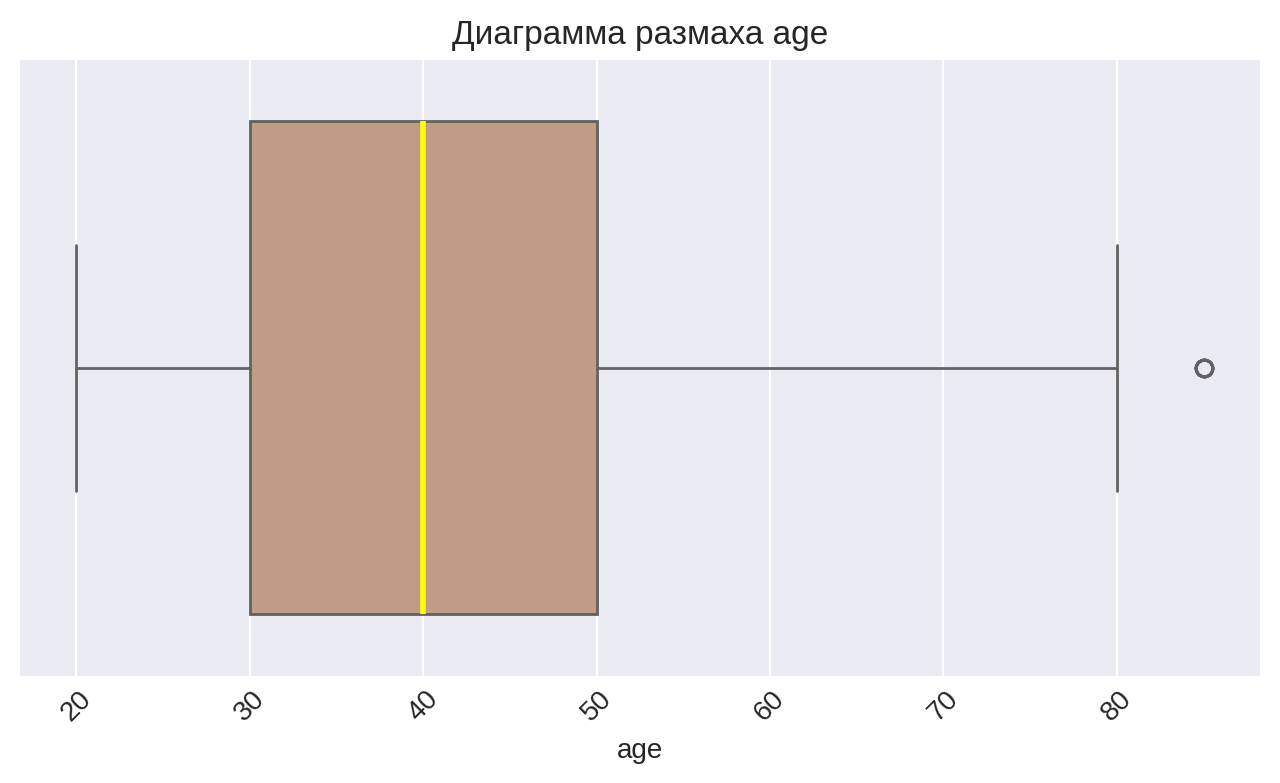

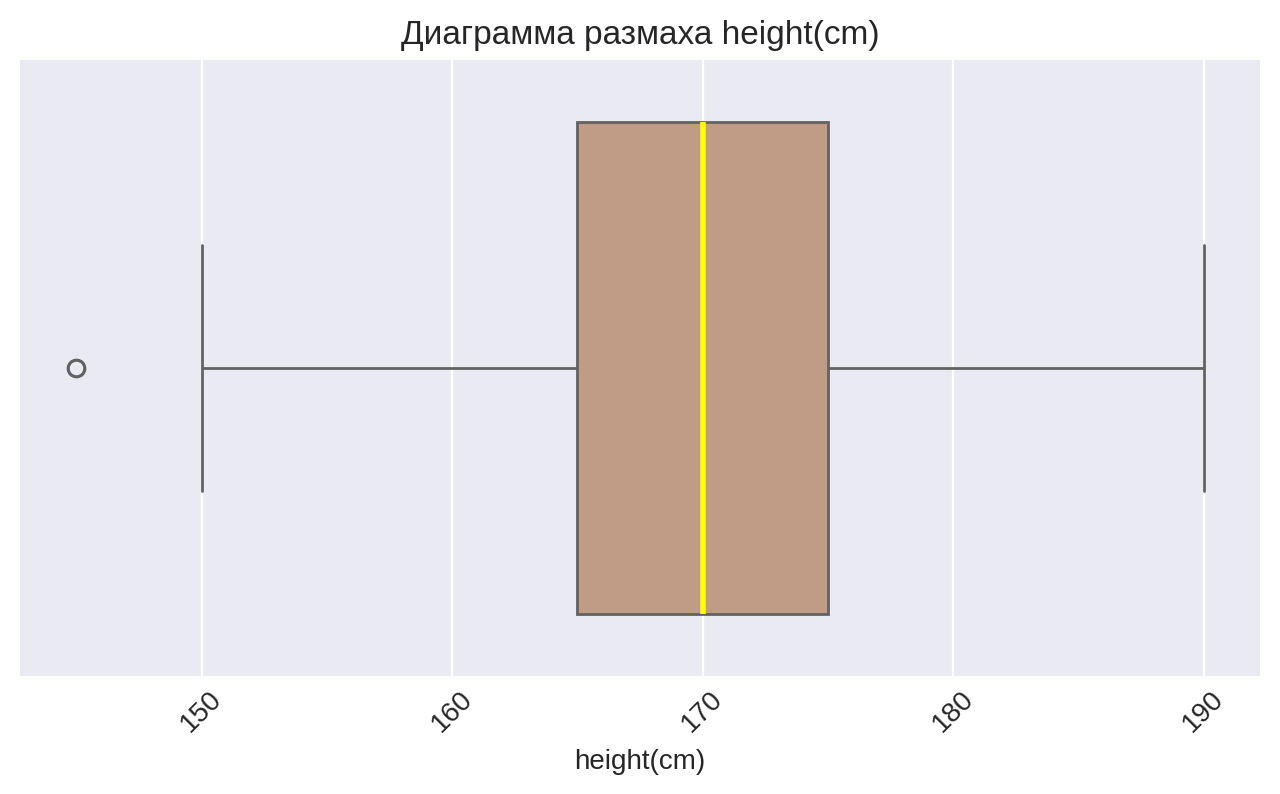

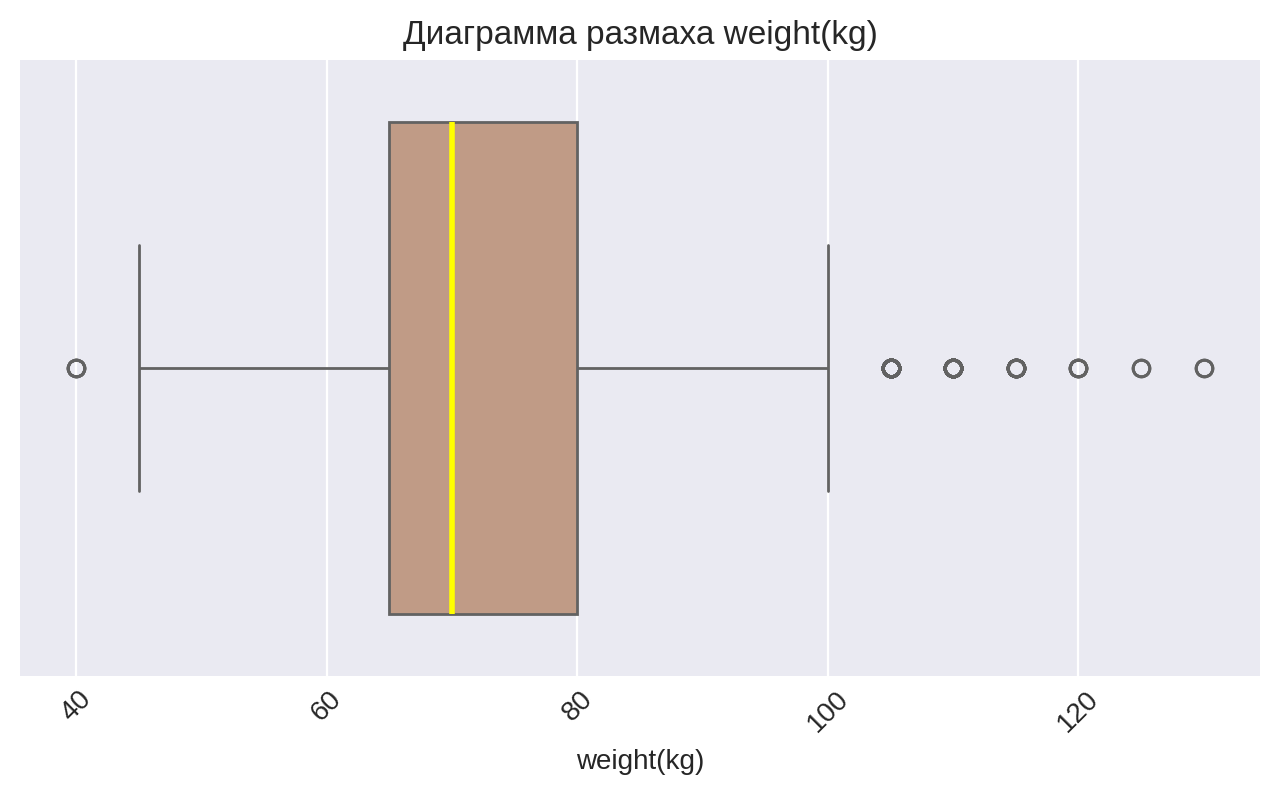

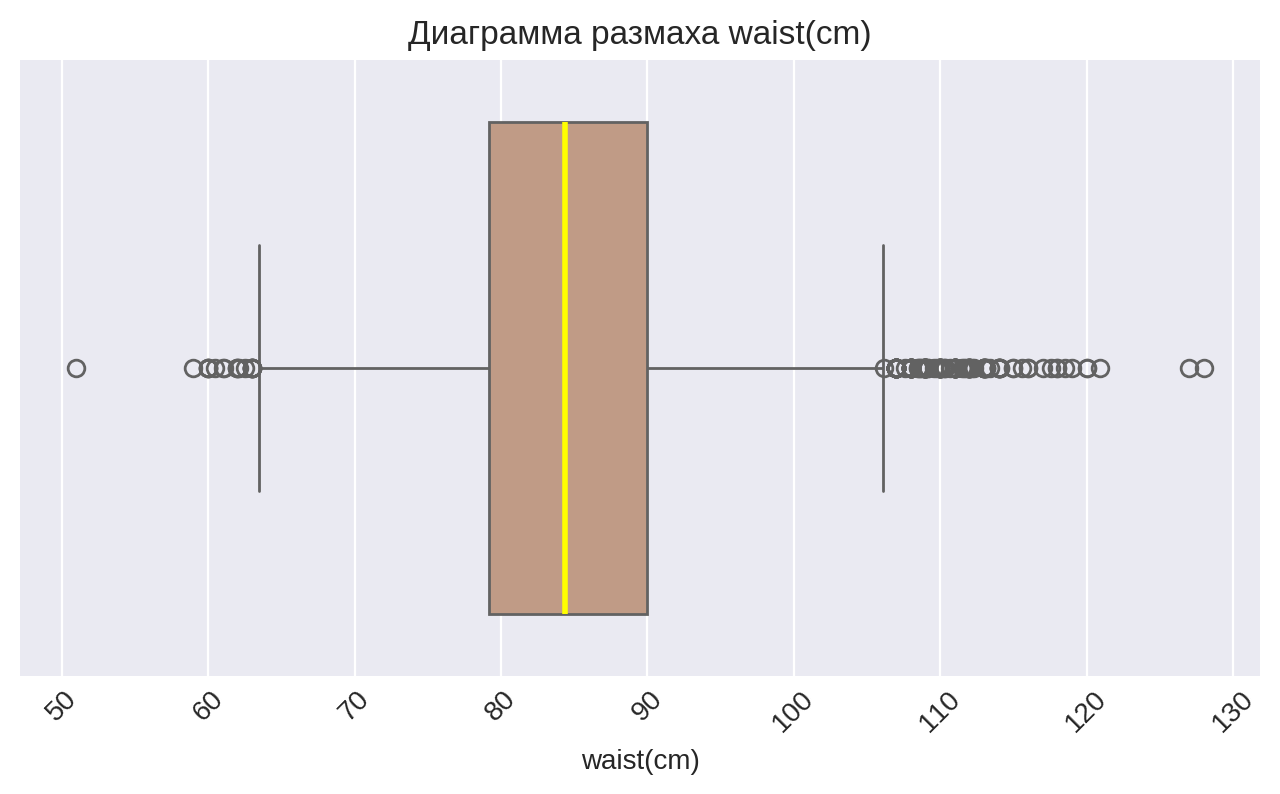

In [22]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("twilight_r")
for col in ["age", "height(cm)", "weight(kg)", "waist(cm)"]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train[col], medianprops={"color": "yellow", "linewidth": 2})
    plt.title(f"Диаграмма размаха {col}")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.show()

### 2.2 Анализ целевого признака `smoking`

In [23]:
train["smoking"].value_counts(normalize=True)

smoking
0    0.798024
1    0.201976
Name: proportion, dtype: float64

In [24]:
train["dental_caries"].value_counts()

dental_caries
0    10923
1     2940
Name: count, dtype: int64

Сразу бросается в глаза наблюдение, что в рассматриваемом датасете соотношение курильщиков и людей с кариесом имеют одинаковое значение ~ 20%

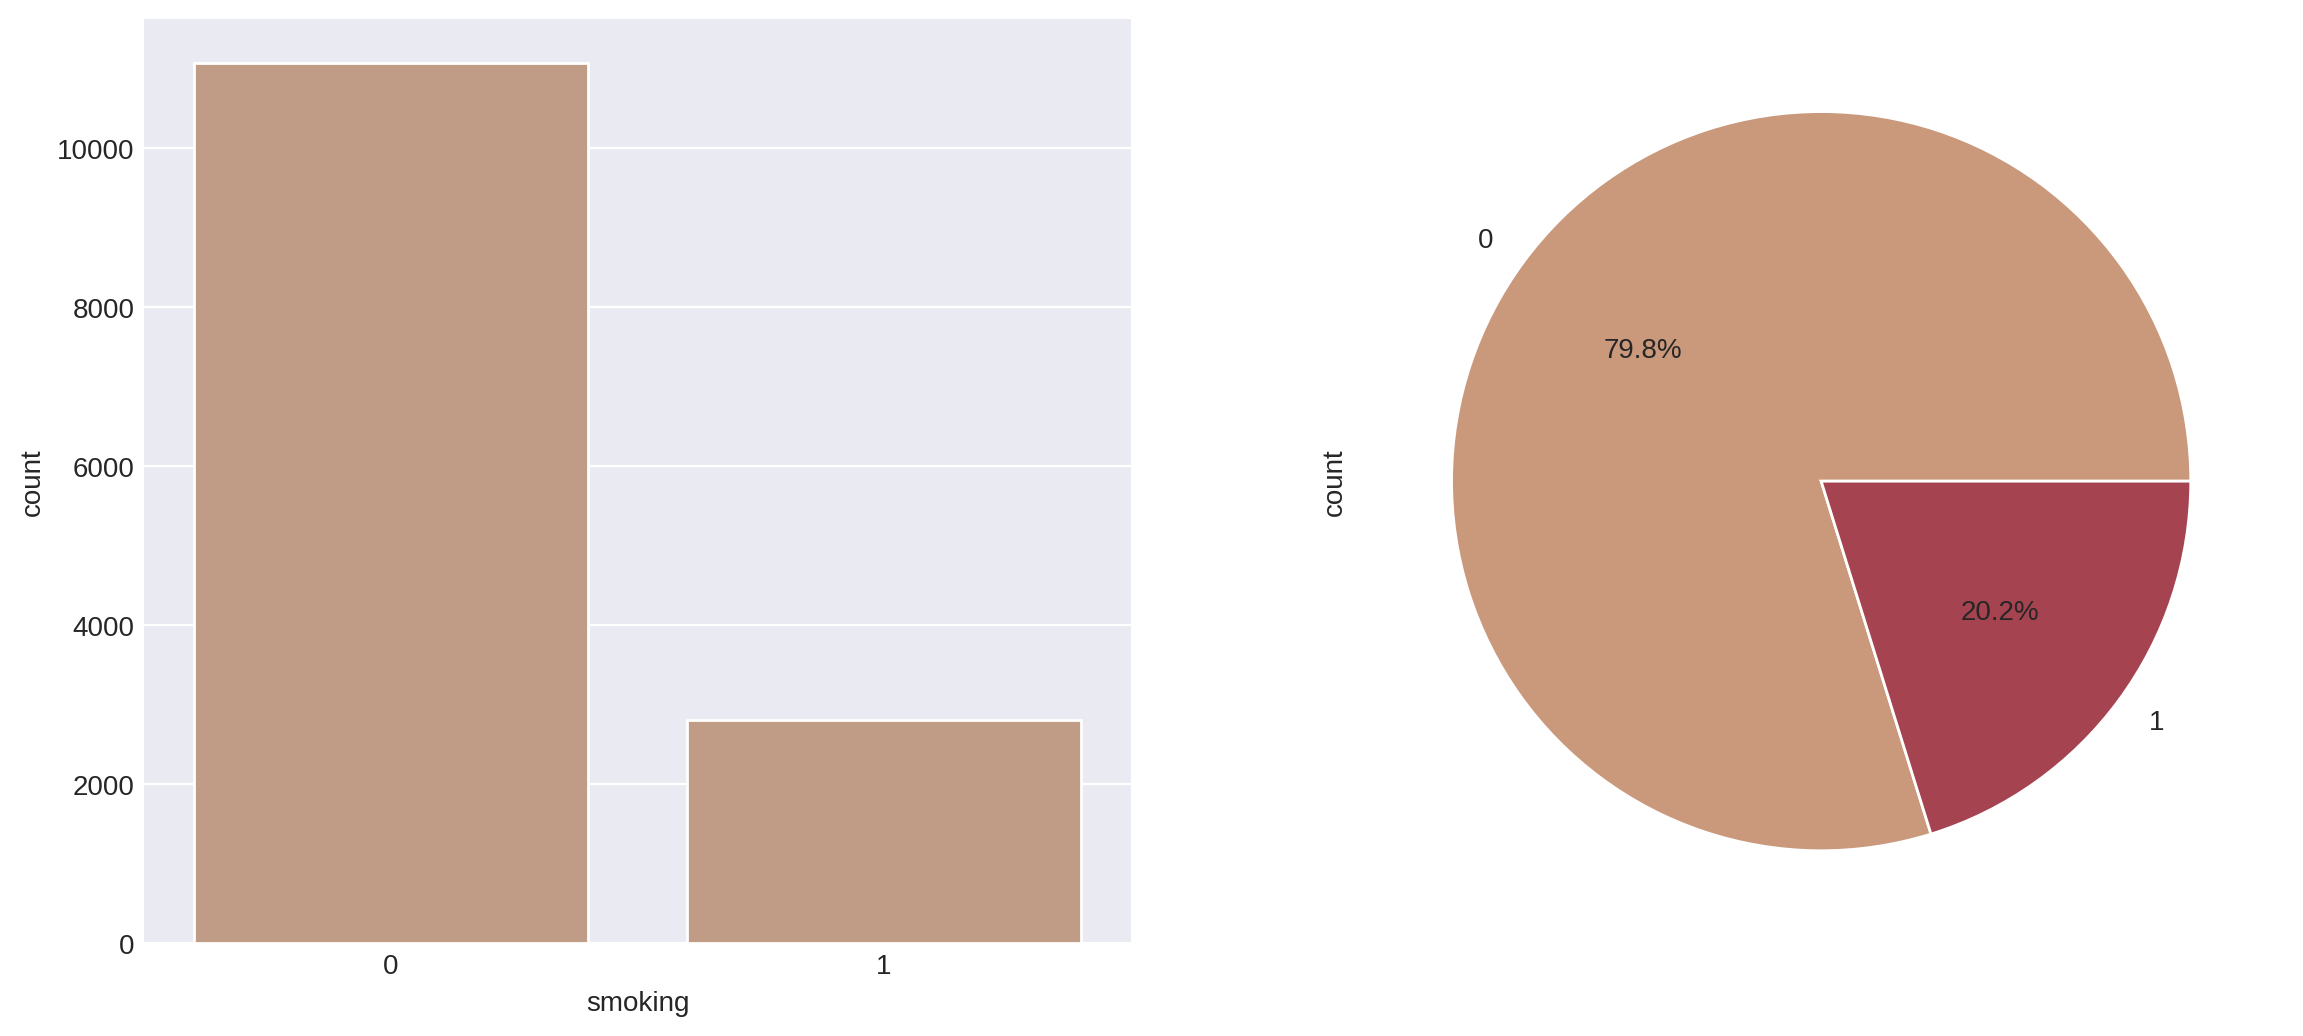

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x=train["smoking"], ax=ax[0])
train["smoking"].value_counts().plot(kind="pie", autopct="%1.1f%%", ax=ax[1])
plt.show()

smoke_1 = train[train["smoking"] == 1].shape[0]
smoke_0 = train[train["smoking"] == 0].shape[0]

In [26]:
display("Курят: ", smoke_1)
display("Не курят: ", smoke_0)

'Курят: '

2800

'Не курят: '

11063

### 2.3 Анализ распределениях данных в числовых признаках

Анализ распределениях данных в числовых признаках с помощью «фай-корреляции». Работает для смешанных, чиловых и категориальных признаков


Она основана на обобщённой χ² (хи-квадрат) статистике и:

работает и для числовых, и для категориальных признаков;

даёт значения в диапазоне от 0 до 1, где

- 0 — независимость признаков,

- 1 — сильная зависимость (функциональная связь).

In [27]:
import phik

In [28]:
phik_overview = train.phik_matrix()

interval columns not set, guessing: ['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride', 'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast', 'alt', 'gtp', 'dental_caries', 'tartar', 'smoking']


In [29]:
phik_overview["smoking"].drop("smoking").sort_values(ascending=False).to_frame()

,smoking
triglyceride,0.190446
age,0.183295
gtp,0.142844
hemoglobin,0.112074
tartar,0.104431
dental_caries,0.089109
waist(cm),0.062694
serum_creatinine,0.055594
hdl,0.050773
weight(kg),0.045916


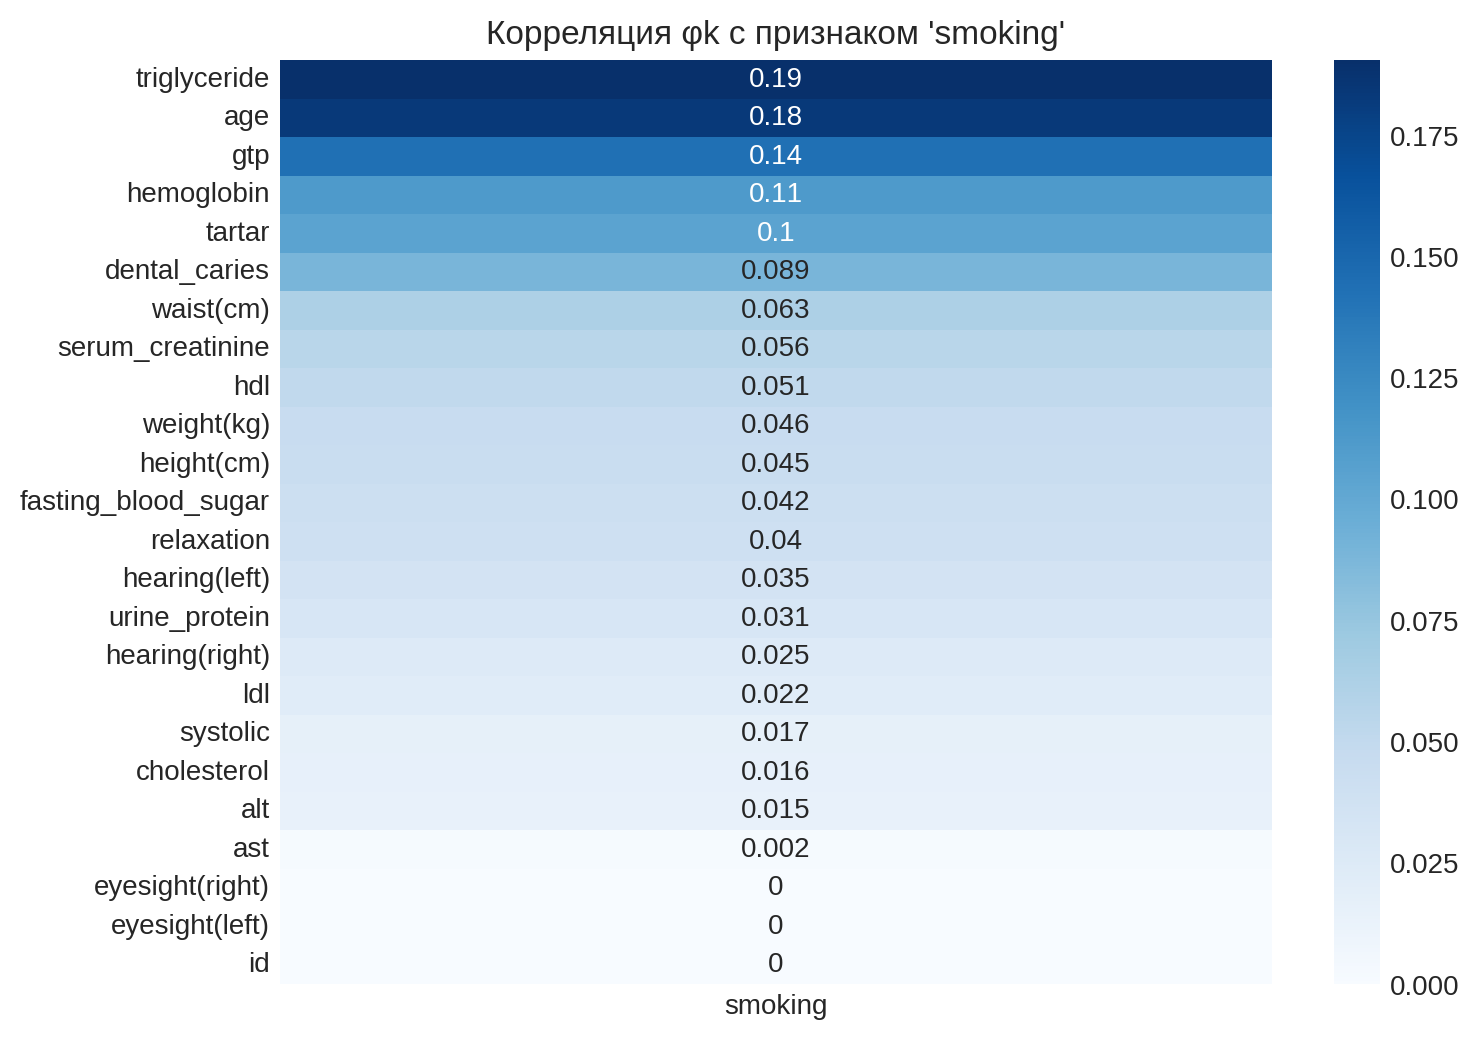

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    phik_overview[["smoking"]]
    .drop("smoking")
    .sort_values(by="smoking", ascending=False),
    annot=True,
    cmap="Blues",
)
plt.title("Корреляция φk с признаком 'smoking'")
plt.show()

**Наиболее значимые признаки**

triglyceride (0.190) и age (0.183) имеют наибольшую корреляцию с курением. Это означает, что уровень триглицеридов и возраст имеют сильное влияние на предсказание курения. gtp (0.143) и hemoglobin (0.112) также заметно коррелируют с курением.

**Менее очевидные зависимости**

tartar (0.104) и dental_caries (0.089) (наличие зубного камня и кариеса) также связаны с курением. Это логично, так как курение влияет на здоровье зубов. waist(cm) (0.063) и serum_creatinine (0.056) показывают небольшую, но всё же заметную зависимость.

**Наименее полезные признаки**

eyesight(left) (0.000) и eyesight(right) (0.000) не дают никакой полезной информации. Их можно удалить. id (0.000) тоже бесполезен — это просто идентификатор. cholesterol (0.016), ast (0.002), alt (0.015), systolic (0.017), ldl (0.022) имеют очень слабую связь, их влияние незначительно.

### 2.4 Анализ признаков

#### 2.4.1 Анализ `age`.

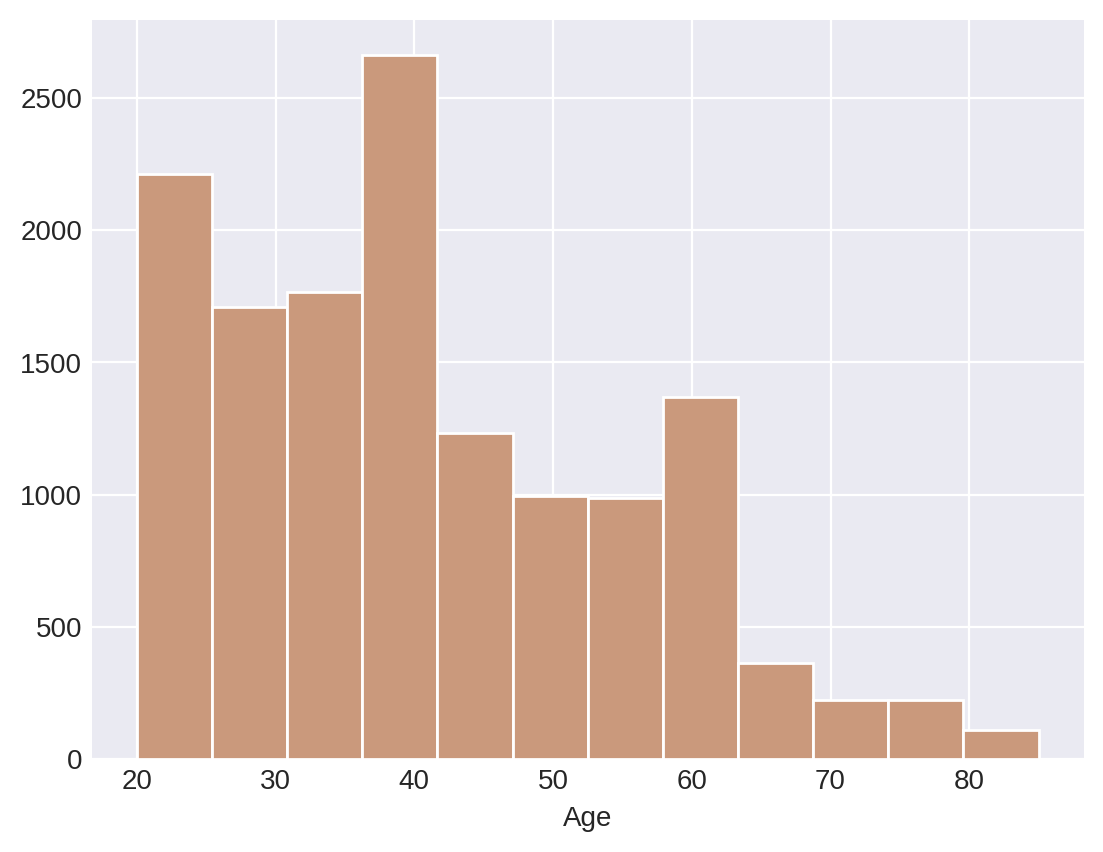

In [31]:
train["age"].hist(bins=12)
plt.xlabel("Age");

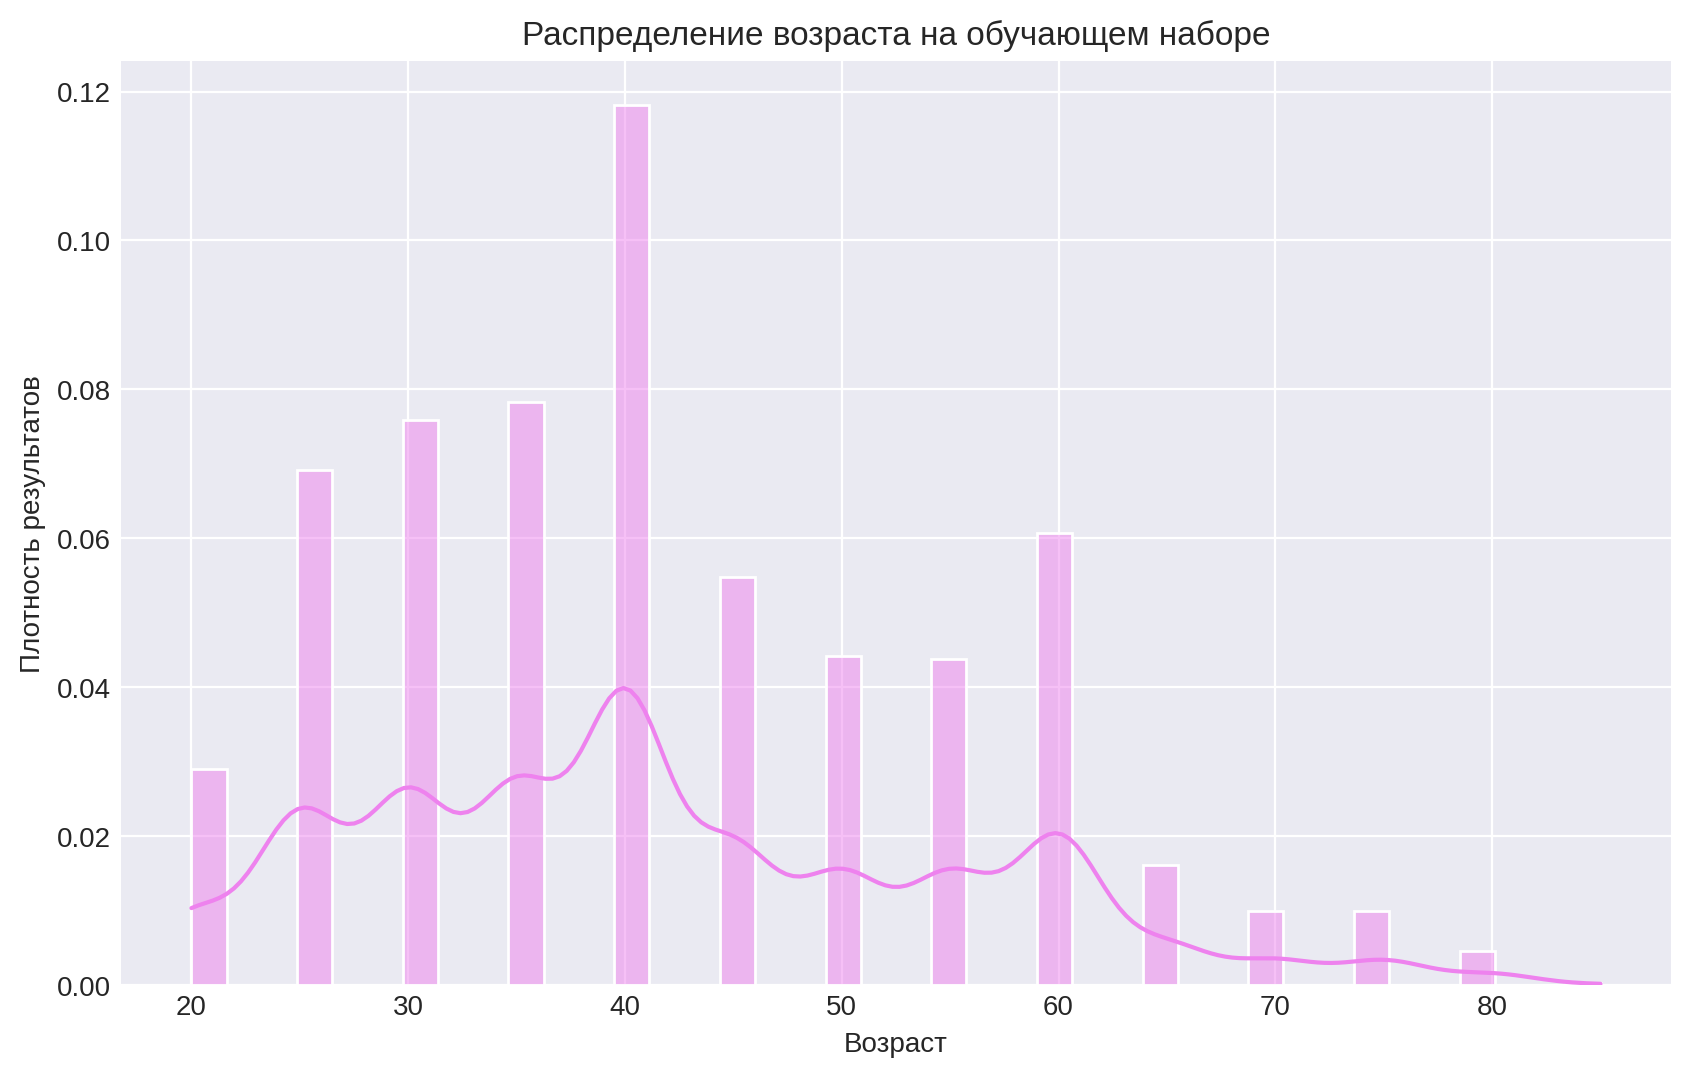

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(train["age"], kde=True, color="violet", stat="density", alpha=0.5)
plt.xlabel("Возраст")
plt.ylabel("Плотность результатов")
plt.title("Распределение возраста на обучающем наборе")
plt.show()

In [33]:
train["age"].describe()

count    13863.000000
mean        41.743851
std         13.624383
min         20.000000
25%         30.000000
50%         40.000000
75%         50.000000
max         85.000000
Name: age, dtype: float64

Медианный возраст в выборке - 40 лет

Минимальный - 20 лет

Максимальный - 85 лет

при этом выбросов в этом признаке всего 8


In [34]:
# создадим отдельно датасеты курящих и некурящих
df_smokers = train[train["smoking"] == 1]
df_non_smokers = train[train["smoking"] == 0]
age_smoking = df_smokers.groupby("age")["smoking"].agg(["count"])
age_non_smoking = df_non_smokers.groupby("age")["smoking"].agg(["count"])
print("Распределение курящих по возрастам")
age_smoking

Распределение курящих по возрастам


,count
age,
20,112
25,258
30,280
35,303
40,735
45,338
50,256
55,208
60,231


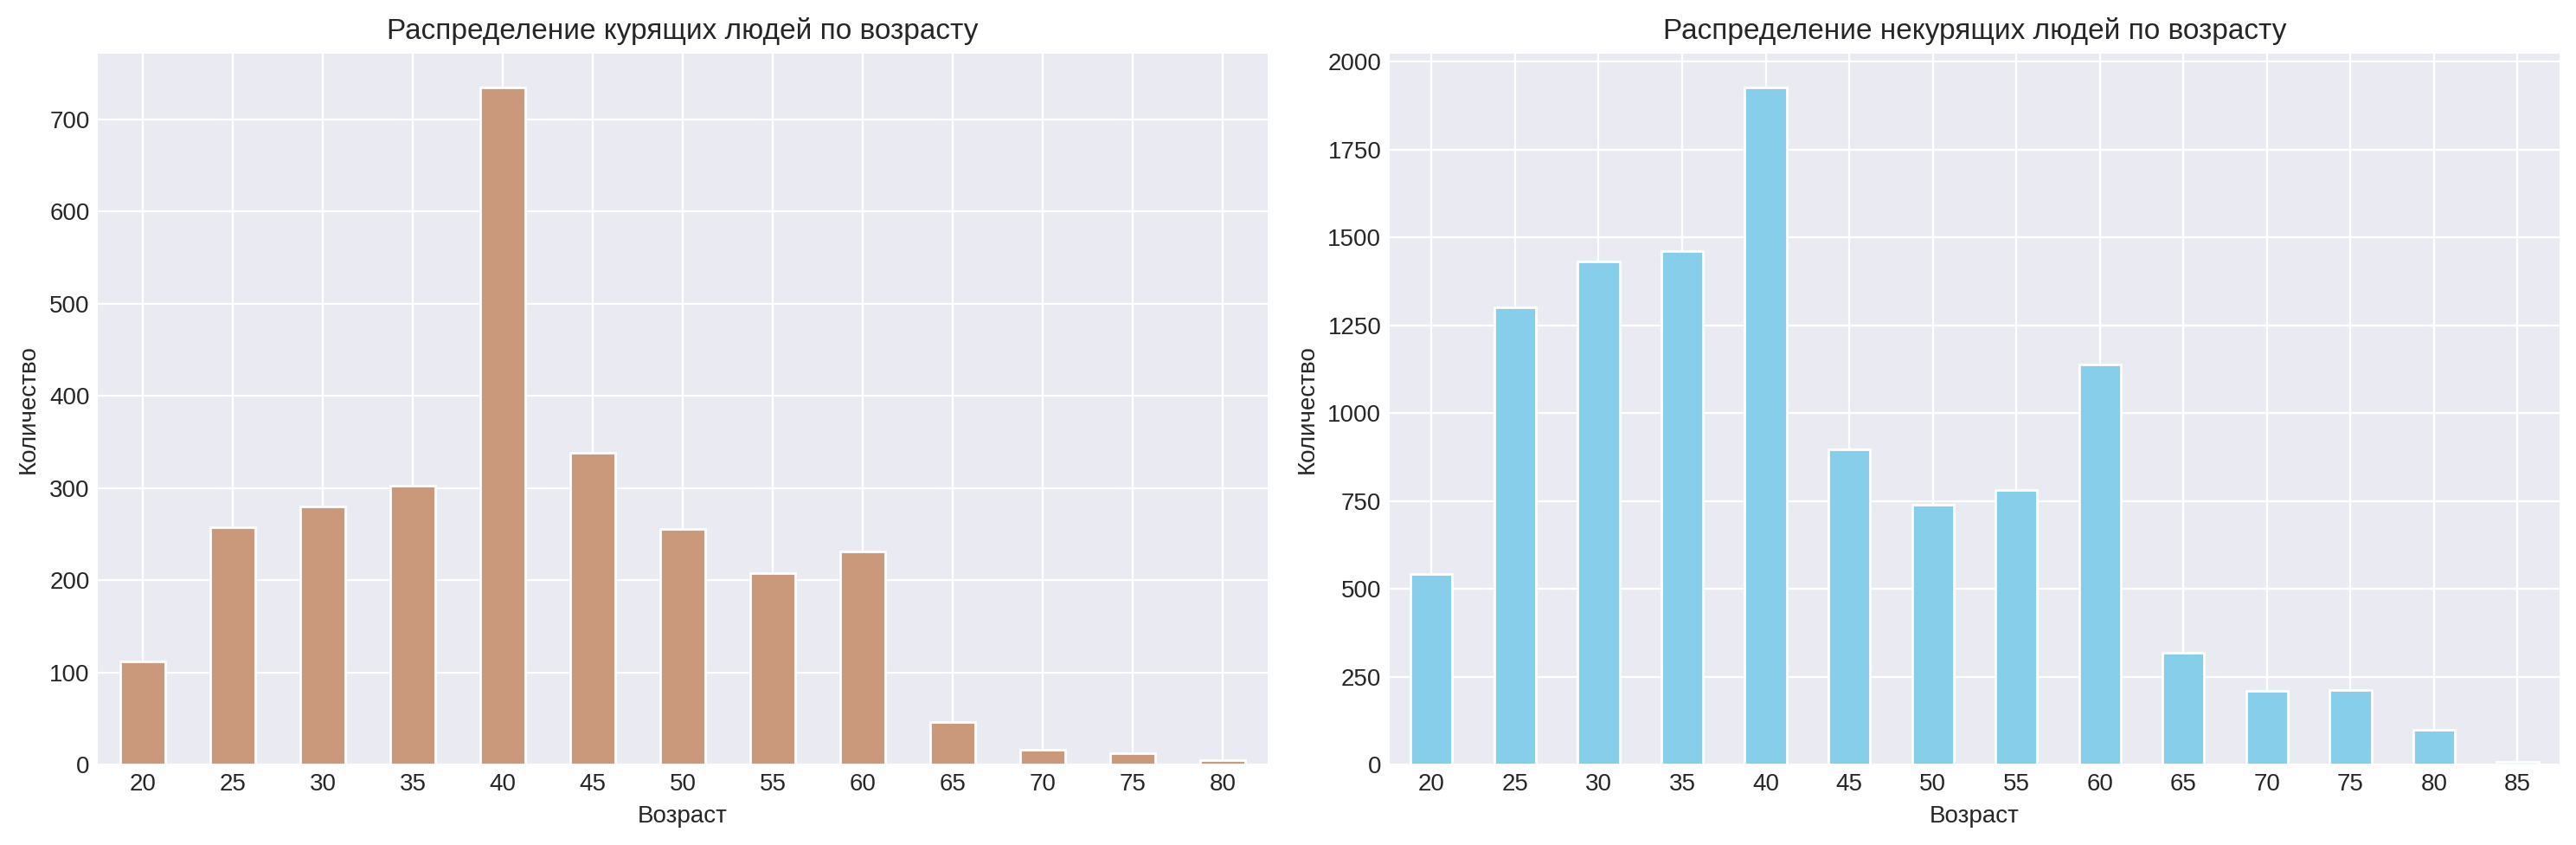

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

age_smoking["count"].plot(kind="bar", rot=0, ax=ax[0])
ax[0].set_title("Распределение курящих людей по возрасту")
ax[0].set_xlabel("Возраст")
ax[0].set_ylabel("Количество")

age_non_smoking["count"].plot(kind="bar", rot=0, ax=ax[1], color="skyblue")
ax[1].set_title("Распределение некурящих людей по возрасту")
ax[1].set_xlabel("Возраст")
ax[1].set_ylabel("Количество")

plt.tight_layout()
plt.show()

Построим график оценки плотности вероятности (Kernel Density Estimate) —  кривую, показывающую, как распределены значения признака  `age` в выборках

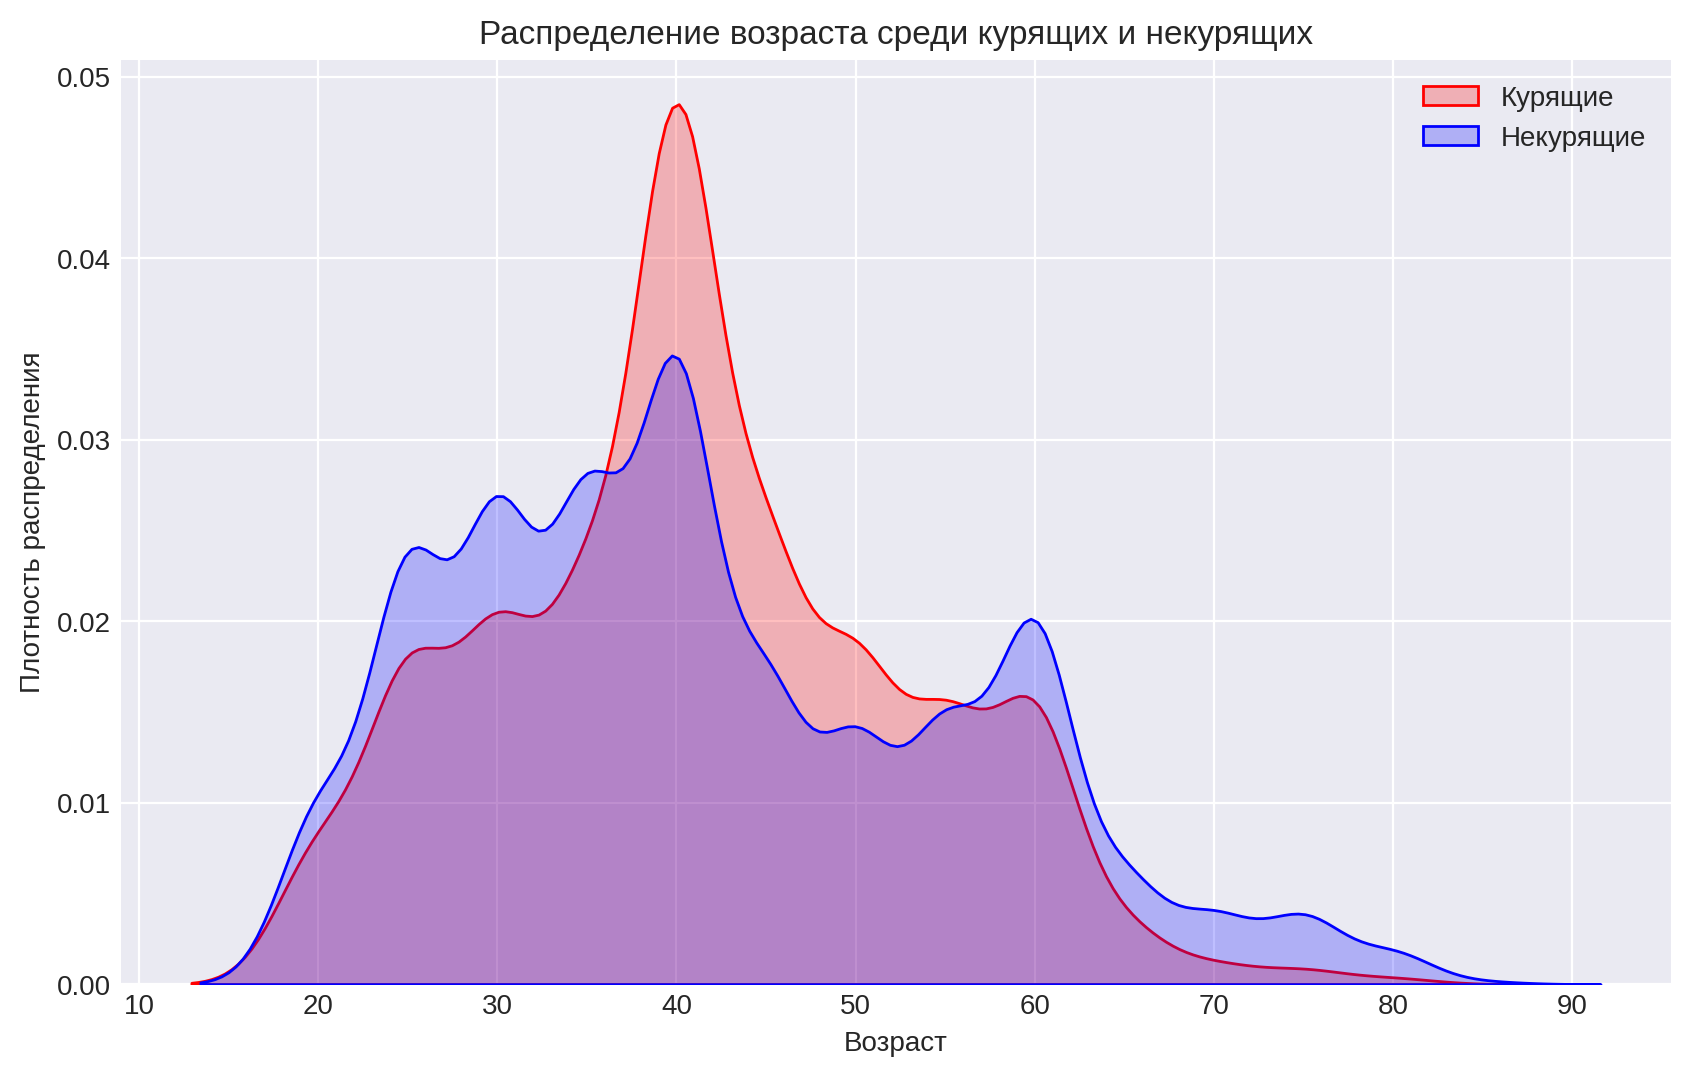

In [36]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_smokers["age"], label="Курящие", fill=True, color="red")
sns.kdeplot(df_non_smokers["age"], label="Некурящие", fill=True, color="blue")
plt.title("Распределение возраста среди курящих и некурящих")
plt.xlabel("Возраст")
plt.ylabel("Плотность распределения")
plt.legend()
plt.show()

Большинство курящих сосредоточены в возрасте 35–50 лет, с максимальной плотностью около 40 лет.
Распределения обеих групп имеют схожую форму, но у некурящих видны отдельные наблюдения в старшем возрасте, что может указывать на выбросы или меньшую плотность данных.

In [37]:
smokers_40 = (
    (age_smoking[age_smoking.index == 40]["count"].values[0])
    / train["smoking"].sum()
    * 100
)
smokers_40
print(f"Доля курильщиков в возрасте 40 лет от общего числа курящих: {smokers_40:.2f}%")

Доля курильщиков в возрасте 40 лет от общего числа курящих: 26.25%


In [38]:
age_smoking["mean"] = (age_smoking["count"] / age_smoking["count"].sum()).round(2)
age_smoking.sort_values(by="mean", ascending=False)
age_smoking_sorted = age_smoking.sort_values(by="mean", ascending=False)

age_smoking_sorted.style.background_gradient(cmap="coolwarm", subset=["mean"])

,count,mean
age,,
40,735,0.260000
45,338,0.120000
35,303,0.110000
30,280,0.100000
25,258,0.090000
50,256,0.090000
60,231,0.080000
55,208,0.070000
20,112,0.040000


**Вывод:** Пик доли курящих приходится на возраст 40–45 лет; после 45 лет наблюдается устойчивое снижение.

#### 2.4.2 Анализ `height(cm), weight(kg), waist(cm)`

Для этих признаков построим Q-Q график чтобы сравнить распределение величин в них с нормальным

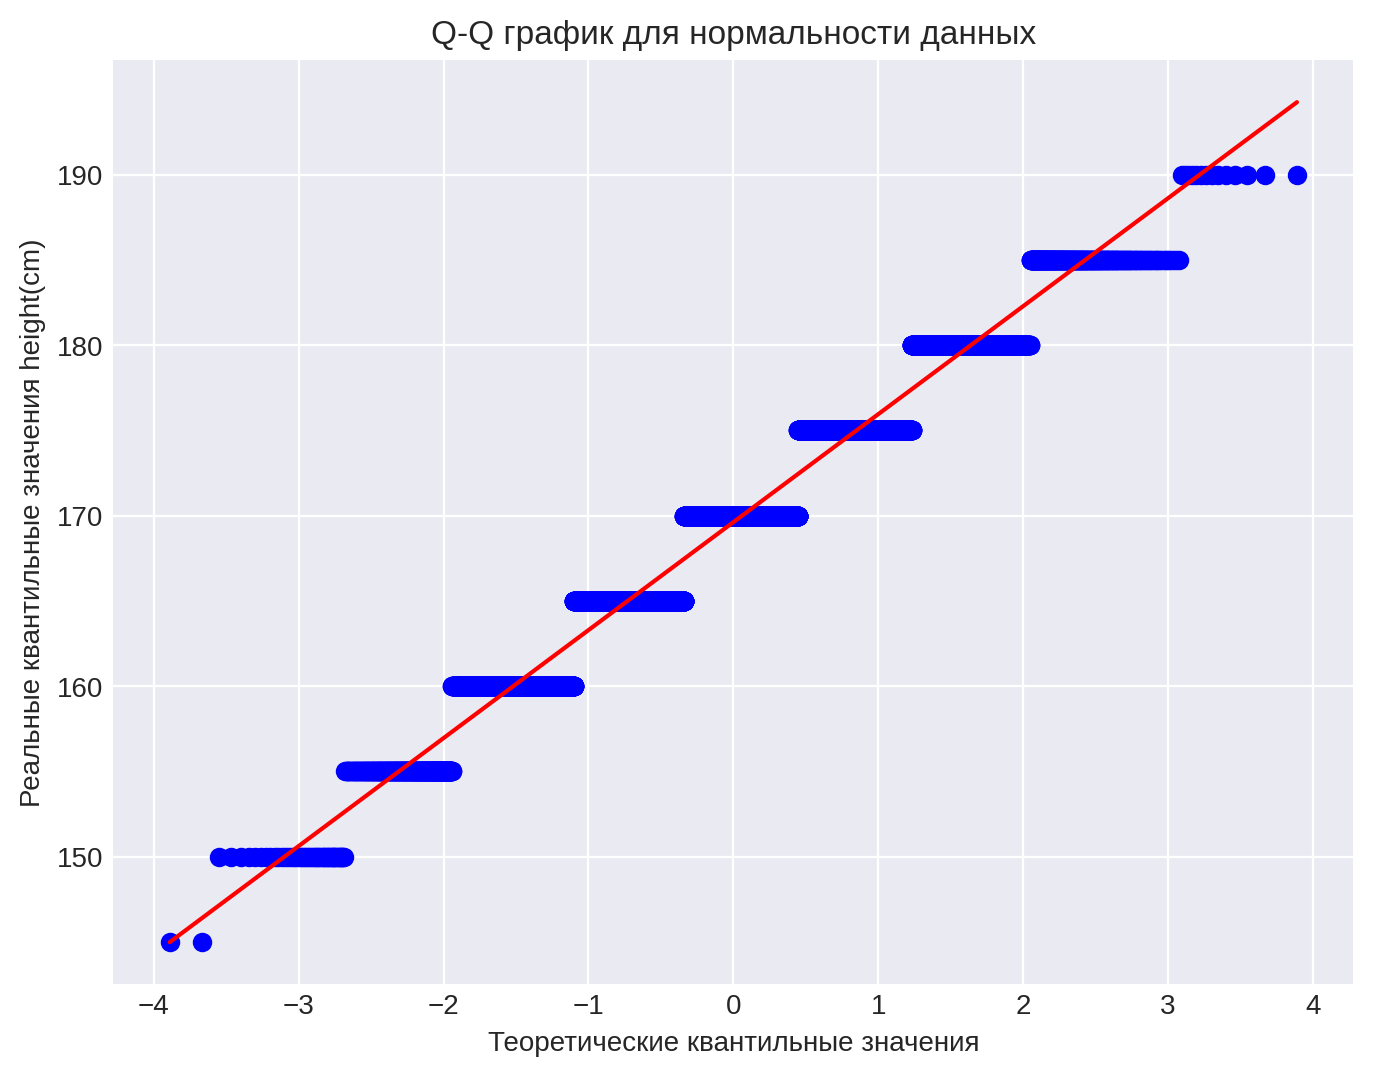

In [39]:
plt.figure(figsize=(8, 6))
stats.probplot(train["height(cm)"], dist="norm", plot=plt)
plt.title("Q-Q график для нормальности данных")
plt.xlabel("Теоретические квантильные значения")
plt.ylabel("Реальные квантильные значения height(cm)")
plt.show()

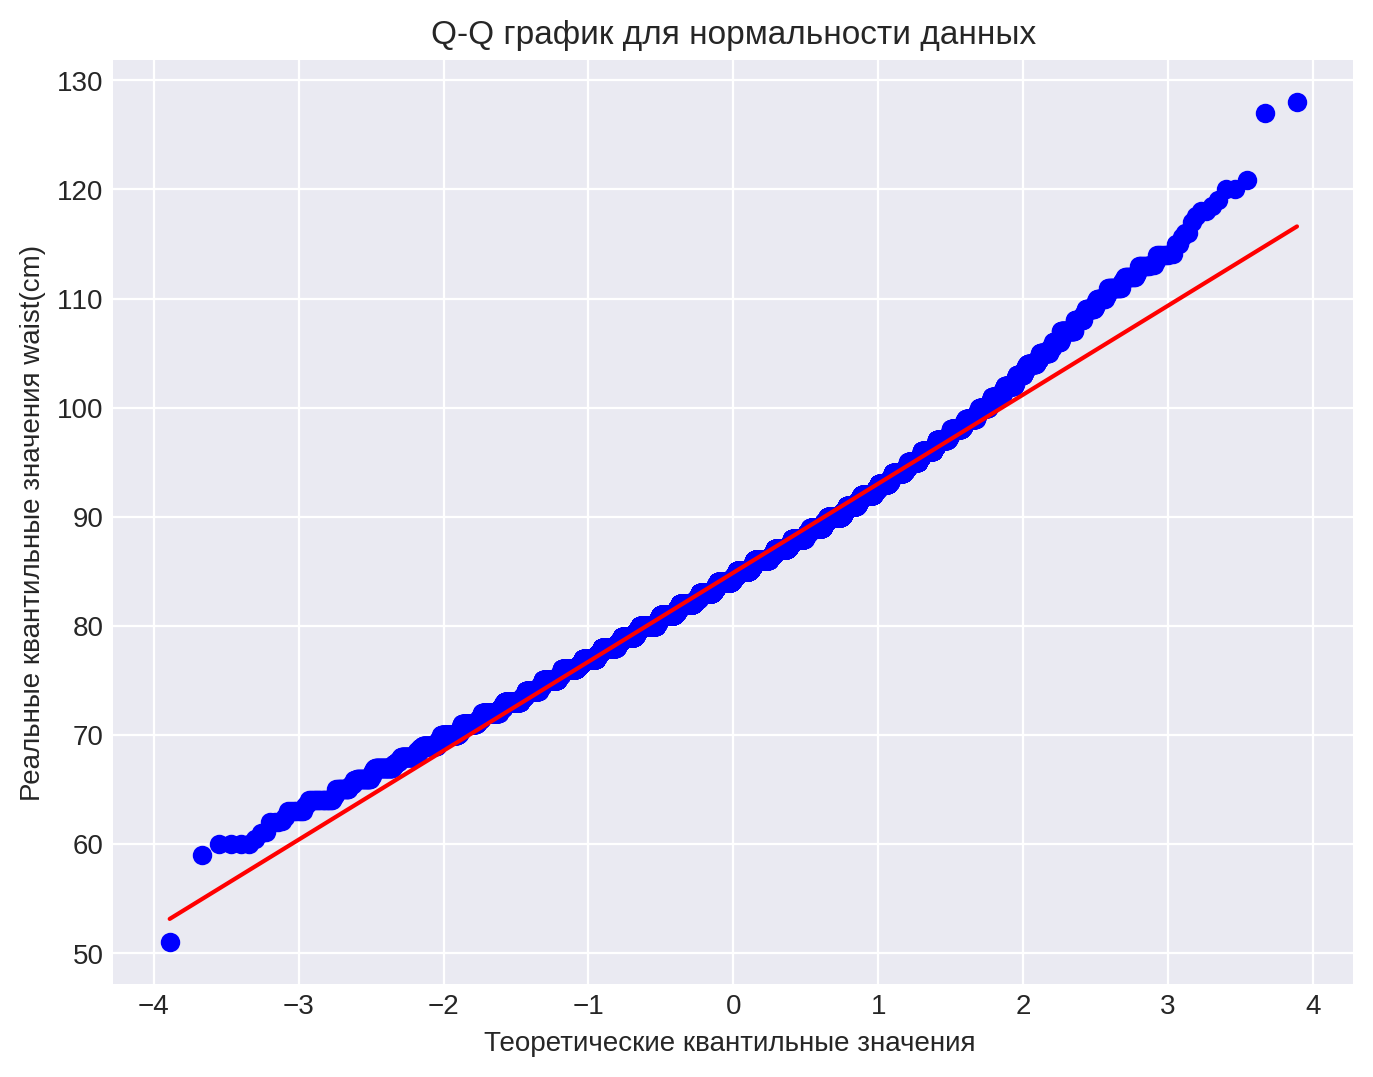

In [40]:
plt.figure(figsize=(8, 6))
stats.probplot(train["waist(cm)"], dist="norm", plot=plt)
plt.title("Q-Q график для нормальности данных")
plt.xlabel("Теоретические квантильные значения ")
plt.ylabel("Реальные квантильные значения waist(cm)")
plt.show()

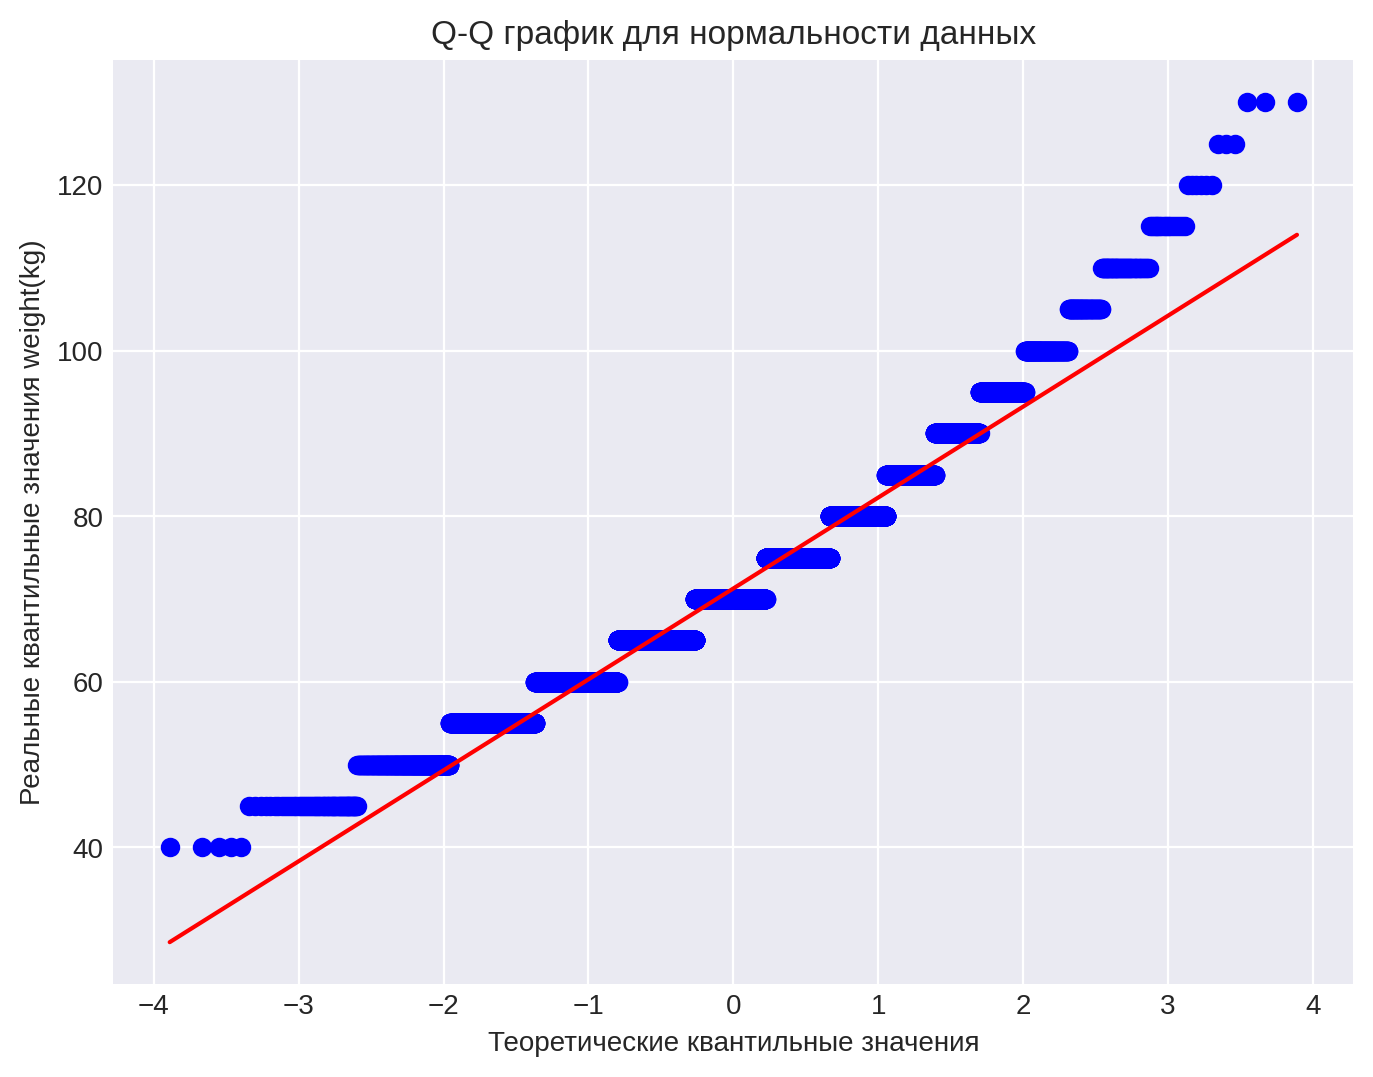

In [41]:
plt.figure(figsize=(8, 6))
stats.probplot(train["weight(kg)"], dist="norm", plot=plt)
plt.title("Q-Q график для нормальности данных")
plt.xlabel("Теоретические квантильные значения")
plt.ylabel("Реальные квантильные значения weight(kg)")
plt.show()

Распределение в признаках приближается к нормальному но имеет отклонения

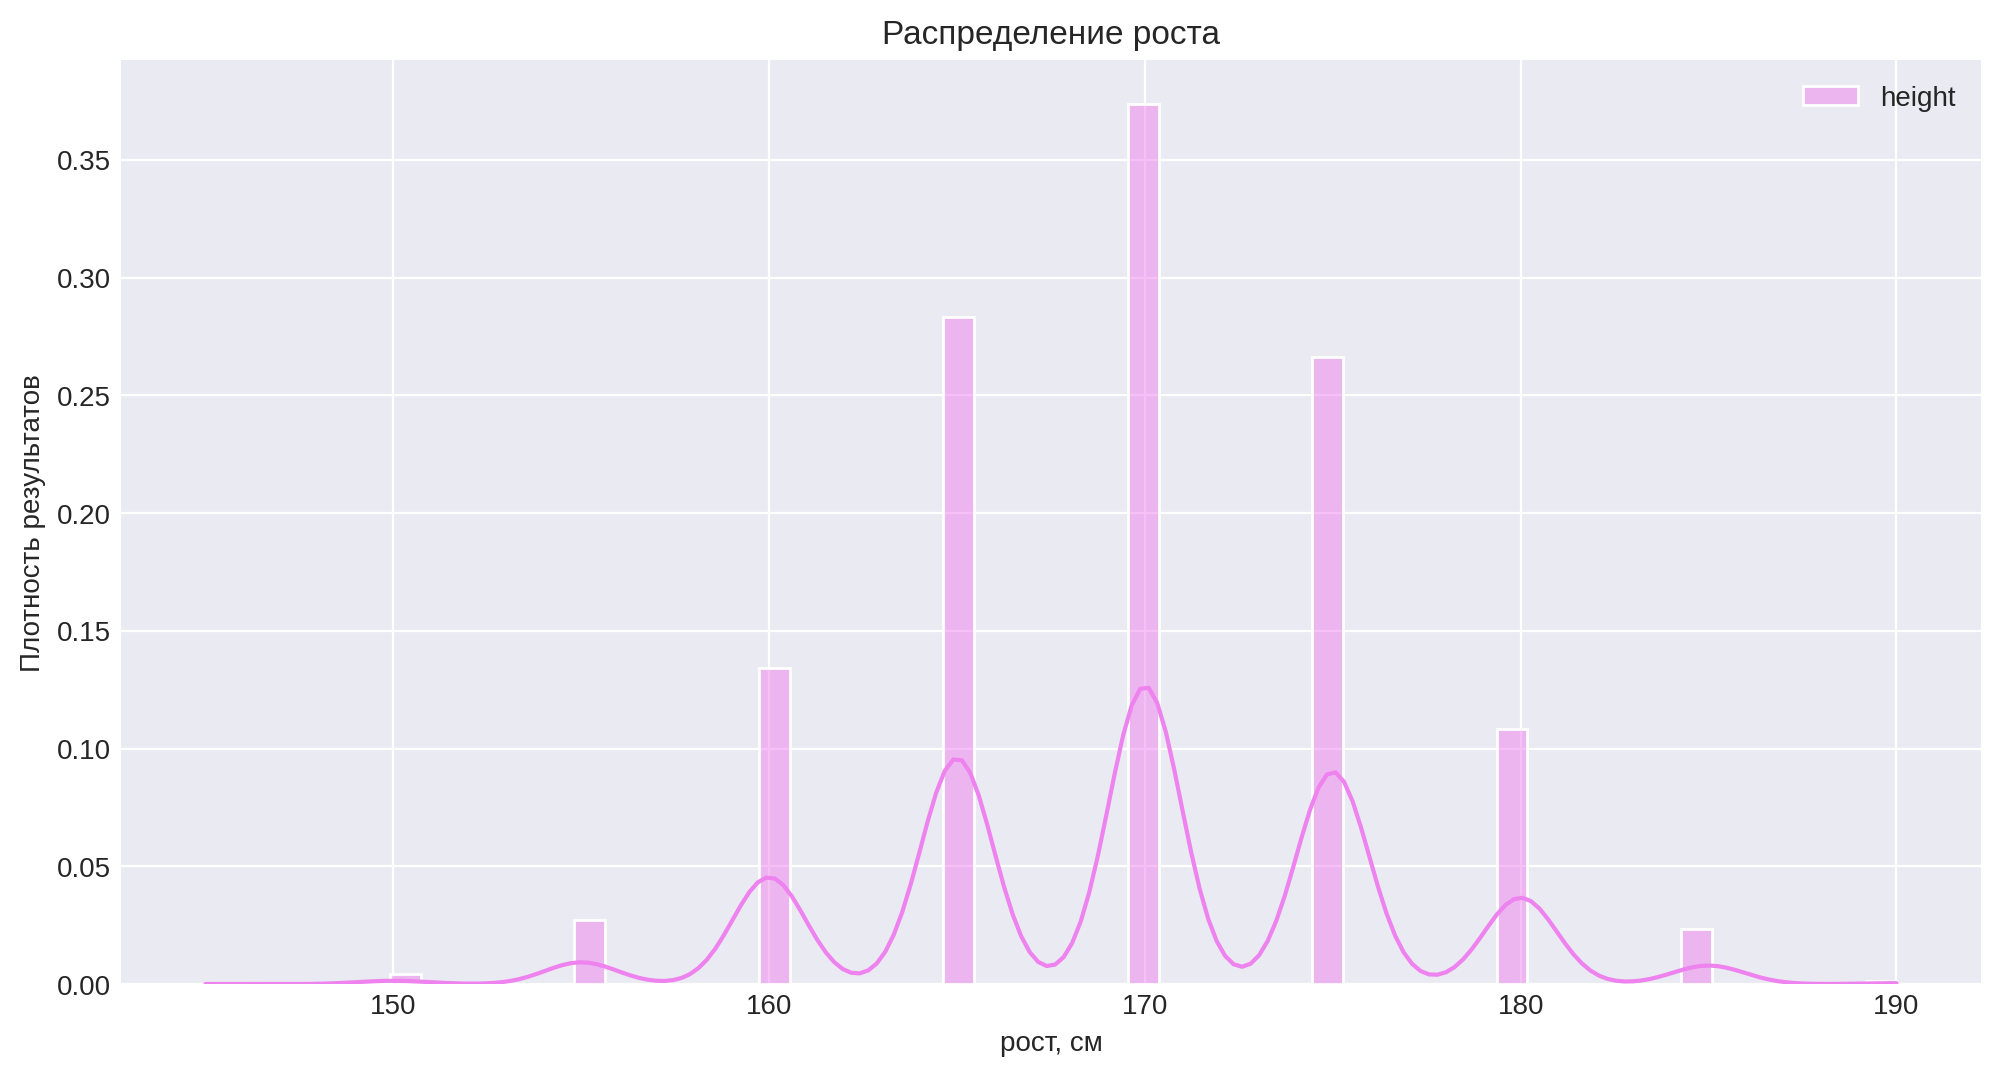

In [42]:
plt.figure(figsize=(12, 6))
sns.histplot(
    train["height(cm)"],
    kde=True,
    color="violet",
    stat="density",
    label="height",
    alpha=0.5,
)
plt.xticks()
plt.xlabel("рост, см")
plt.ylabel(
    "Плотность результатов",
)
plt.title("Распределение роста")
plt.legend()
plt.show()

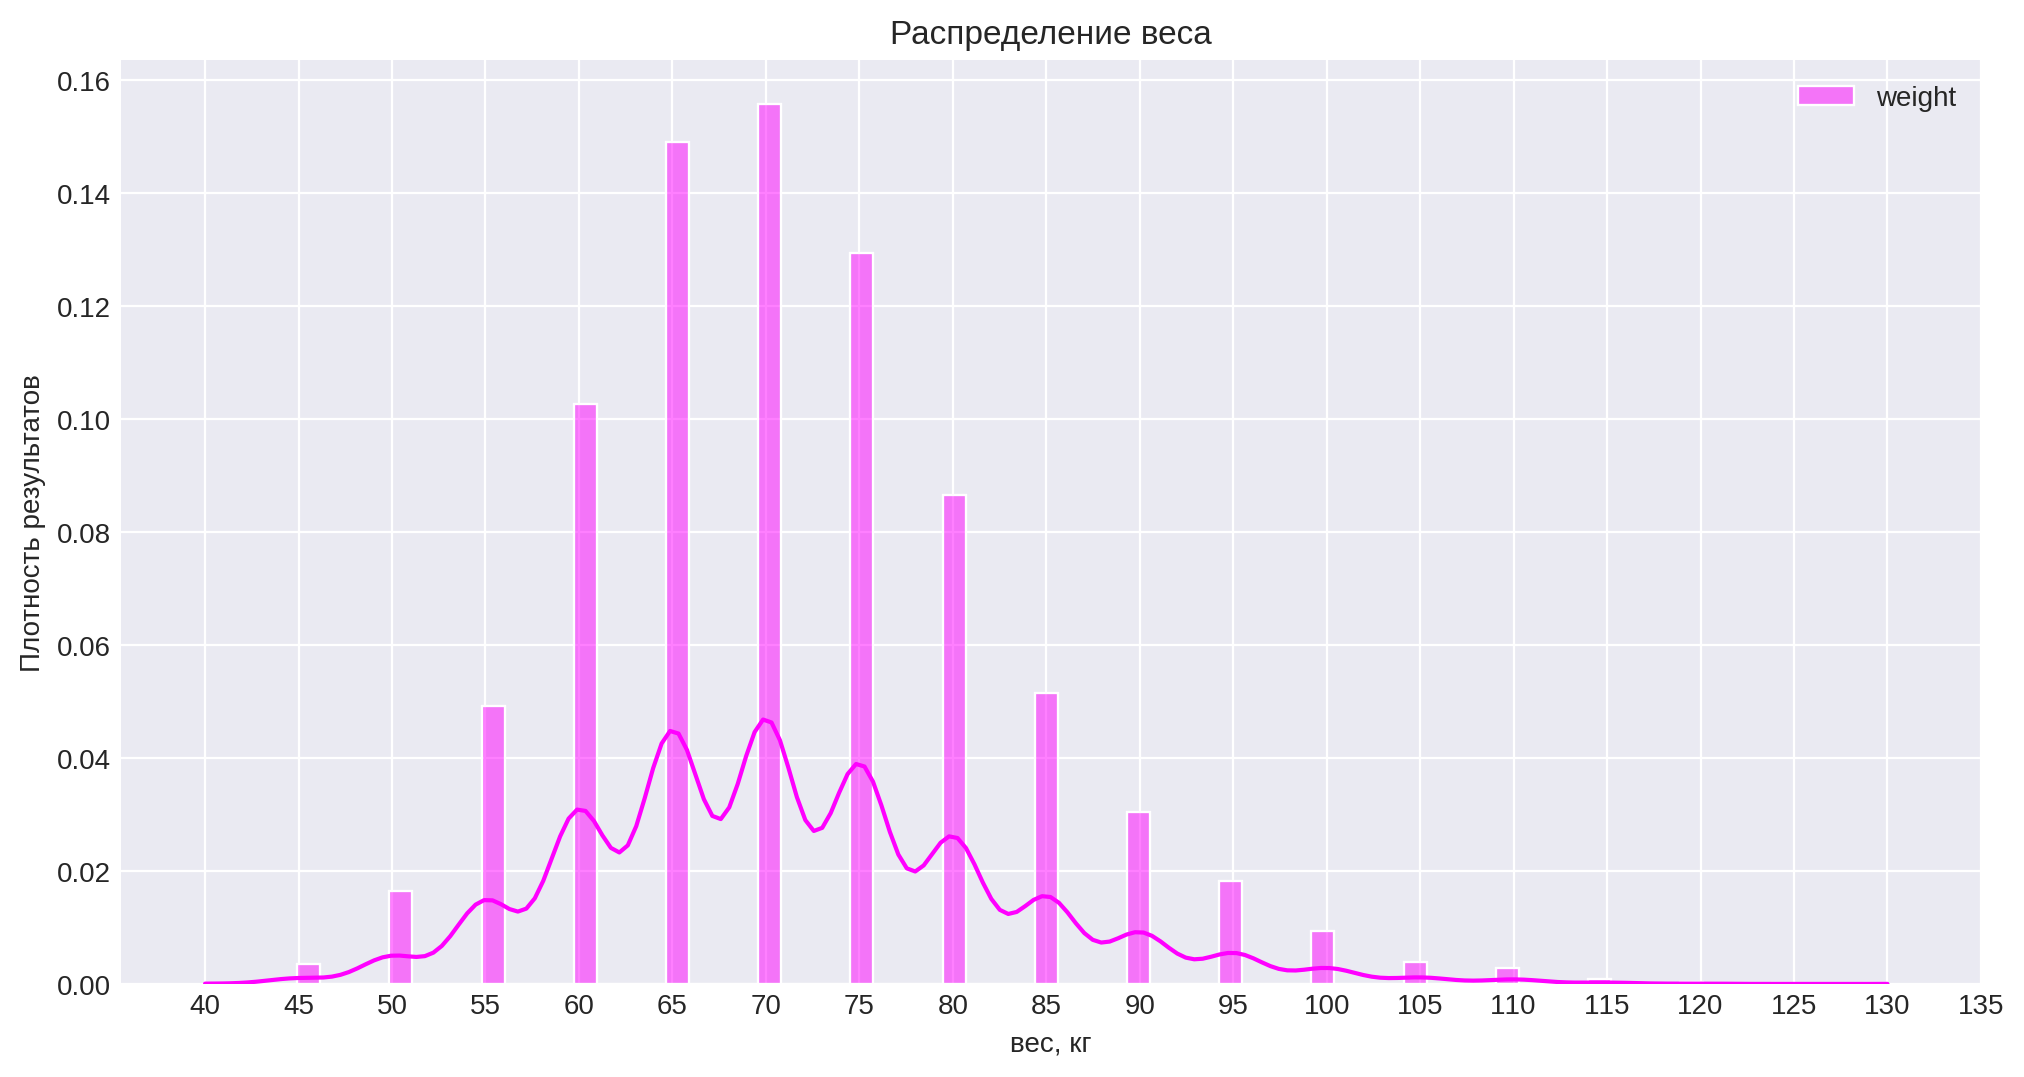

In [43]:
plt.figure(figsize=(12, 6))
sns.histplot(
    train["weight(kg)"],
    kde=True,
    color="magenta",
    stat="density",
    label="weight",
    alpha=0.5,
)
plt.xticks(range(40, 140, 5))
plt.xlabel("вес, кг")
plt.ylabel(
    "Плотность результатов",
)
plt.title("Распределение веса")
plt.legend()
plt.show()

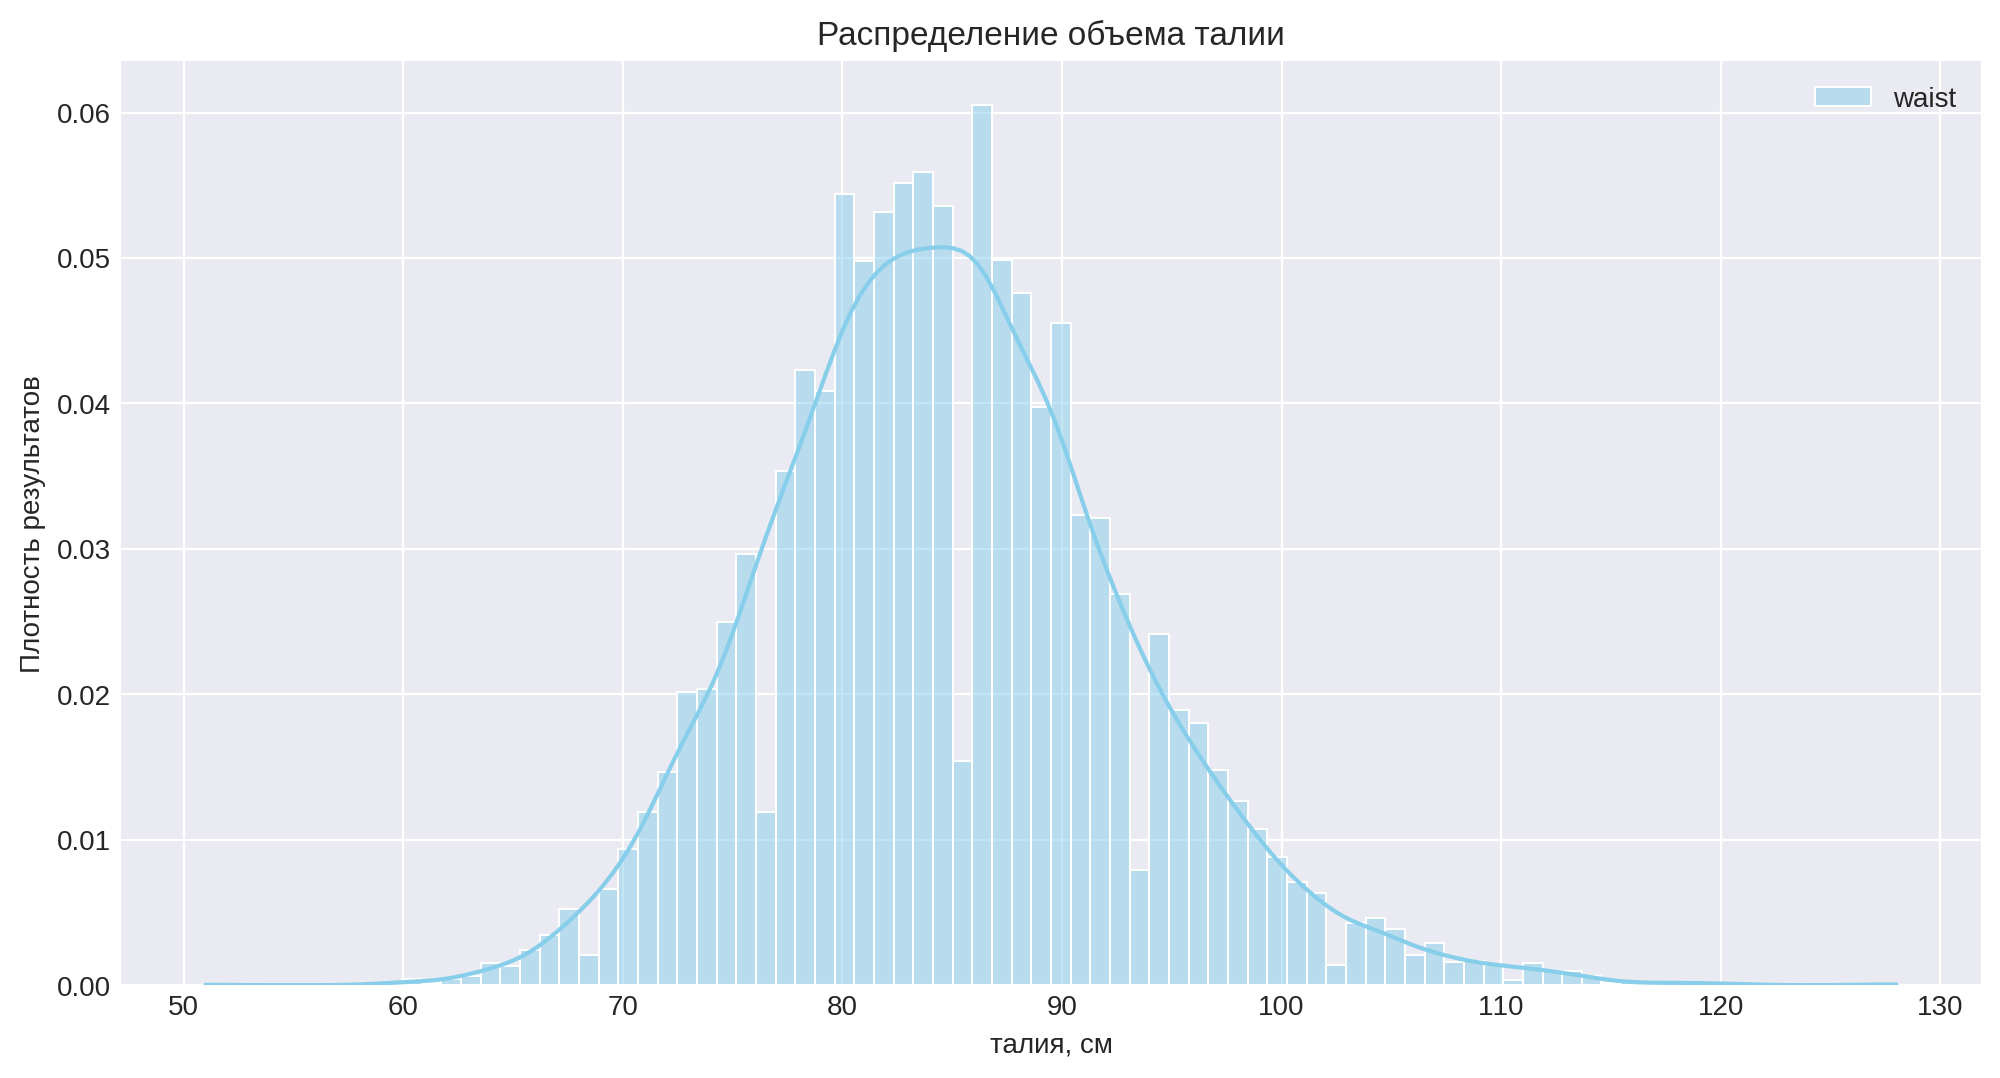

In [44]:
plt.figure(figsize=(12, 6))
sns.histplot(
    train["waist(cm)"],
    kde=True,
    color="skyblue",
    stat="density",
    label="waist",
    alpha=0.5,
)
# plt.xticks(range(40,130,5))
plt.xlabel("талия, см")
plt.ylabel(
    "Плотность результатов",
)
plt.title("Распределение объема талии")
plt.legend()
plt.show()

In [45]:
train["height(cm)"].value_counts()

height(cm)
170    4238
165    3213
175    3021
160    1521
180    1230
155     311
185     265
150      48
190      14
145       2
Name: count, dtype: int64

Значения роста указаны для диапазонов с шагом 5. Также указаны значения веса. Найдем средние значения веса, роста и объема талии для нашего датасета. Обратим также внимание что данных о поле не предоставлено

In [46]:
for col in ["height(cm)", "weight(kg)", "waist(cm)"]:
    print(f"Среднее значение {col}: {train[col].mean().round(2)}")

Среднее значение height(cm): 169.62
Среднее значение weight(kg): 71.27
Среднее значение waist(cm): 84.87


Проведем статистический тест для нашей выборки чтобы оценить распределение данных числовых величин.

H0 - данные распределены нормально

Н1 - данные распределены отлично от нормального

Если p-value < 0.05, то отвергаем H0, то есть данные не являются нормальными.

In [47]:
from scipy.stats import normaltest

for col in ["height(cm)", "weight(kg)", "waist(cm)"]:
    stat, p = normaltest(train[col])
    print(f"{col}: статистика={stat:.2f}, p-value={p:.5f}")

    if p < 0.05:
        print(f"⚠️ {col}: Данные НЕ распределены нормально (p < 0.05)")
    else:
        print(f"✅ {col}: Данные можно считать нормально распределёнными (p >= 0.05)")

height(cm): статистика=13.85, p-value=0.00098
⚠️ height(cm): Данные НЕ распределены нормально (p < 0.05)
weight(kg): статистика=1035.31, p-value=0.00000
⚠️ weight(kg): Данные НЕ распределены нормально (p < 0.05)
waist(cm): статистика=458.02, p-value=0.00000
⚠️ waist(cm): Данные НЕ распределены нормально (p < 0.05)


**Вывод:**

описательные признаки не имеют нормального распределения поэтому в качестве модели лучше использовать методы, устойчивые к ненормальному распределению (например, градиентный бустинг или деревья решений).

### 2.5 Анализ медицинских показателей

Обратим внимание на показатели, имеющие наибольшую линейную зависимость с целевым признаком `triglyceride`, `hemoglobin`, `gtp` а также `dental_caries` и `tartar`

In [48]:
med_features = [
    "eyesight(left)",
    "eyesight(right)",
    "hearing(left)",
    "hearing(right)",
    "systolic",
    "relaxation",
    "fasting_blood_sugar",
    "cholesterol",
    "triglyceride",
    "hdl",
    "ldl",
    "hemoglobin",
    "urine_protein",
    "serum_creatinine",
    "ast",
    "alt",
    "gtp",
]

In [49]:
def investigate_column(column):
    """
    функция принимает значение столбца df и выводит его описание для анализа,
    считает пропуски, уникальные значения ,
    тип данных и строит диаграмму размаха для числовых типов данных
    """

    print(column.name)
    print("Кол-во Null и Na значений:", column.isna().sum())
    print("Кол-во уникальных значений:", column.nunique())
    print("Data type:", column.dtype)

    # Описание статистики
    print(column.describe())

    # Частота уникальных значений
    print("Частота уникальных значений столбца:\n", column.value_counts())

    # Минимальное и максимальное значение (для числовых данных)
    if pd.api.types.is_numeric_dtype(column) and not pd.api.types.is_bool_dtype(column):
        print("Minimum:", column.min())
        print("Maximum:", column.max())

        # Построение boxplot
        plt.figure(figsize=(10, 6))
        # Удаляем NaN для отображения и разворачиваем график
        plt.boxplot(column.dropna(), vert=False)
        plt.title(f"Диаграмма размаха для столбца {column.name}")
        plt.xlabel("Значения")
        plt.show()

eyesight(left)
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 18
Data type: float64
count    13863.000000
mean         1.057304
std          0.514618
min          0.100000
25%          0.800000
50%          1.000000
75%          1.200000
max          9.900000
Name: eyesight(left), dtype: float64
Частота уникальных значений столбца:
 eyesight(left)
1.2    3558
1.0    3028
1.5    2334
0.9    1182
0.8    1102
0.7     913
0.6     539
0.5     422
0.4     249
0.3     179
2.0     130
0.2     111
0.1      75
9.9      28
1.6       8
1.3       3
1.1       1
1.9       1
Name: count, dtype: int64
Minimum: 0.1
Maximum: 9.9


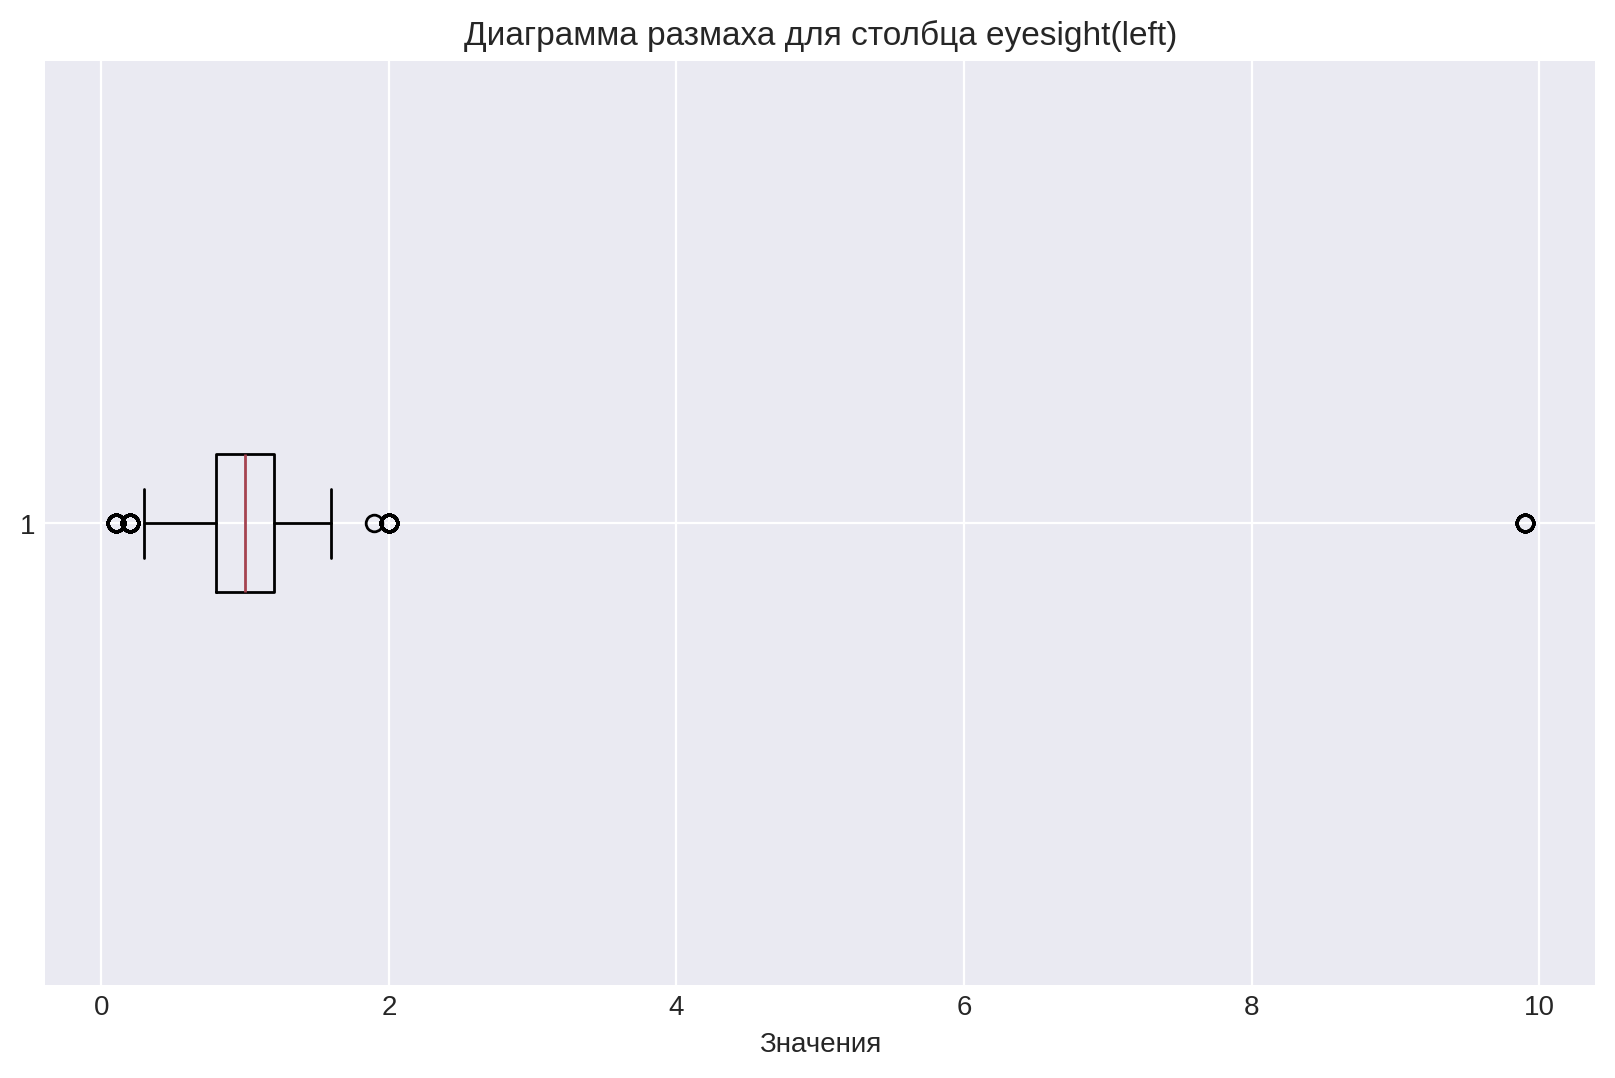

eyesight(right)
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 16
Data type: float64
count    13863.000000
mean         1.053740
std          0.514613
min          0.100000
25%          0.800000
50%          1.000000
75%          1.200000
max          9.900000
Name: eyesight(right), dtype: float64
Частота уникальных значений столбца:
 eyesight(right)
1.2    3422
1.0    3097
1.5    2318
0.9    1248
0.8    1172
0.7     871
0.6     494
0.5     434
0.4     273
0.3     180
2.0     130
0.2     111
0.1      76
9.9      28
1.6       6
1.3       3
Name: count, dtype: int64
Minimum: 0.1
Maximum: 9.9


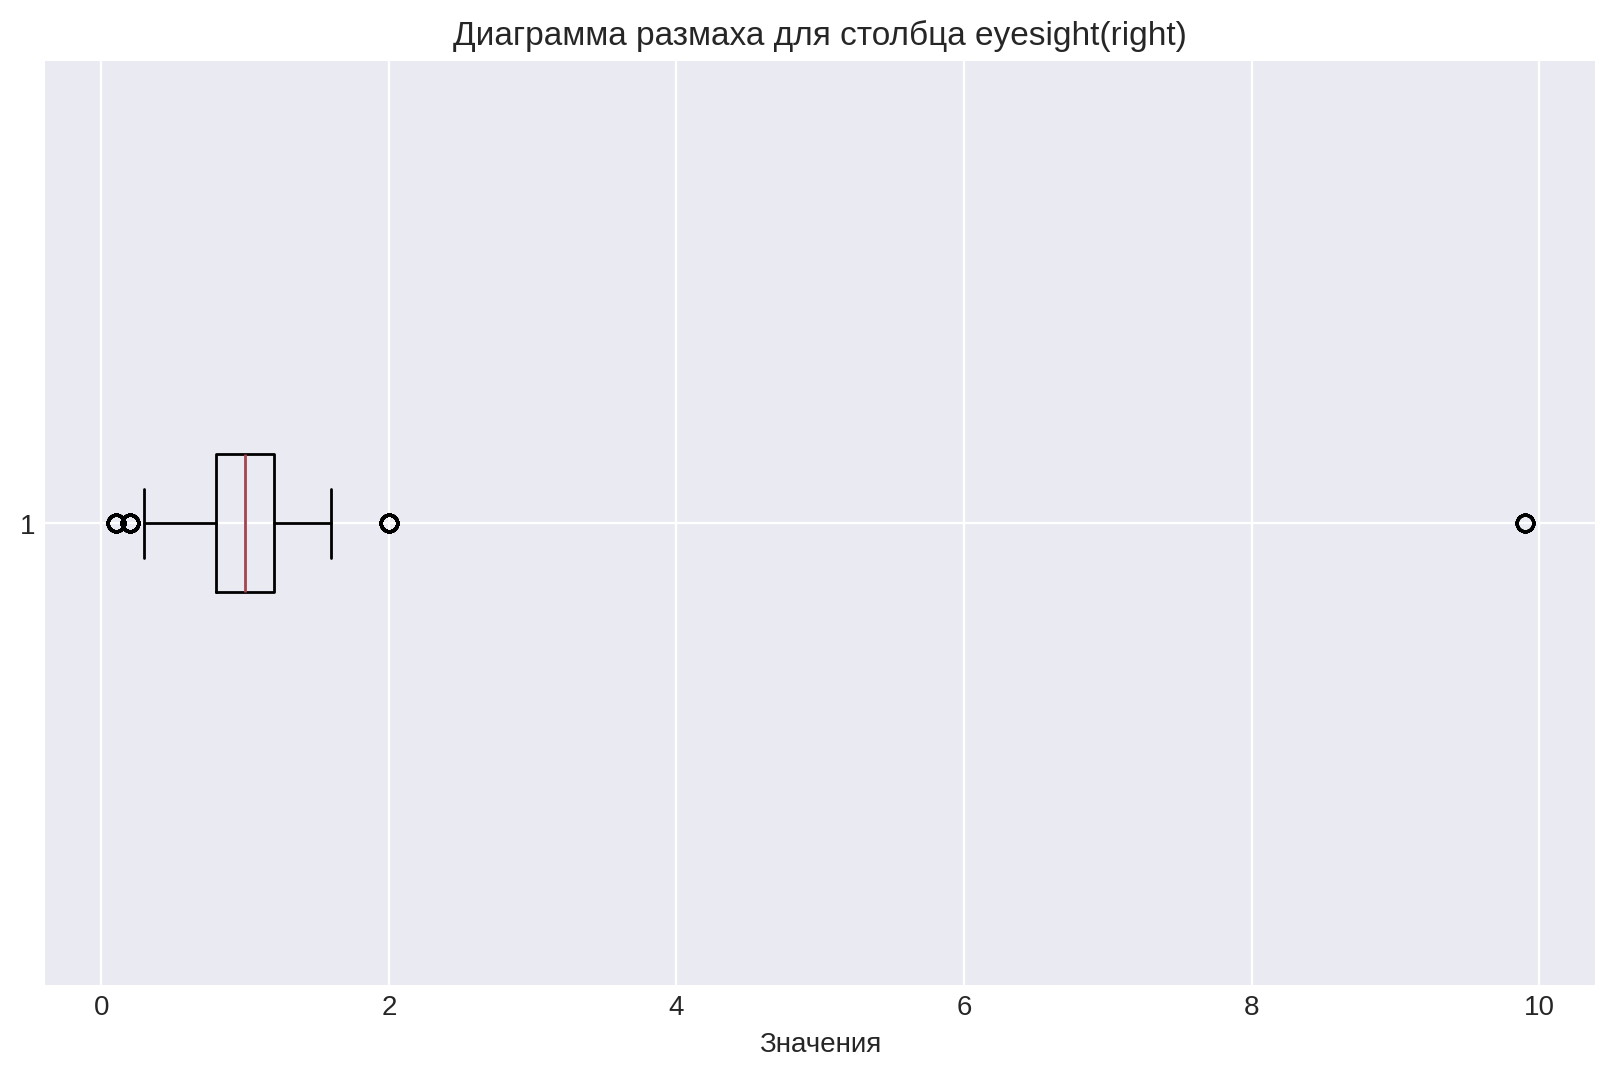

hearing(left)
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 2
Data type: float64
count    13863.000000
mean         1.028060
std          0.165151
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: hearing(left), dtype: float64
Частота уникальных значений столбца:
 hearing(left)
1.0    13474
2.0      389
Name: count, dtype: int64
Minimum: 1.0
Maximum: 2.0


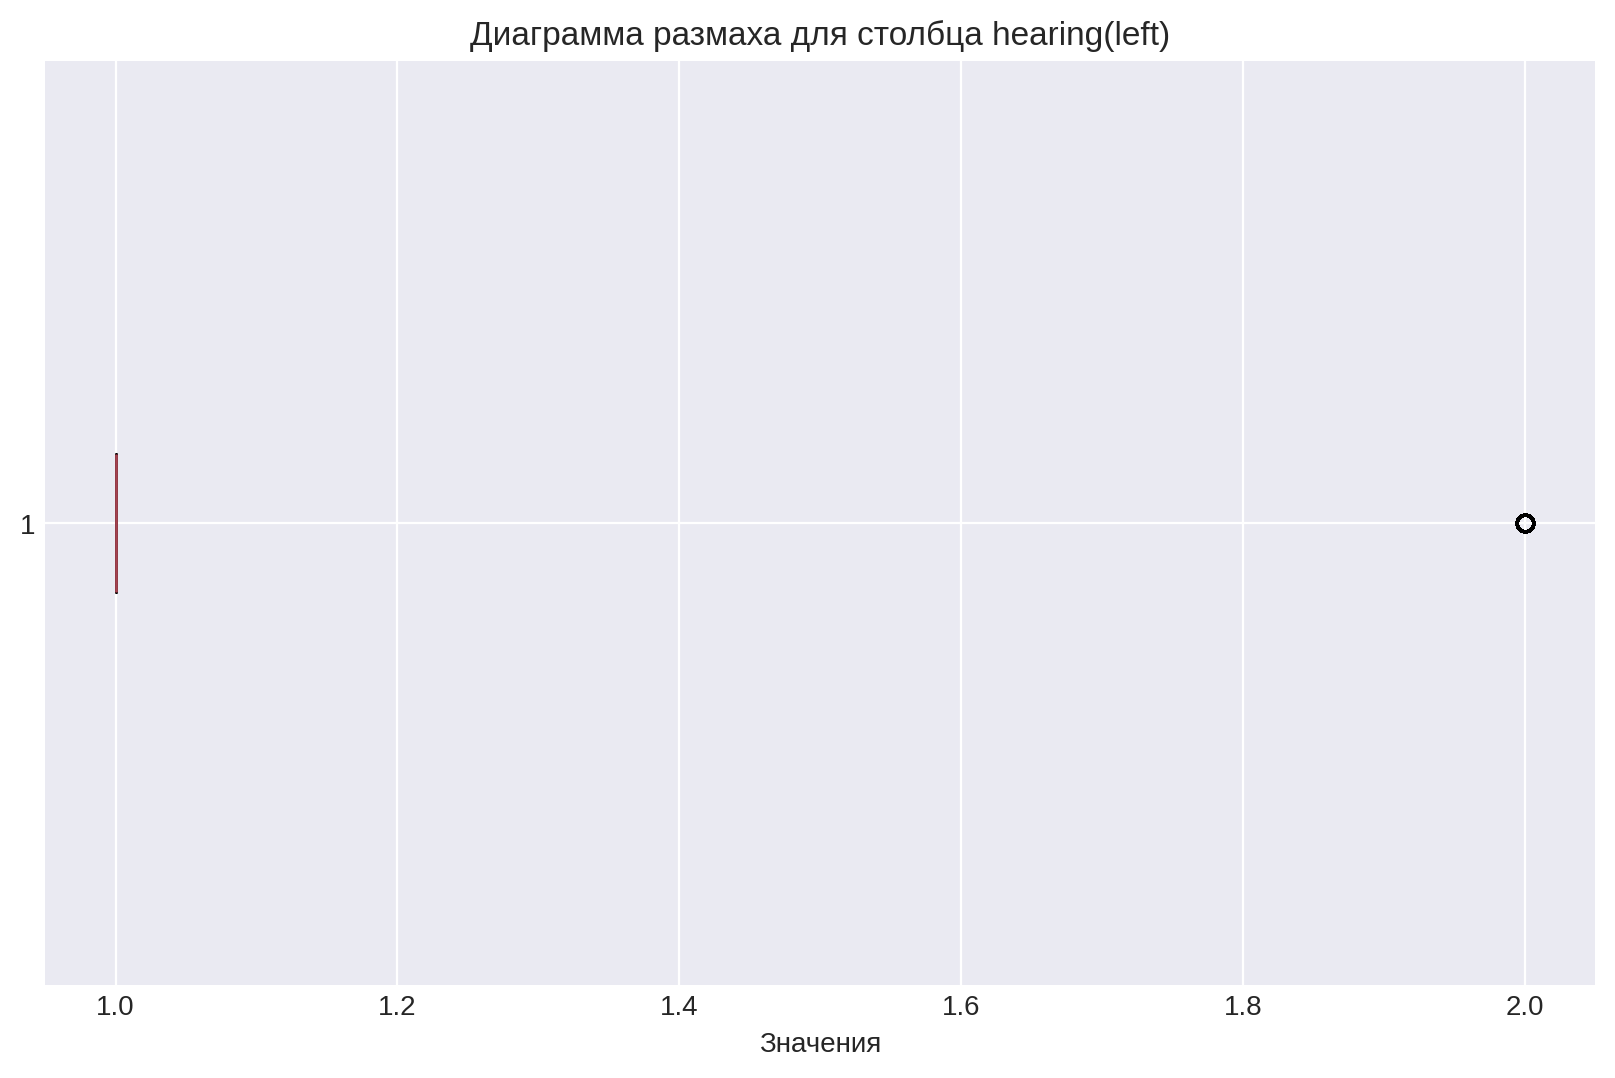

hearing(right)
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 2
Data type: float64
count    13863.000000
mean         1.027411
std          0.163284
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: hearing(right), dtype: float64
Частота уникальных значений столбца:
 hearing(right)
1.0    13483
2.0      380
Name: count, dtype: int64
Minimum: 1.0
Maximum: 2.0


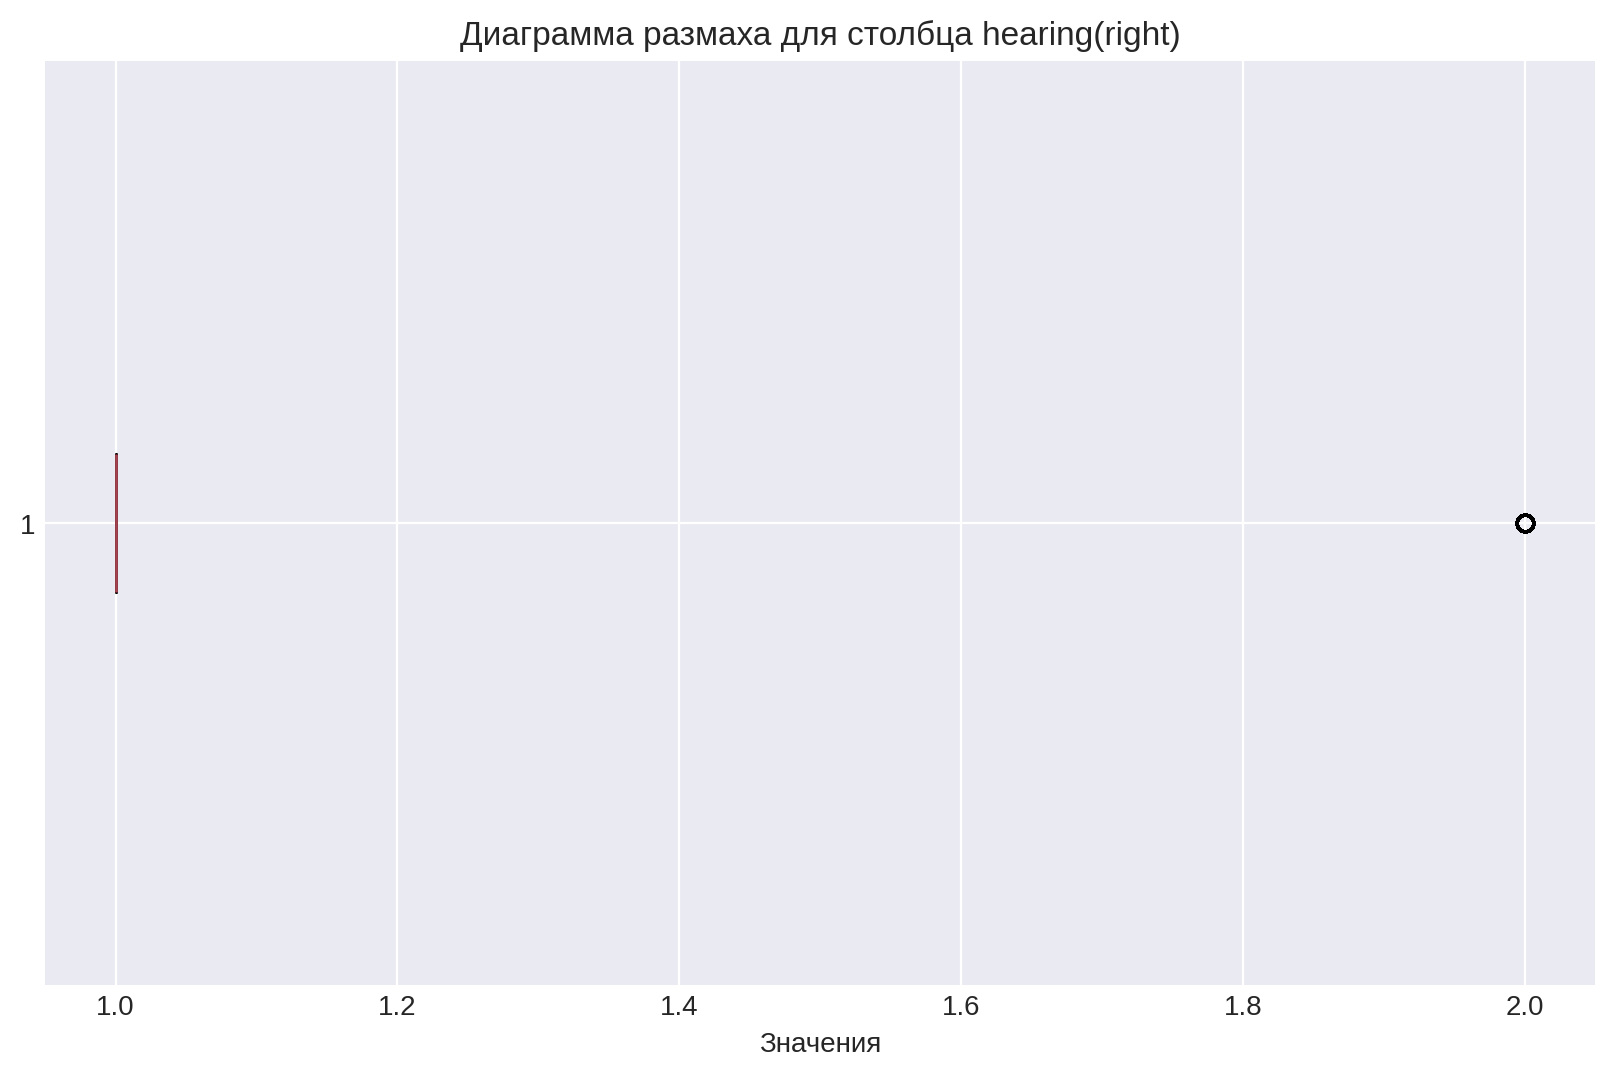

systolic
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 101
Data type: float64
count    13863.000000
mean       123.430643
std         12.964684
min         74.000000
25%        115.000000
50%        122.000000
75%        131.000000
max        240.000000
Name: systolic, dtype: float64
Частота уникальных значений столбца:
 systolic
130.0    947
120.0    912
110.0    881
118.0    816
128.0    469
        ... 
88.0       1
186.0      1
80.0       1
240.0      1
198.0      1
Name: count, Length: 101, dtype: int64
Minimum: 74.0
Maximum: 240.0


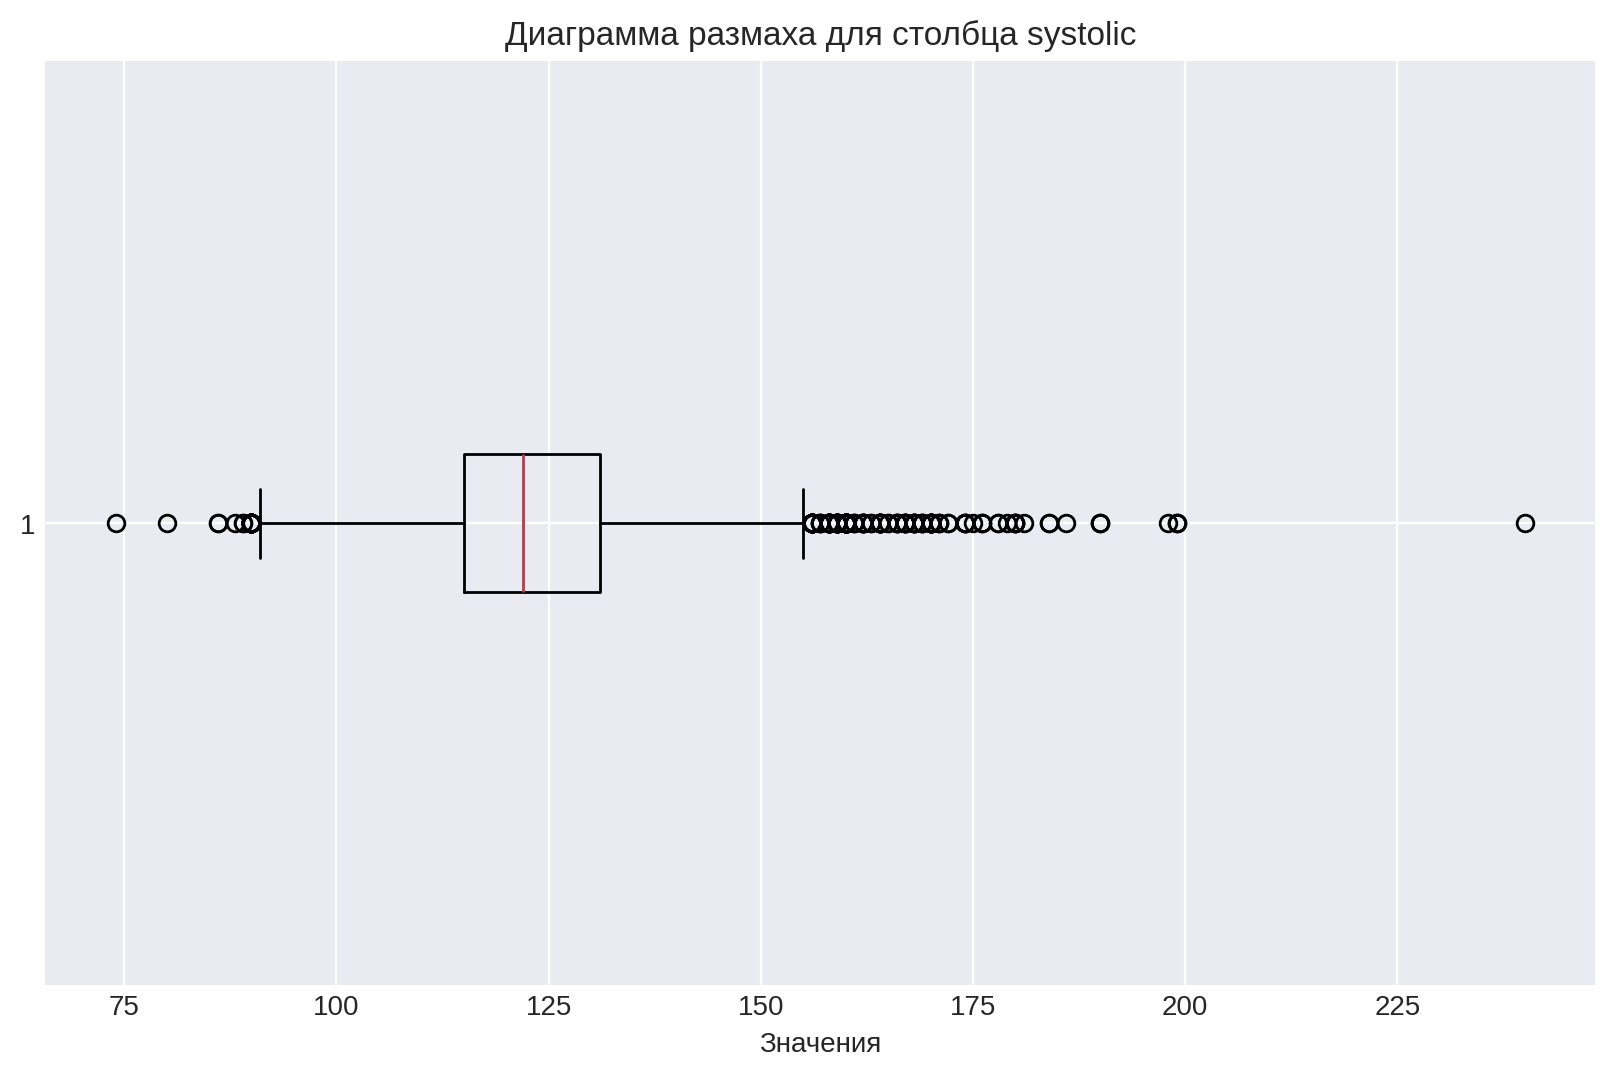

relaxation
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 77
Data type: float64
count    13863.000000
mean        77.166703
std          9.459288
min         40.000000
25%         70.000000
50%         78.000000
75%         83.000000
max        140.000000
Name: relaxation, dtype: float64
Частота уникальных значений столбца:
 relaxation
80.0     1447
70.0     1303
78.0      841
76.0      578
74.0      546
         ... 
123.0       1
48.0        1
117.0       1
140.0       1
46.0        1
Name: count, Length: 77, dtype: int64
Minimum: 40.0
Maximum: 140.0


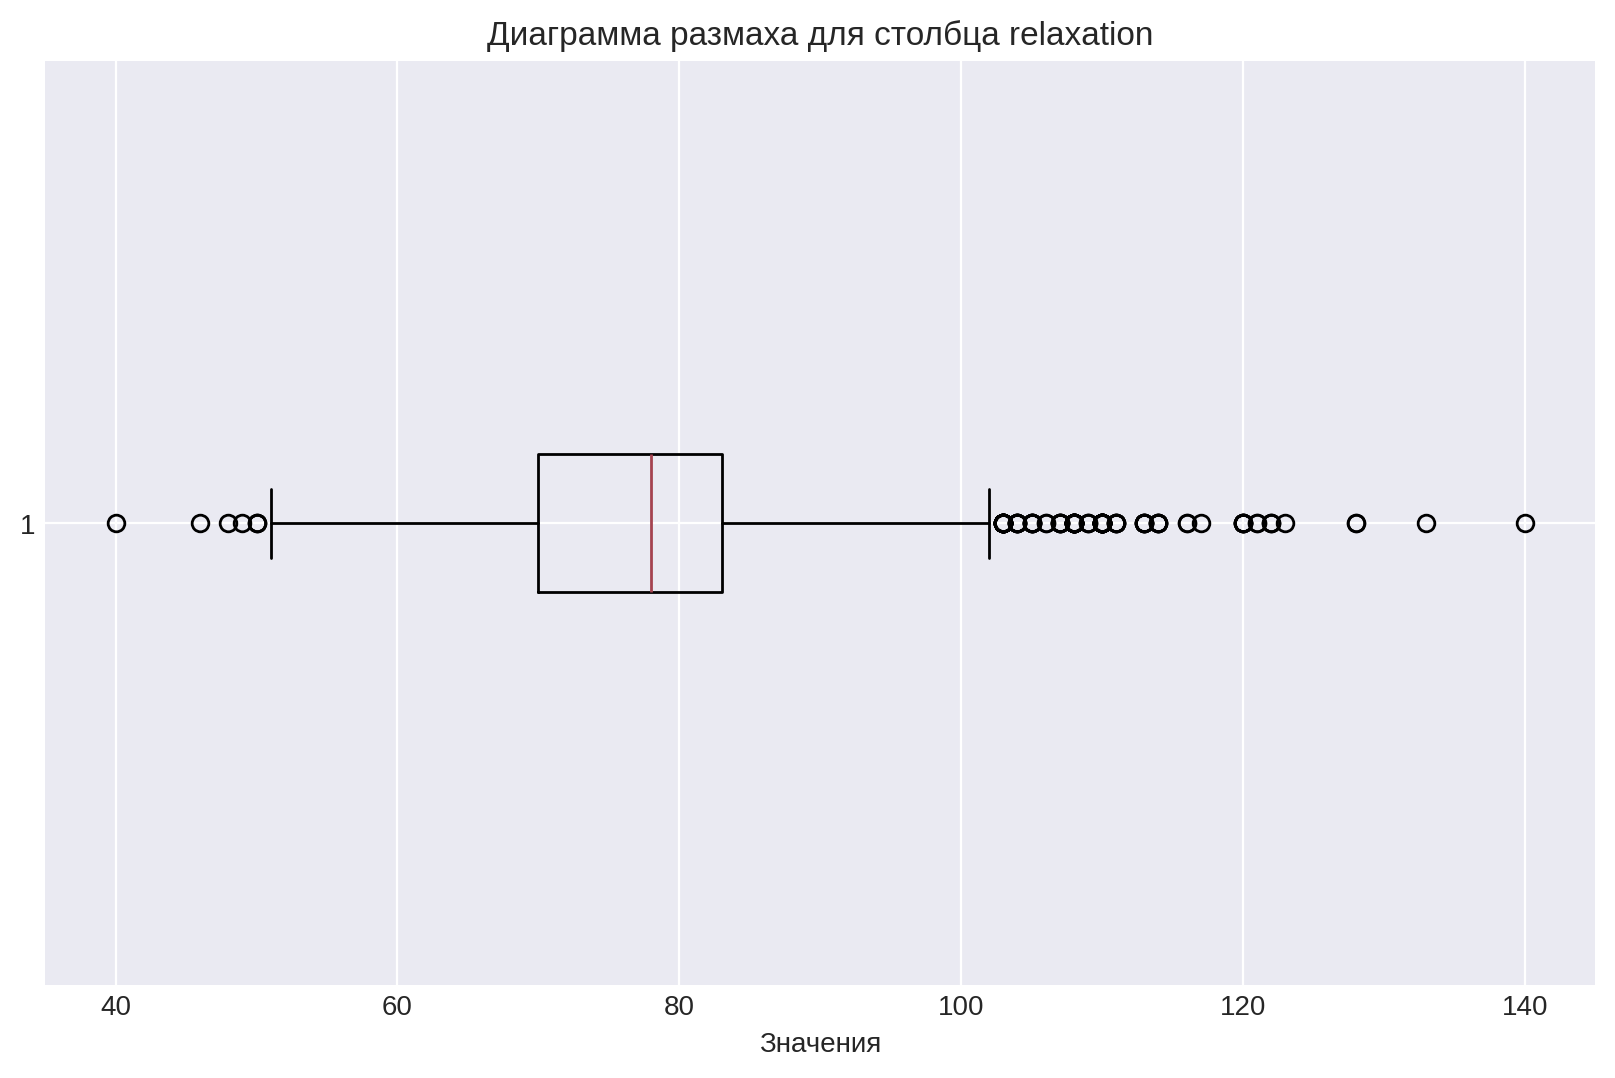

fasting_blood_sugar
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 201
Data type: float64
count    13863.000000
mean        99.937387
std         20.682085
min         48.000000
25%         90.000000
50%         96.000000
75%        104.000000
max        475.000000
Name: fasting_blood_sugar, dtype: float64
Частота уникальных значений столбца:
 fasting_blood_sugar
97.0     588
96.0     567
94.0     555
95.0     541
93.0     540
        ... 
326.0      1
325.0      1
246.0      1
285.0      1
283.0      1
Name: count, Length: 201, dtype: int64
Minimum: 48.0
Maximum: 475.0


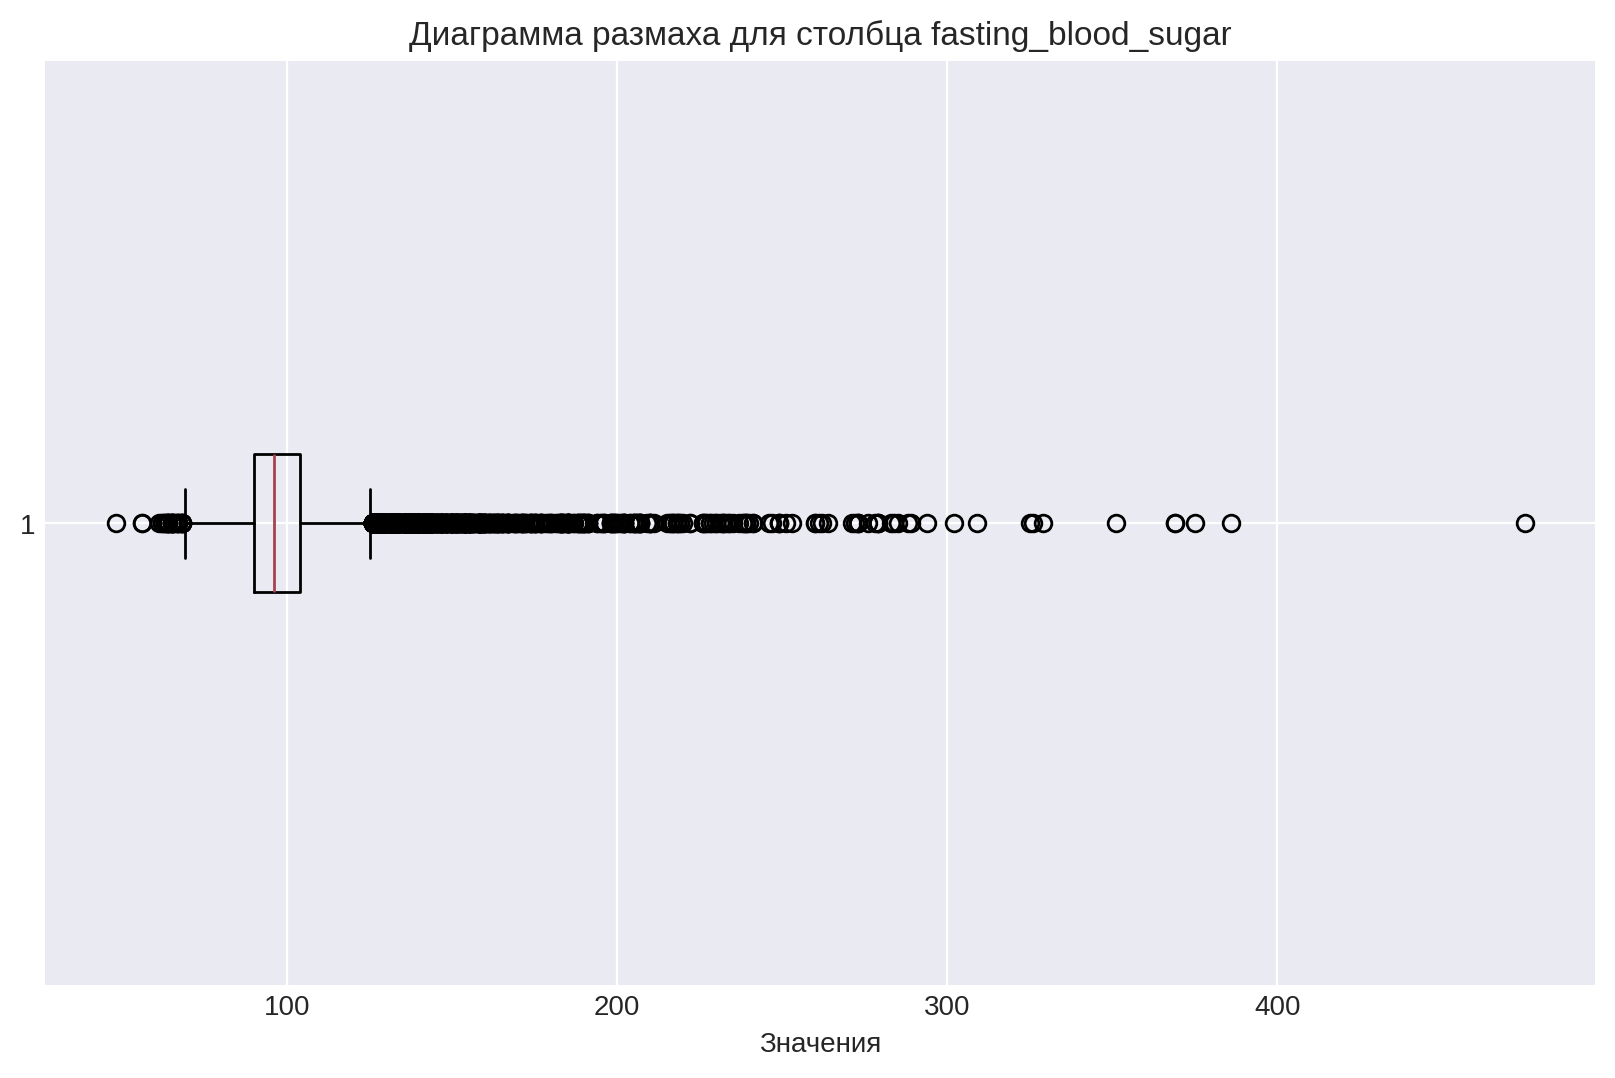

cholesterol
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 241
Data type: float64
count    13863.000000
mean       193.864387
std         35.658783
min         84.000000
25%        169.000000
50%        192.000000
75%        216.000000
max        441.000000
Name: cholesterol, dtype: float64
Частота уникальных значений столбца:
 cholesterol
193.0    186
199.0    179
176.0    174
190.0    172
192.0    171
        ... 
90.0       1
319.0      1
101.0      1
303.0      1
311.0      1
Name: count, Length: 241, dtype: int64
Minimum: 84.0
Maximum: 441.0


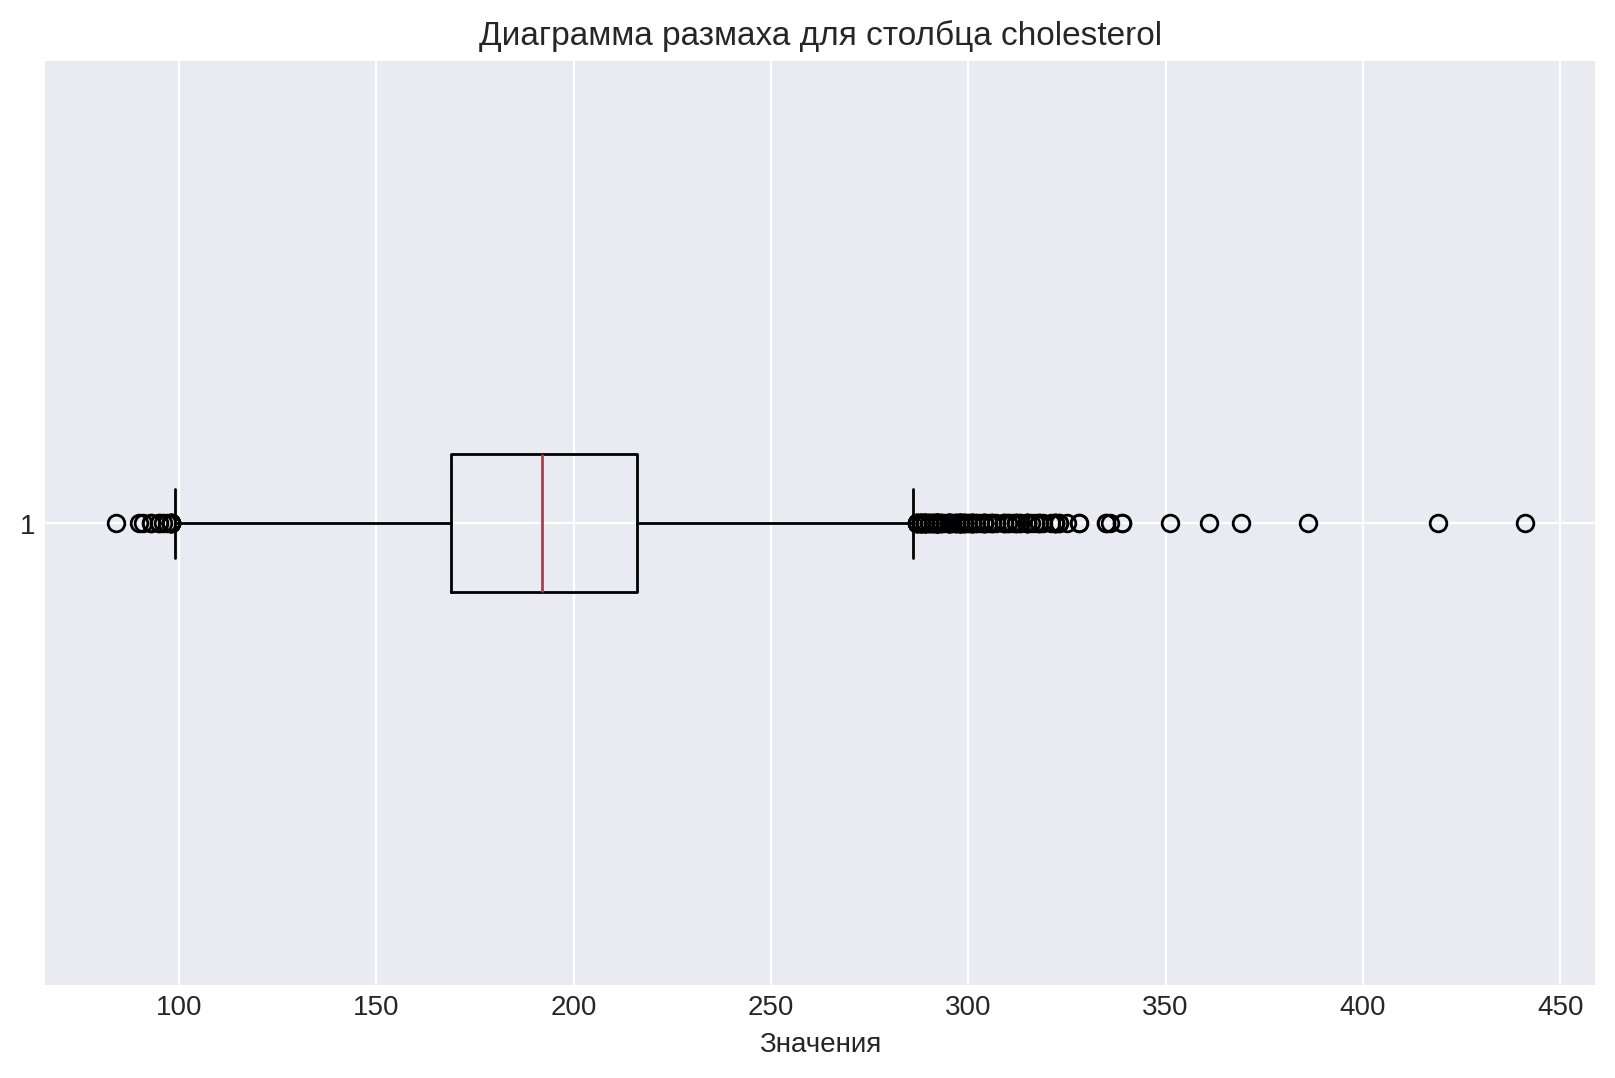

triglyceride
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 380
Data type: float64
count    13863.000000
mean       130.917767
std         71.348298
min         16.000000
25%         78.000000
50%        113.000000
75%        166.000000
max        466.000000
Name: triglyceride, dtype: float64
Частота уникальных значений столбца:
 triglyceride
82.0     130
79.0     126
74.0     124
71.0     122
101.0    116
        ... 
405.0      1
466.0      1
373.0      1
381.0      1
369.0      1
Name: count, Length: 380, dtype: int64
Minimum: 16.0
Maximum: 466.0


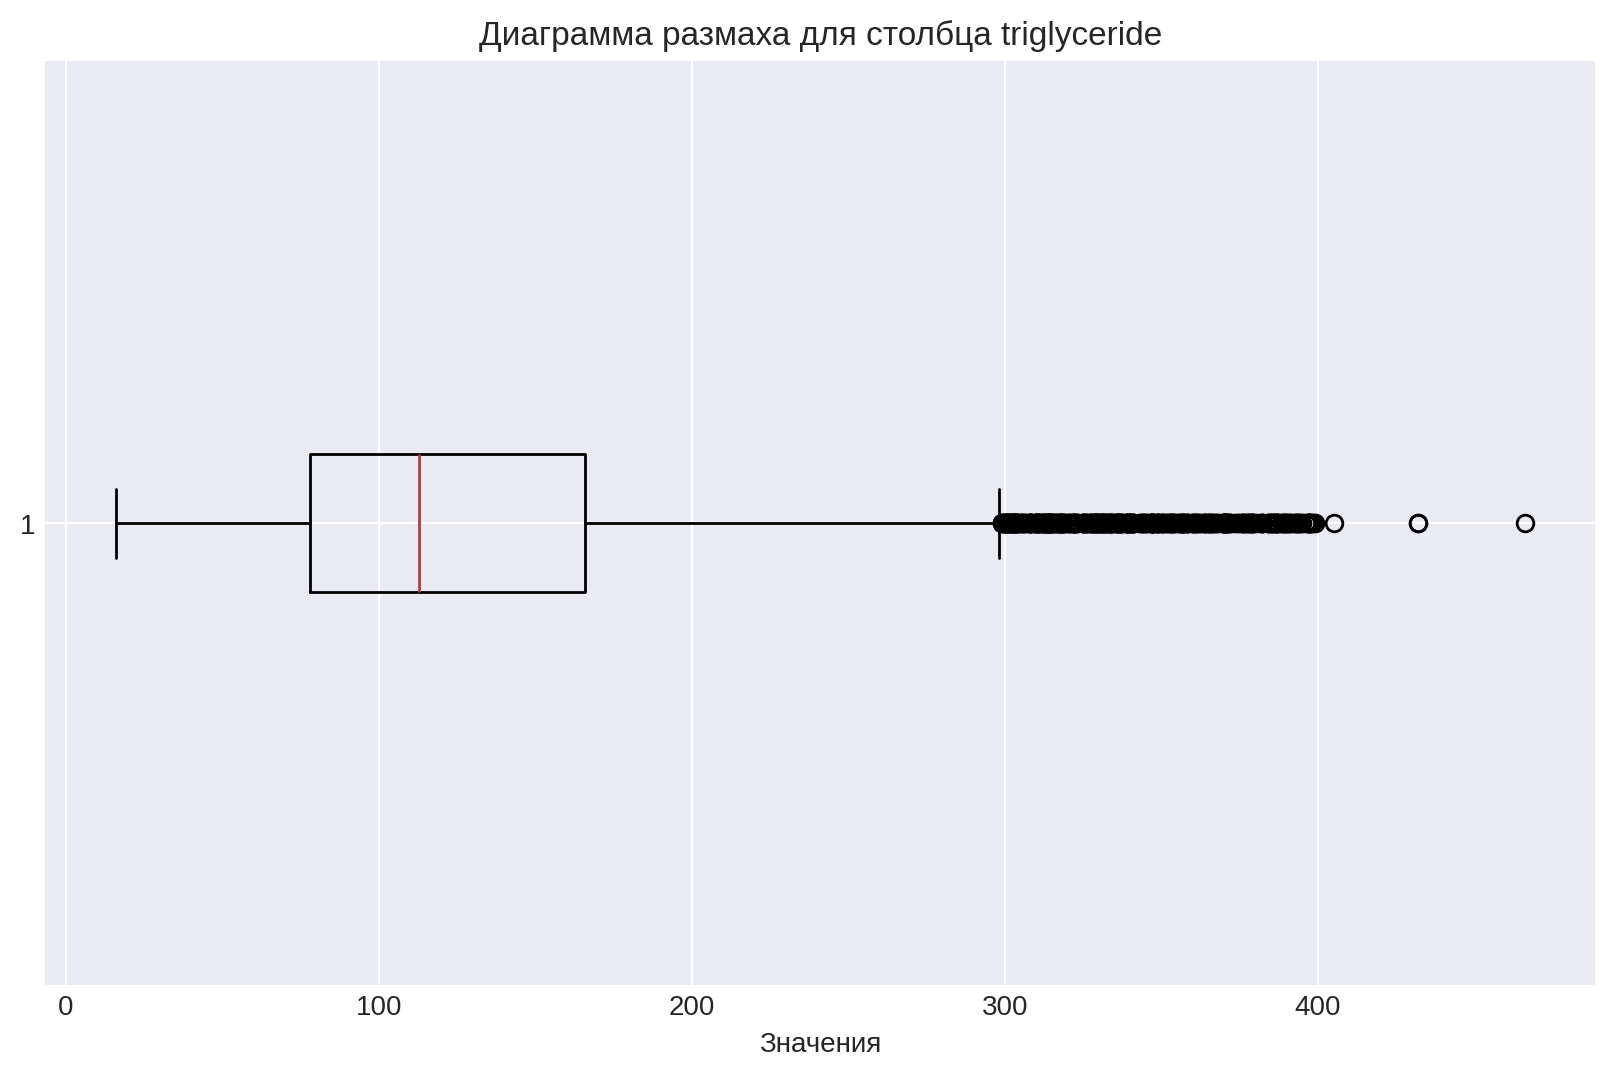

hdl
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 105
Data type: float64
count    13863.000000
mean        54.204357
std         13.168432
min          4.000000
25%         45.000000
50%         53.000000
75%         61.000000
max        359.000000
Name: hdl, dtype: float64
Частота уникальных значений столбца:
 hdl
46.0     519
47.0     498
53.0     472
49.0     466
45.0     463
        ... 
128.0      1
121.0      1
131.0      1
117.0      1
116.0      1
Name: count, Length: 105, dtype: int64
Minimum: 4.0
Maximum: 359.0


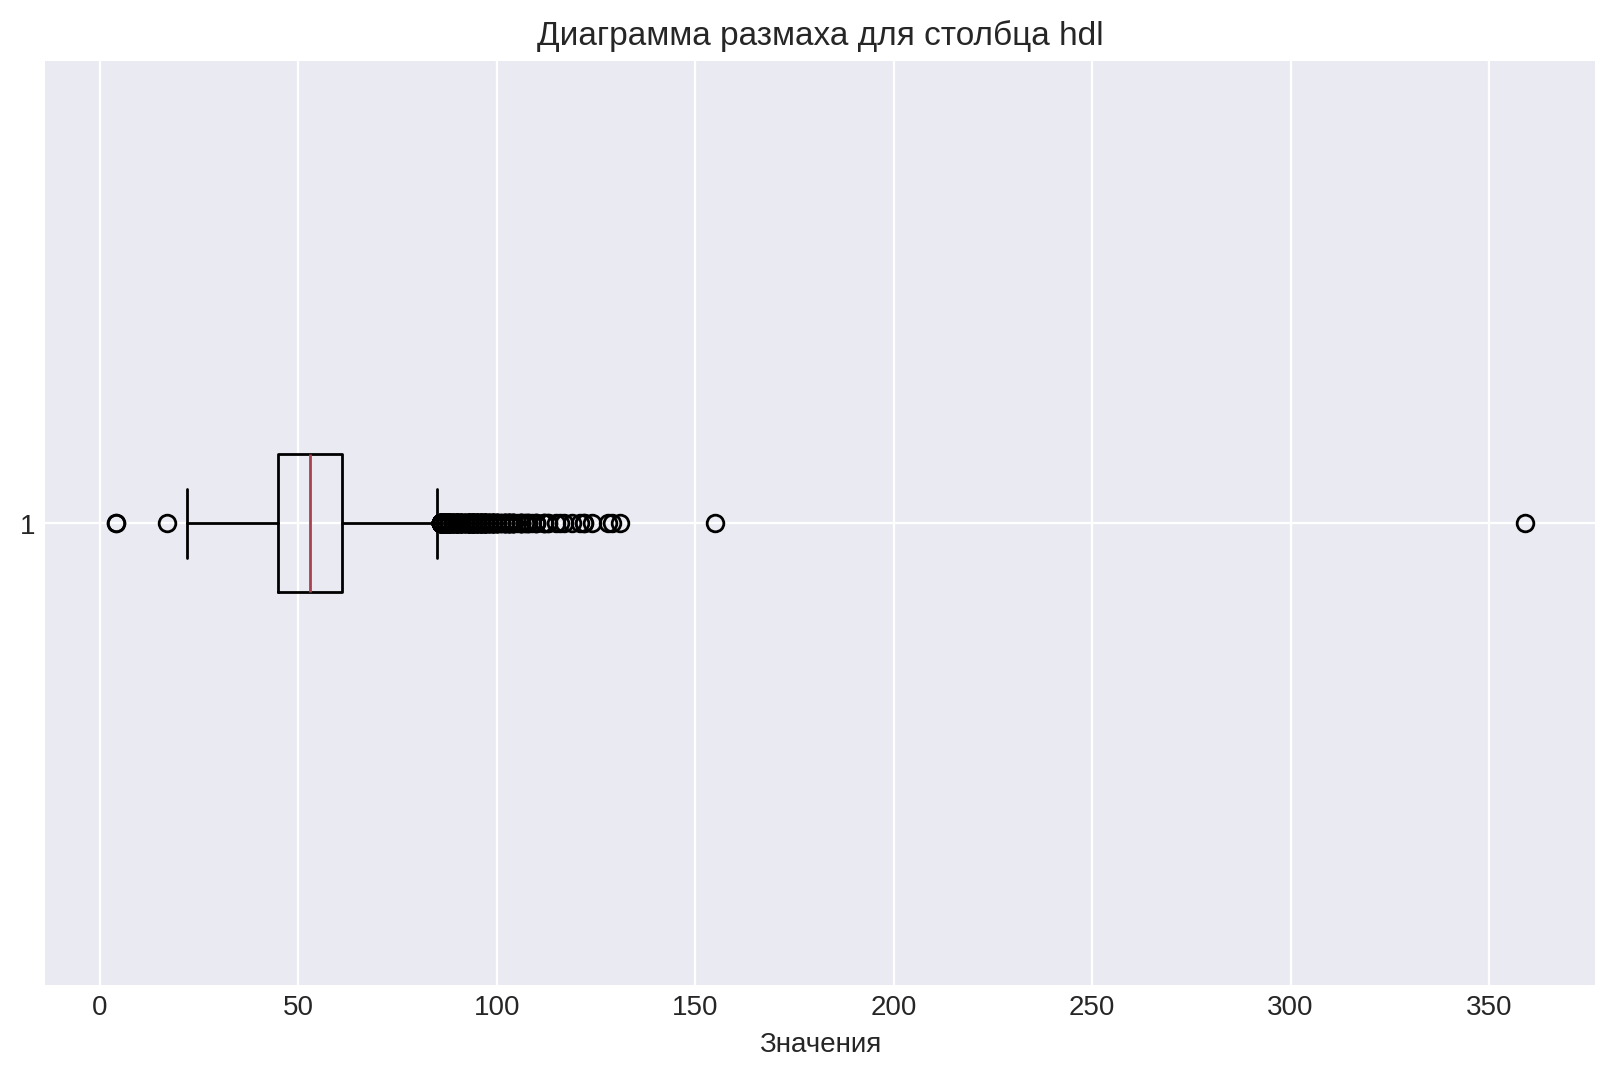

ldl
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 233
Data type: float64
count    13863.000000
mean       114.435476
std         42.050428
min          7.000000
25%         91.000000
50%        113.000000
75%        135.000000
max       1340.000000
Name: ldl, dtype: float64
Частота уникальных значений столбца:
 ldl
112.0     192
104.0     187
96.0      186
106.0     185
121.0     182
         ... 
250.0       1
311.0       1
1070.0      1
251.0       1
15.0        1
Name: count, Length: 233, dtype: int64
Minimum: 7.0
Maximum: 1340.0


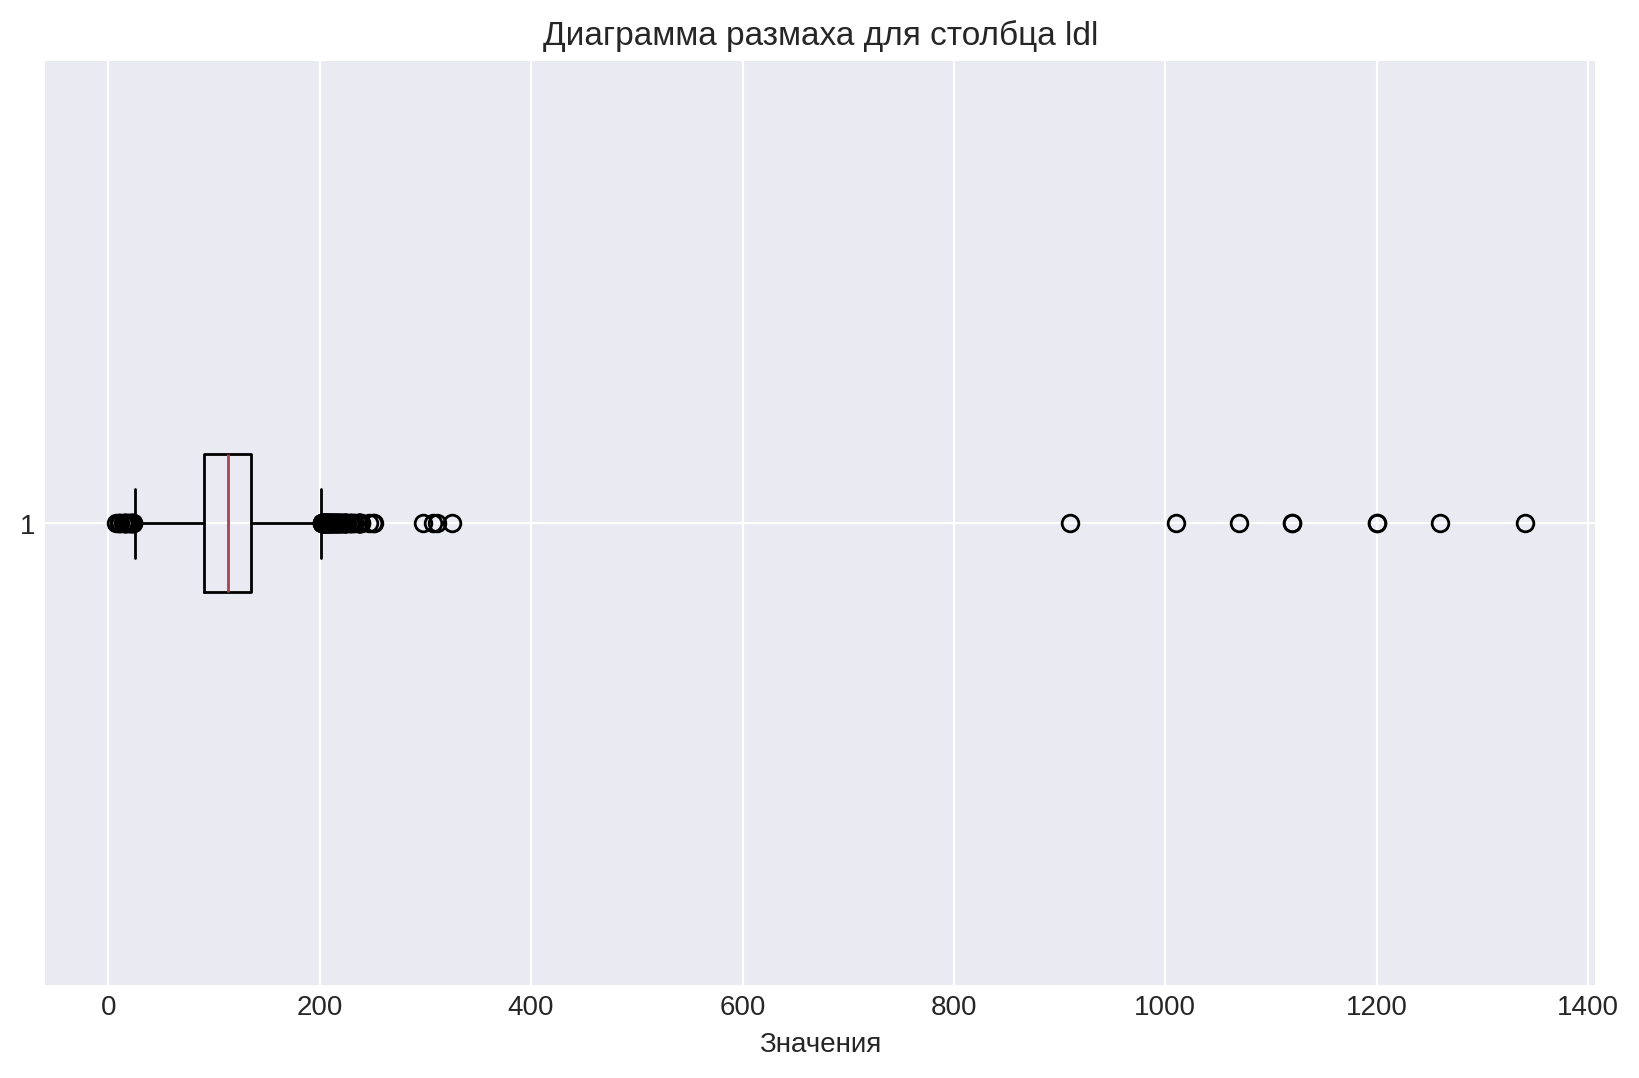

hemoglobin
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 103
Data type: float64
count    13863.000000
mean        15.402200
std          1.052598
min          6.300000
25%         14.800000
50%         15.400000
75%         16.100000
max         19.600000
Name: hemoglobin, dtype: float64
Частота уникальных значений столбца:
 hemoglobin
15.4    597
15.7    585
15.3    552
15.6    551
15.5    545
       ... 
10.7      1
19.4      1
10.0      1
11.2      1
7.1       1
Name: count, Length: 103, dtype: int64
Minimum: 6.3
Maximum: 19.6


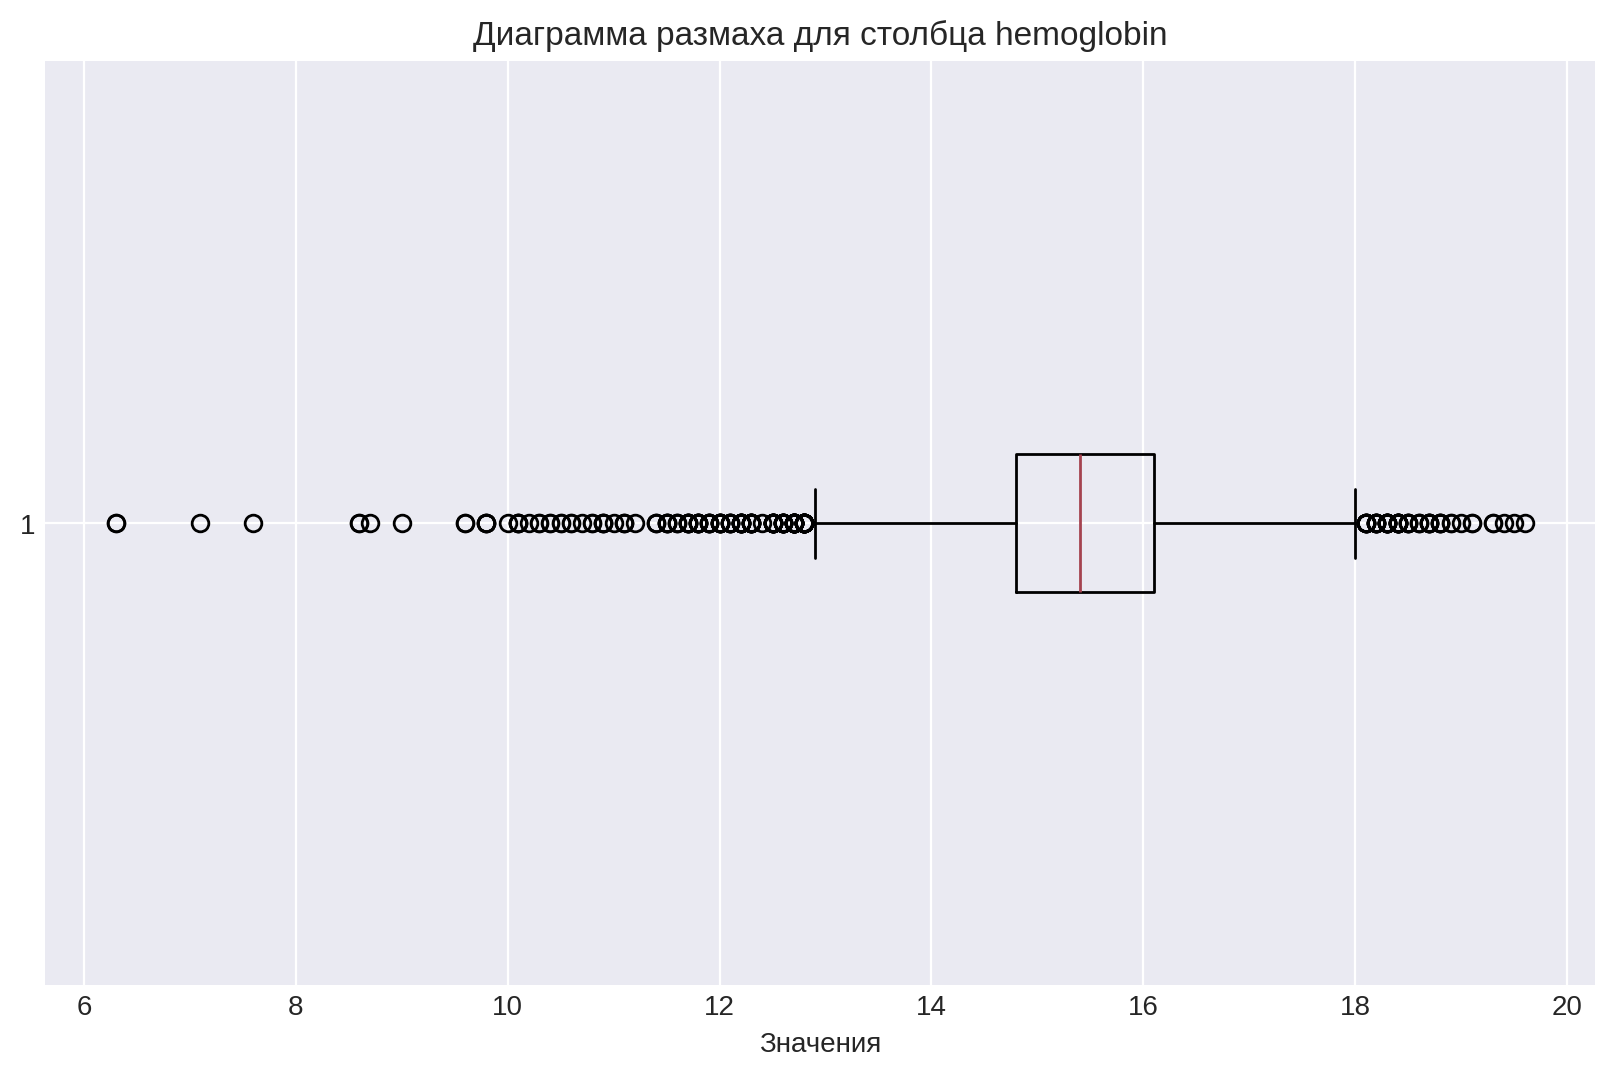

urine_protein
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 6
Data type: float64
count    13863.000000
mean         1.093775
std          0.421272
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: urine_protein, dtype: float64
Частота уникальных значений столбца:
 urine_protein
1.0    13027
2.0      514
3.0      214
4.0       75
5.0       32
6.0        1
Name: count, dtype: int64
Minimum: 1.0
Maximum: 6.0


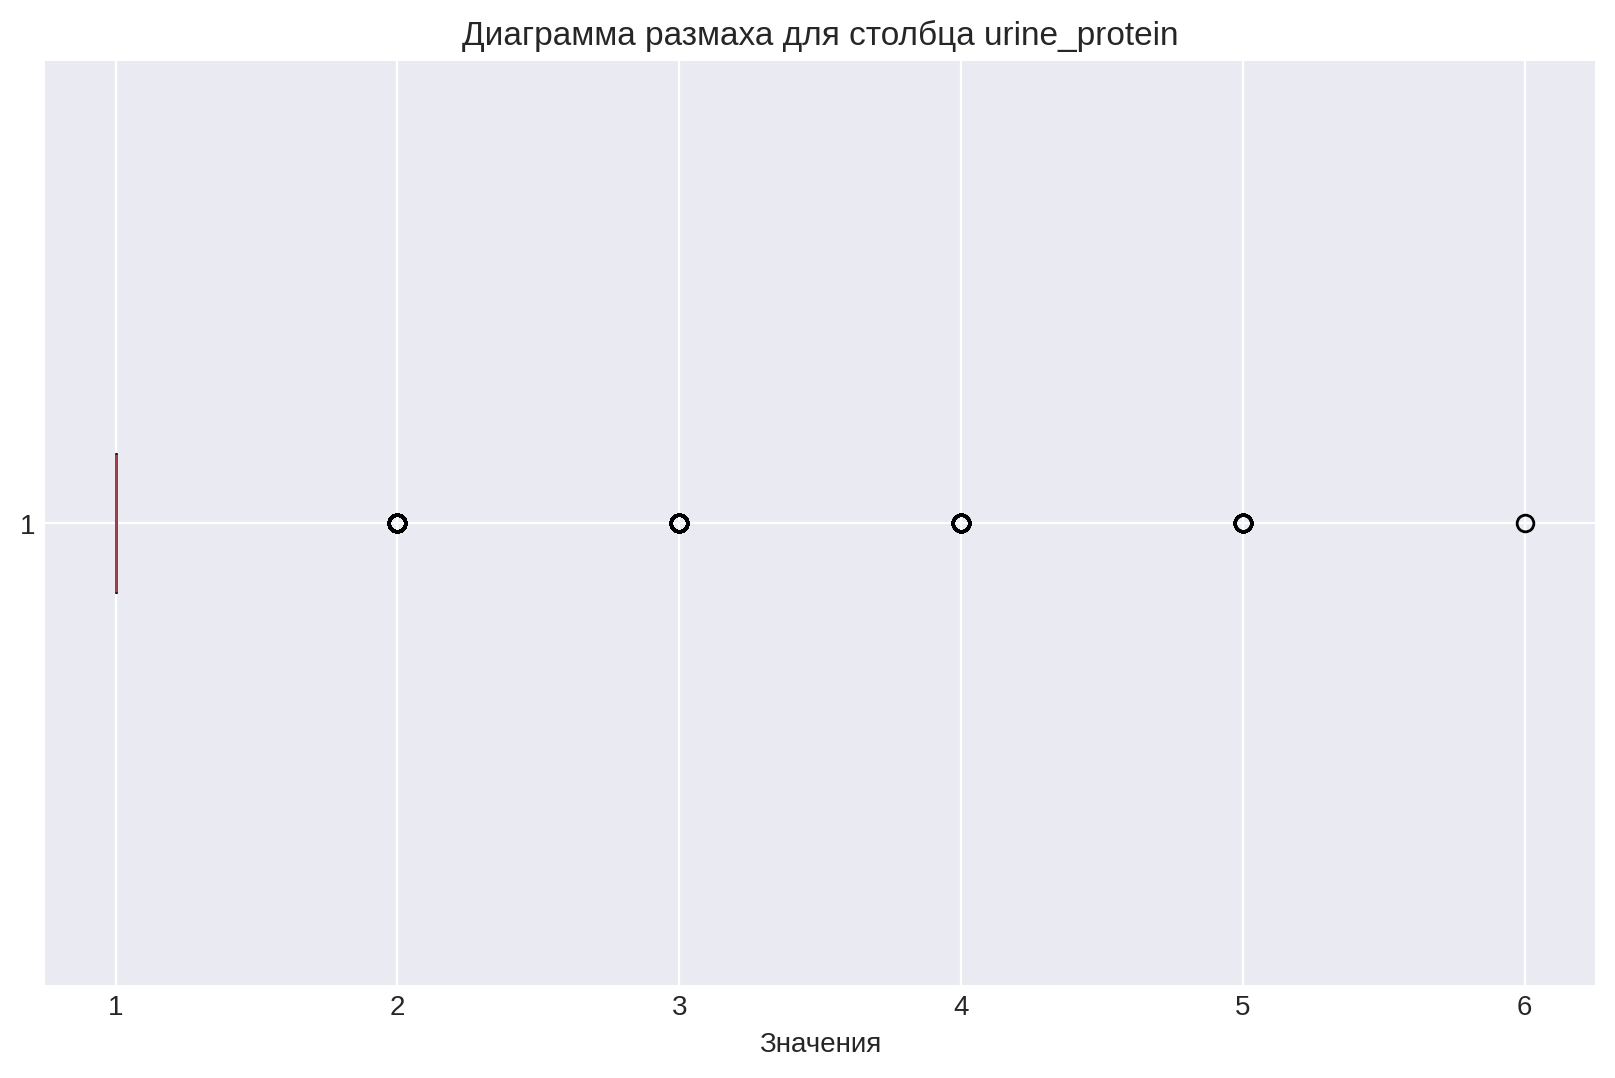

serum_creatinine
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 30
Data type: float64
count    13863.000000
mean         0.981808
std          0.240337
min          0.100000
25%          0.900000
50%          1.000000
75%          1.100000
max         10.000000
Name: serum_creatinine, dtype: float64
Частота уникальных значений столбца:
 serum_creatinine
1.0     3544
0.9     3279
1.1     2340
0.8     1940
1.2     1239
0.7      708
1.3      374
0.6      165
1.4      130
1.5       53
0.5       27
1.6       14
1.7       10
0.1        9
1.8        5
2.1        3
2.0        3
1.9        3
2.2        2
7.4        2
10.0       2
2.5        2
0.3        2
3.4        1
0.2        1
2.6        1
6.4        1
9.9        1
5.0        1
7.5        1
Name: count, dtype: int64
Minimum: 0.1
Maximum: 10.0


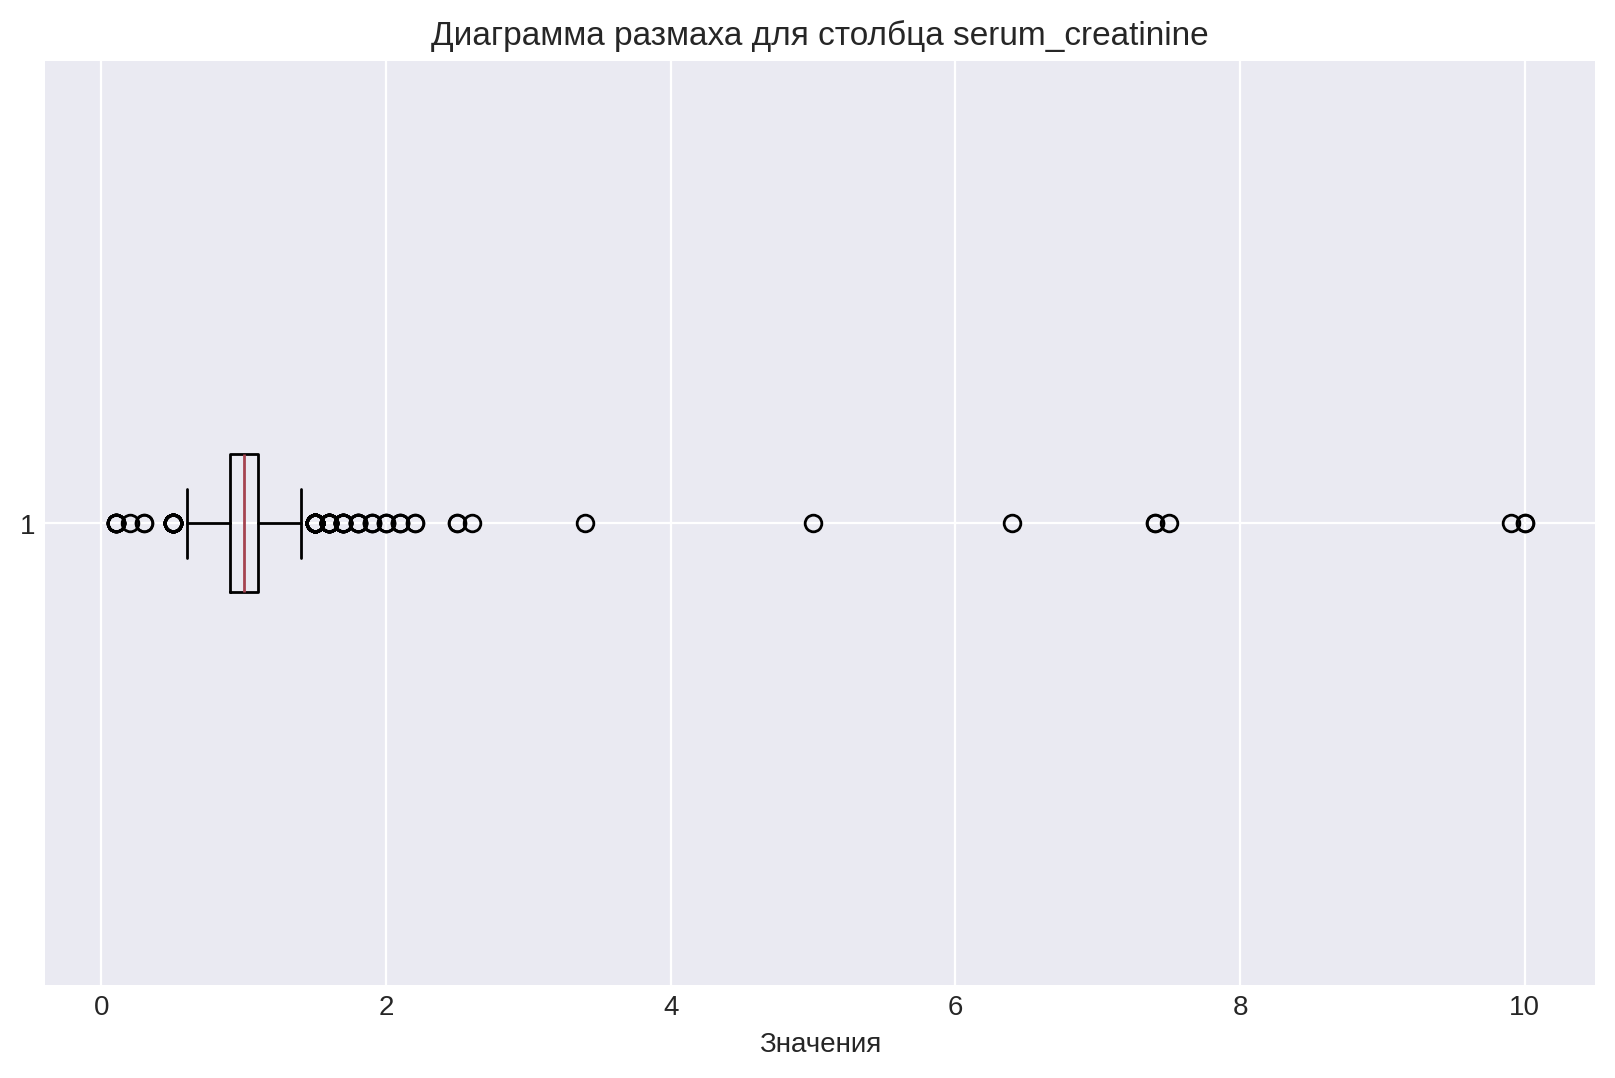

ast
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 151
Data type: float64
count    13863.000000
mean        27.597562
std         21.559820
min          7.000000
25%         20.000000
50%         24.000000
75%         30.000000
max        981.000000
Name: ast, dtype: float64
Частота уникальных значений столбца:
 ast
22.0     875
20.0     868
21.0     850
23.0     849
24.0     805
        ... 
92.0       1
324.0      1
320.0      1
341.0      1
189.0      1
Name: count, Length: 151, dtype: int64
Minimum: 7.0
Maximum: 981.0


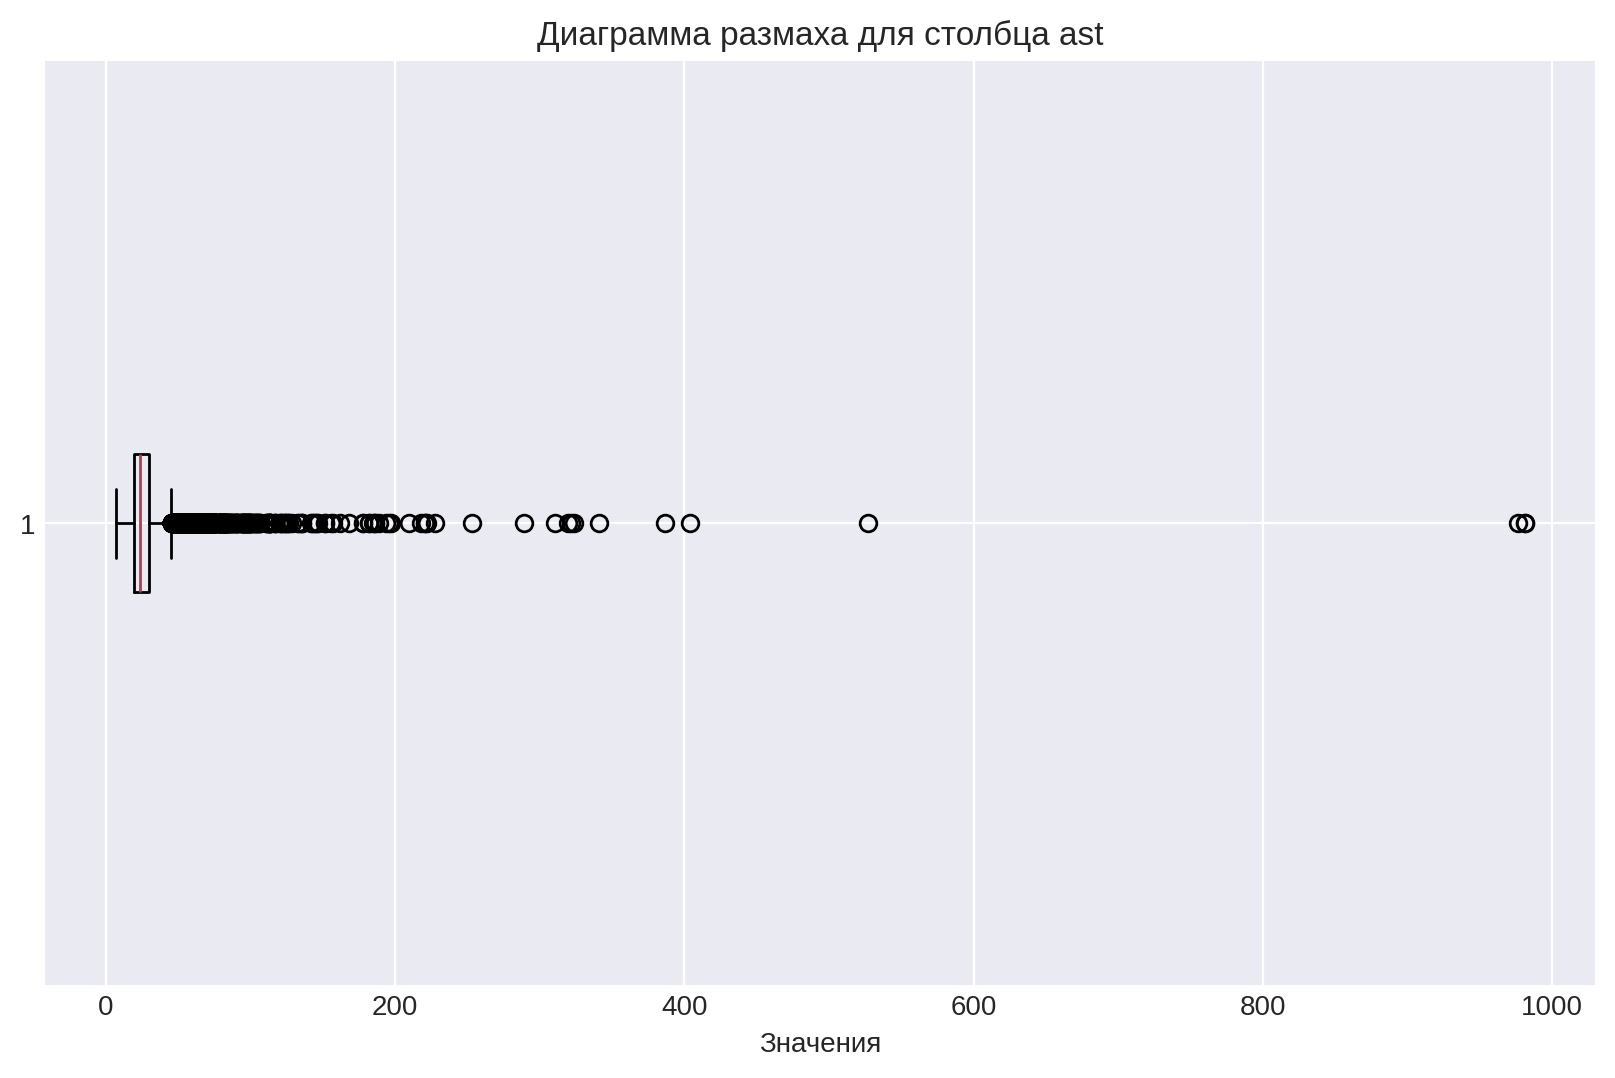

alt
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 192
Data type: float64
count    13863.000000
mean        30.772921
std         36.441688
min          2.000000
25%         18.000000
50%         24.000000
75%         35.000000
max       2914.000000
Name: alt, dtype: float64
Частота уникальных значений столбца:
 alt
17.0      624
18.0      603
19.0      592
20.0      575
16.0      561
         ... 
133.0       1
2914.0      1
183.0       1
327.0       1
113.0       1
Name: count, Length: 192, dtype: int64
Minimum: 2.0
Maximum: 2914.0


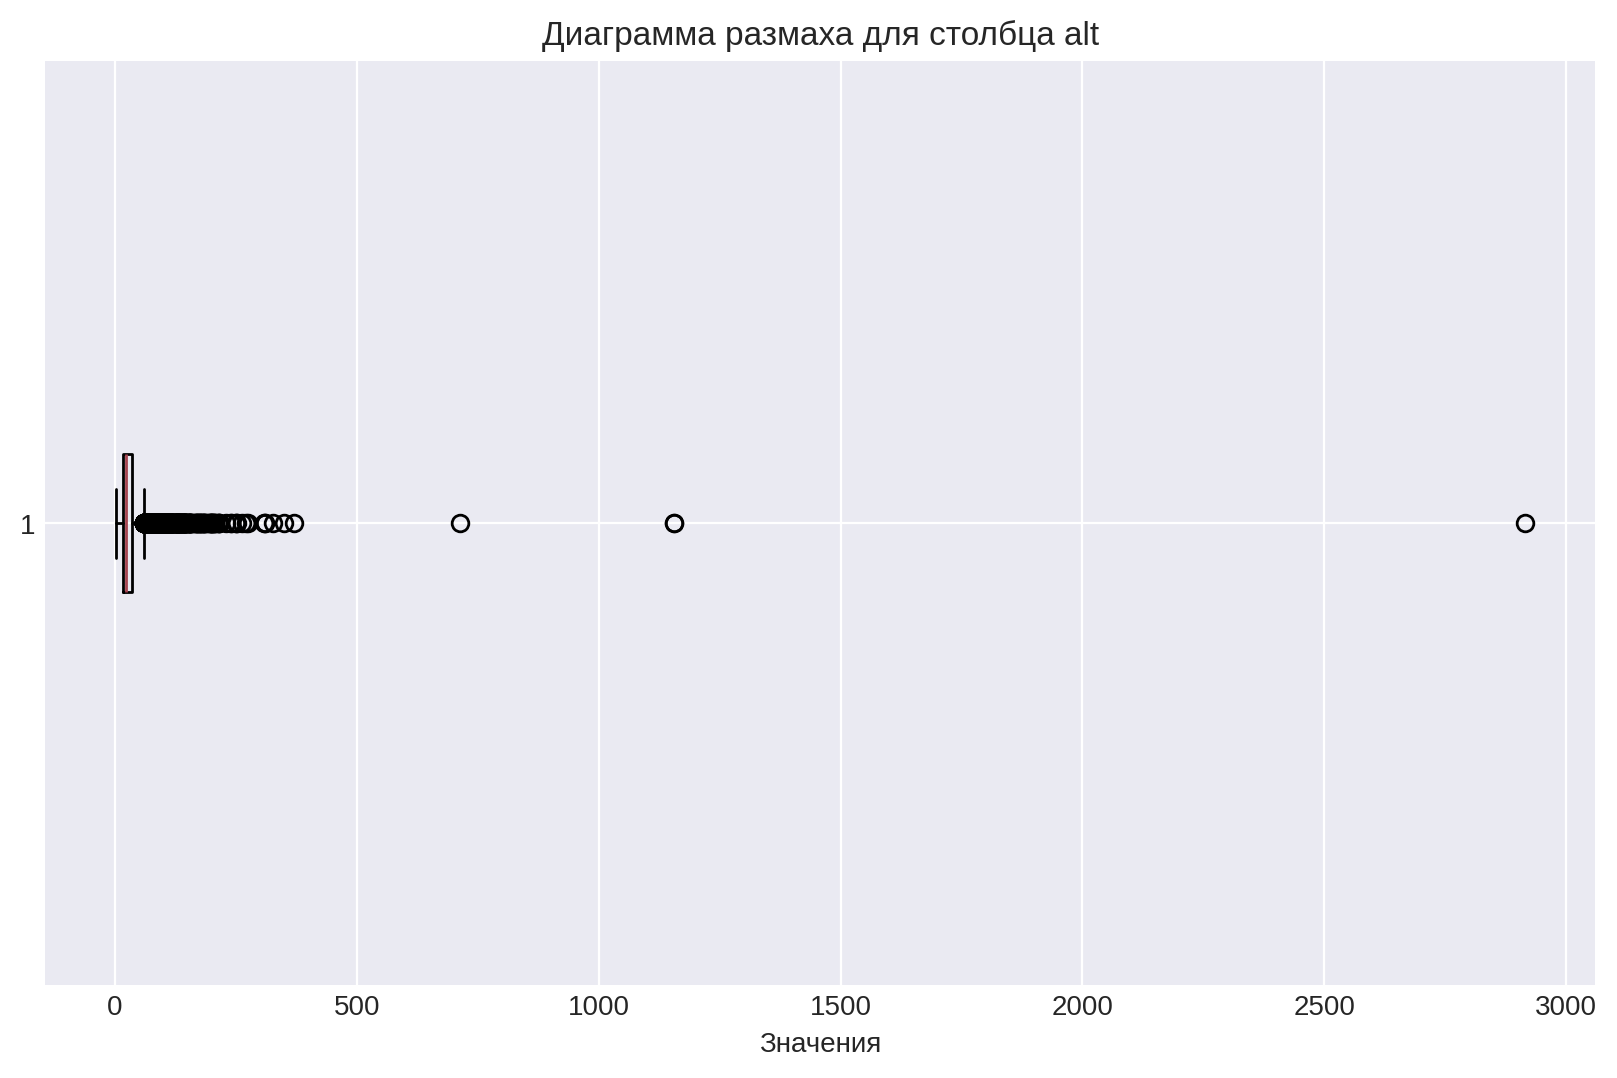

gtp
Кол-во Null и Na значений: 0
Кол-во уникальных значений: 336
Data type: float64
count    13863.000000
mean        43.442978
std         50.342097
min          2.000000
25%         20.000000
50%         29.000000
75%         48.000000
max        999.000000
Name: gtp, dtype: float64
Частота уникальных значений столбца:
 gtp
18.0     499
19.0     465
20.0     456
22.0     452
21.0     443
        ... 
497.0      1
181.0      1
397.0      1
275.0      1
766.0      1
Name: count, Length: 336, dtype: int64
Minimum: 2.0
Maximum: 999.0


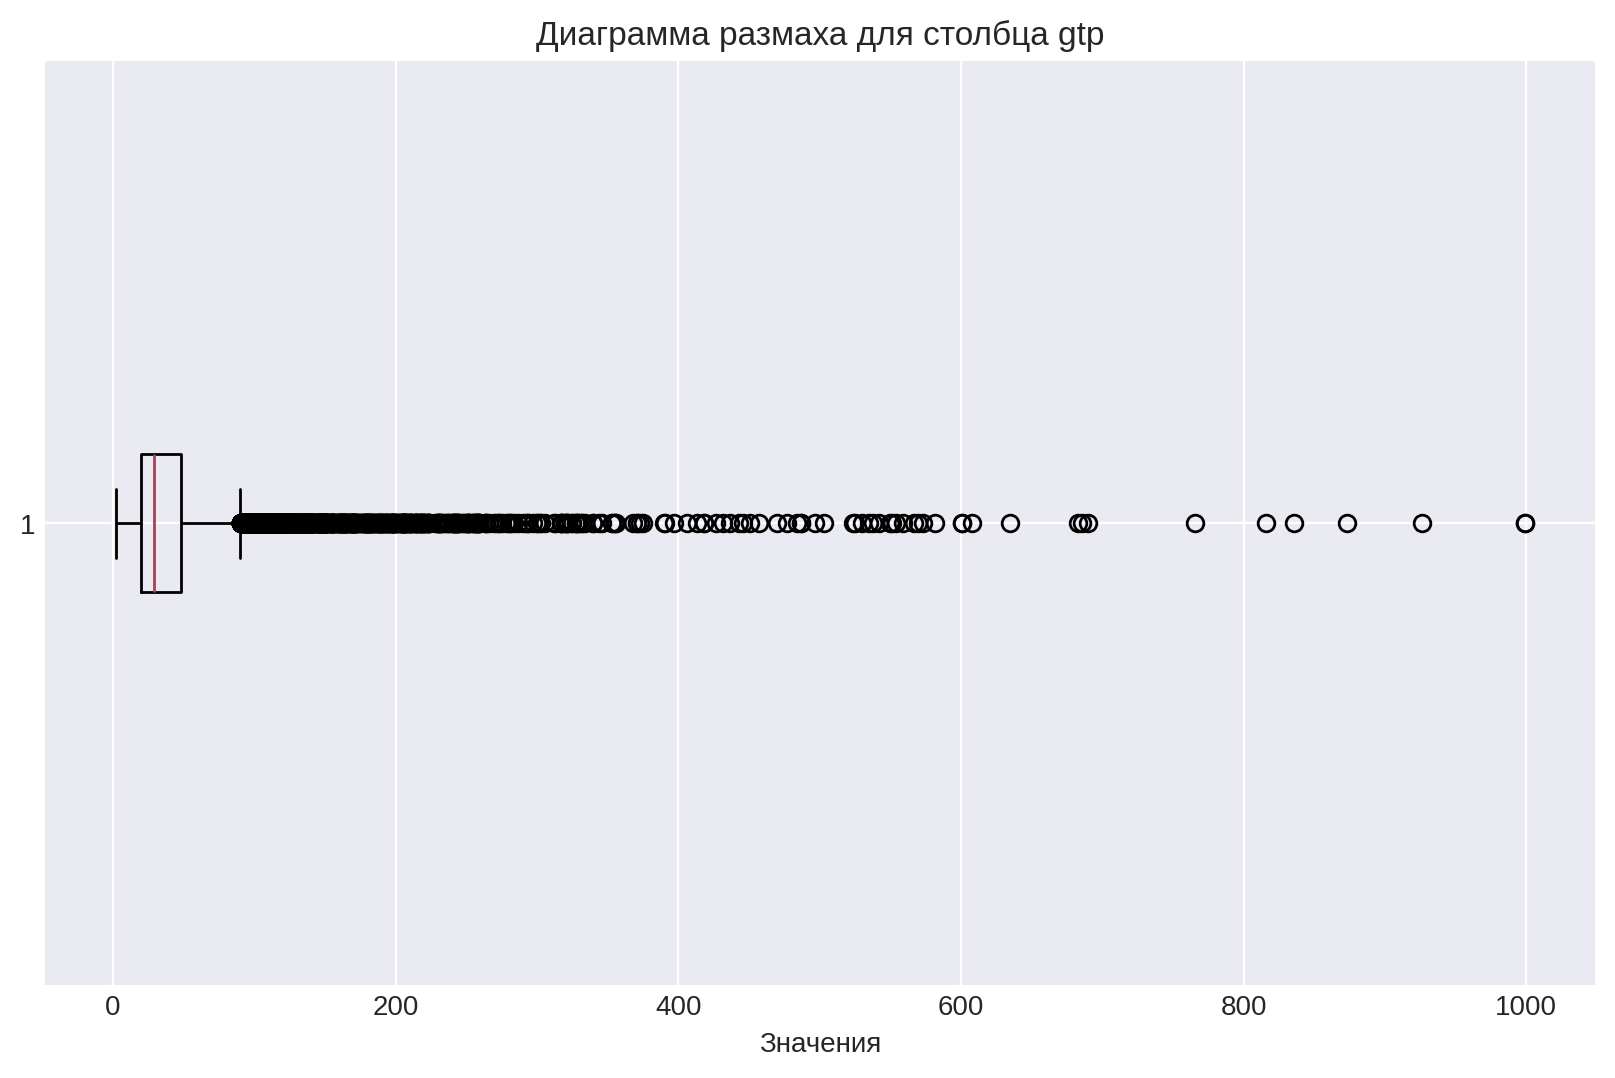

In [50]:
for col in med_features:
    investigate_column(train[col])

Выбросы присутствуют, нельзя однозначно сказать, качественные это данные или ошибочные, так как индивидуальные медицинские показатели могут очень разниться от одного человека к другому. Так как наш целевой признак в исследовании - это показатель "курение" , то целесообразно будет избавиться лишь от очень больших отклонений в датасете и пожертвовать небольшим количеством данных

#### 2.5.1 Анализ `hemoglobine`

Гемоглобин - один из важнейших показателей здоровья человека. Изучим распределение признака по нашей группе. Построим гистрограммы для курящиъ и некурящих участников исследования


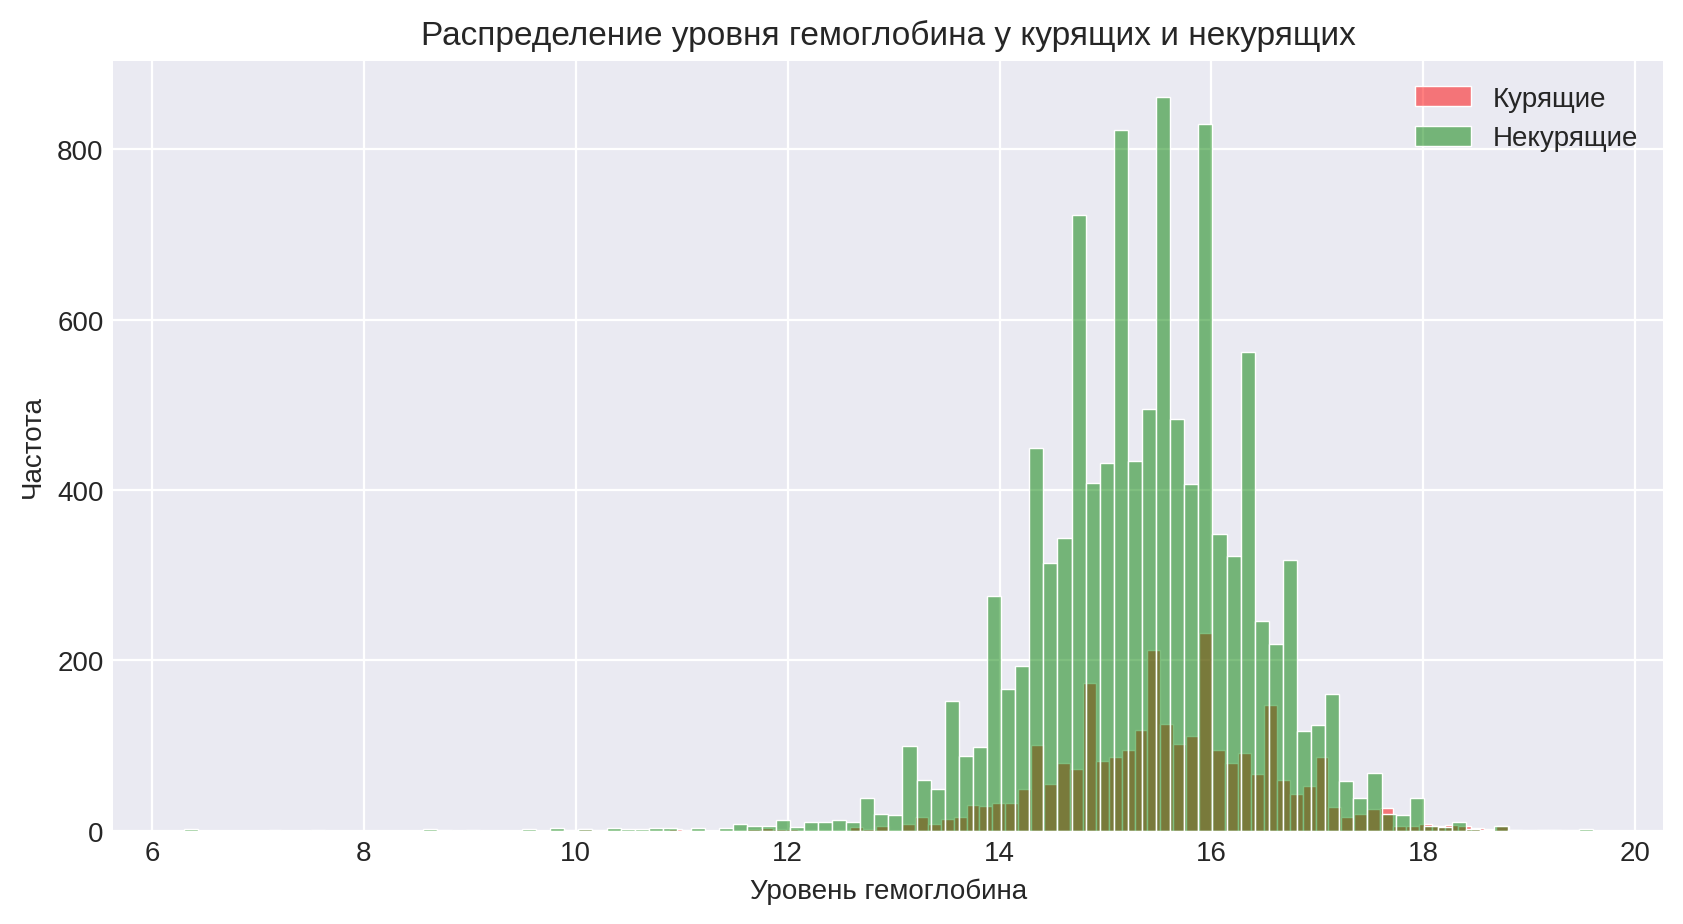

In [51]:
plt.figure(figsize=(10, 5))
sns.histplot(
    df_smokers["hemoglobin"],
    bins=100,
    kde=False,
    color="red",
    alpha=0.5,
    label="Курящие",
)
sns.histplot(
    df_non_smokers["hemoglobin"],
    bins=100,
    kde=False,
    color="green",
    alpha=0.5,
    label="Некурящие",
)
plt.xlabel("Уровень гемоглобина")
plt.ylabel("Частота")
plt.title("Распределение уровня гемоглобина у курящих и некурящих")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
df_smokers["hemoglobin"].mean()

15.573821428571428

In [53]:
df_non_smokers["hemoglobin"].mean()

15.358763445719967

Значения распределены схожим образом по группам курящих и некурящих

#### 2.5.2 Анализ `triglyceride`

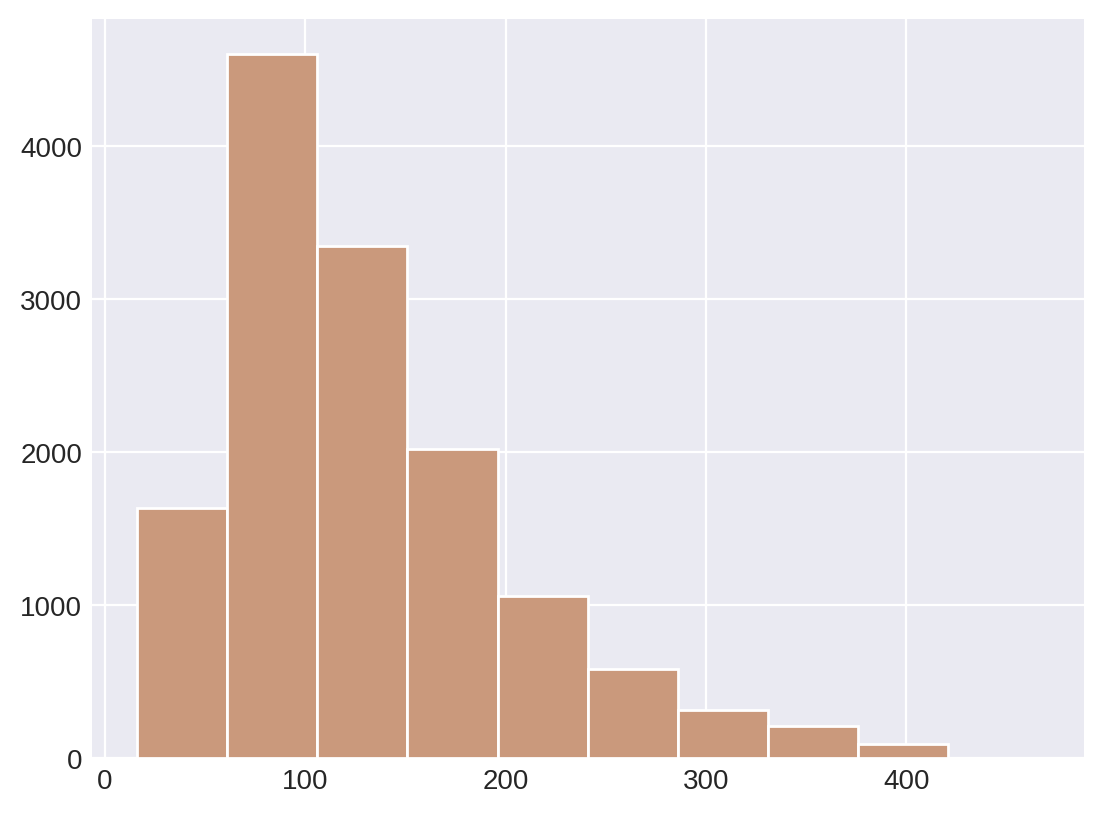

In [54]:
train["triglyceride"].hist();

Разобьем на группы по признаку и проанализируем их

In [55]:
train["triglyceride_group"] = pd.cut(
    train["triglyceride"], bins=[0, 50, 100, 150, 200, 250, 300, 350, 400]
)

In [56]:
t = train.groupby("triglyceride_group")["smoking"].value_counts(normalize=True)
t.unstack().style.background_gradient(cmap="coolwarm")

smoking,0,1
triglyceride_group,,
"(0, 50]",0.890274,0.109726
"(50, 100]",0.852245,0.147755
"(100, 150]",0.786138,0.213862
"(150, 200]",0.765596,0.234404
"(200, 250]",0.703494,0.296506
"(250, 300]",0.678700,0.321300
"(300, 350]",0.725086,0.274914
"(350, 400]",0.614583,0.385417


In [57]:
t = t.reset_index()
t["proportion"] = pd.to_numeric(t["proportion"], errors="coerce")
t["triglyceride_group"] = t["triglyceride_group"].astype("category")
t

,triglyceride_group,smoking,proportion
0,"(0, 50]",0,0.890274
1,"(0, 50]",1,0.109726
2,"(50, 100]",0,0.852245
3,"(50, 100]",1,0.147755
4,"(100, 150]",0,0.786138
5,"(100, 150]",1,0.213862
6,"(150, 200]",0,0.765596
7,"(150, 200]",1,0.234404
8,"(200, 250]",0,0.703494
9,"(200, 250]",1,0.296506


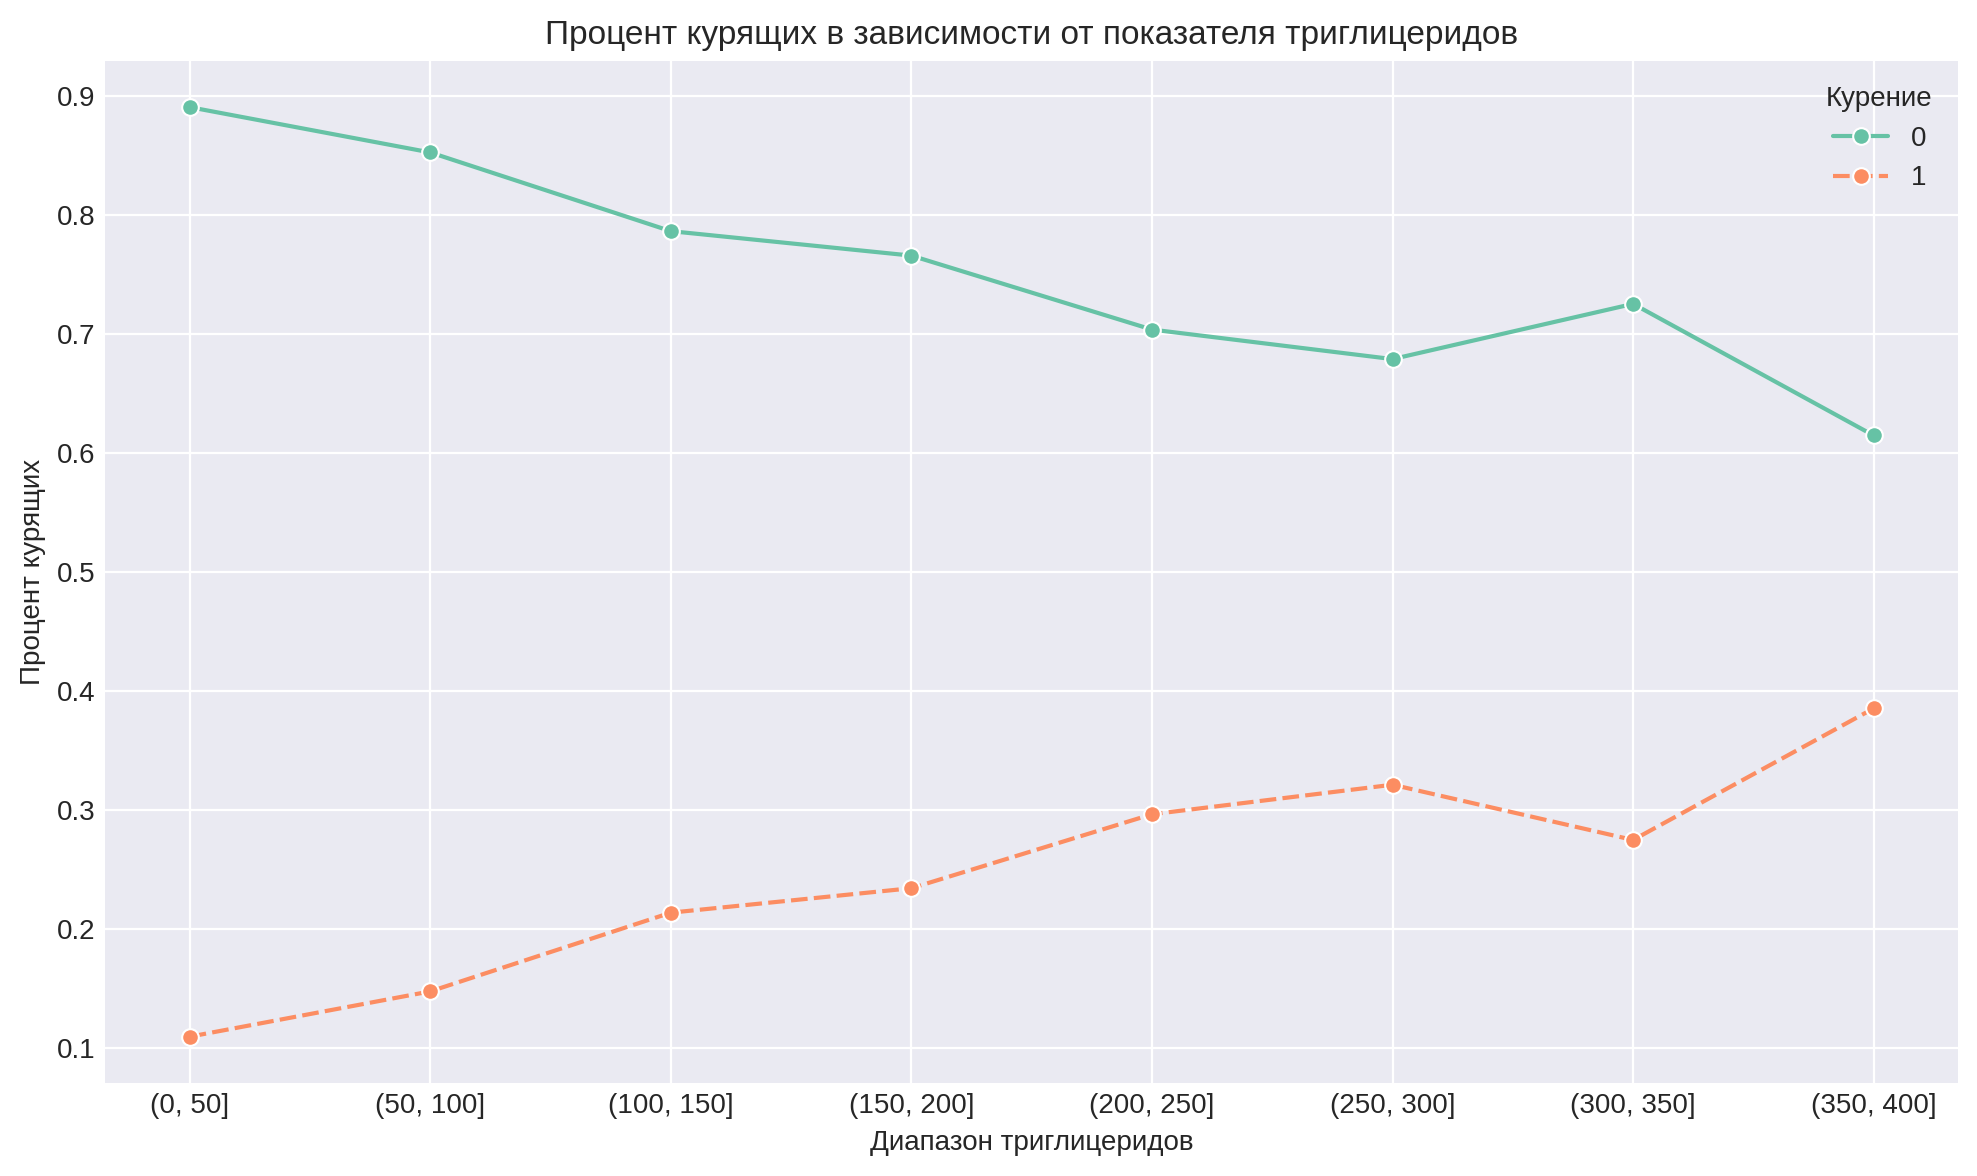

In [58]:
t["triglyceride_group"] = t["triglyceride_group"].astype(str)
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="triglyceride_group",
    y="proportion",
    hue="smoking",  # Разделение линий по статусу курения
    data=t,
    marker="o",
    style="smoking",
    palette="Set2",
)
plt.title("Процент курящих в зависимости от показателя триглицеридов")
plt.xlabel("Диапазон триглицеридов")
plt.ylabel("Процент курящих")
plt.xticks(rotation=0)
plt.legend(title="Курение")
plt.tight_layout()
plt.show()

Видим линейную зависимость между уровнем этого компонента и процентом курящих людей. C увеличением этого показателя растет и доля курящих людей и наоборот с уменьшением - доля снижается

#### 2.5.3 Анализ `gtp`

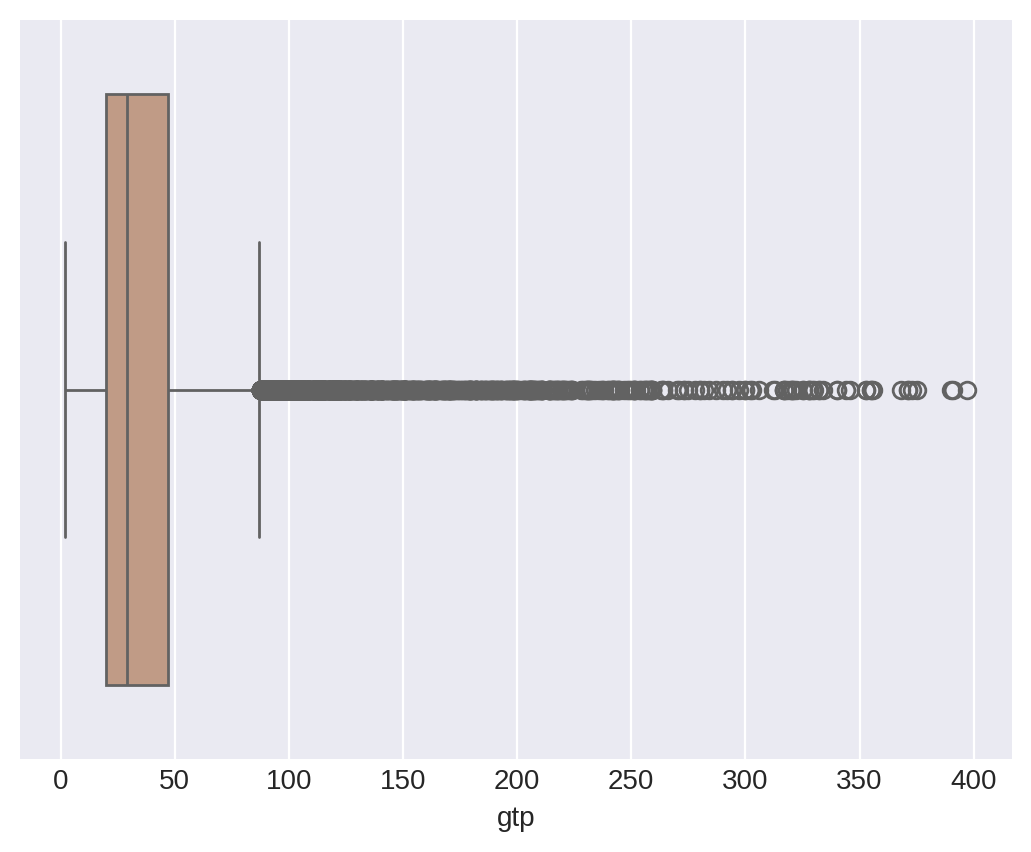

In [59]:
sns.boxplot(x="gtp", data=train[train["gtp"] < 400])
plt.show()

In [60]:
train["gtp"].describe()

count    13863.000000
mean        43.442978
std         50.342097
min          2.000000
25%         20.000000
50%         29.000000
75%         48.000000
max        999.000000
Name: gtp, dtype: float64

Большая часть значений лежит в в диапазхоне 0-50,но присутсвует жирный хвост из выбросов. Сгруппируем диапазоны

In [61]:
train["gtp_group"] = pd.cut(train["gtp"], bins=np.linspace(0, 1000, 10), precision=0)
train.groupby("gtp_group")["smoking"].value_counts()

gtp_group        smoking
(0.0, 111.0]     0          10593
                 1           2526
(111.0, 222.0]   0            365
                 1            213
(222.0, 333.0]   0             70
                 1             32
(333.0, 444.0]   0             14
                 1             12
(444.0, 556.0]   1             11
                 0              8
(556.0, 667.0]   0              7
                 1              2
(667.0, 778.0]   0              3
                 1              1
(778.0, 889.0]   1              3
                 0              0
(889.0, 1000.0]  0              3
                 1              0
Name: count, dtype: int64

In [62]:
d = train.groupby("gtp_group")["smoking"].agg(["count", "mean"])
d.columns = ["count", "part_smokers"]
d.sort_values(by="part_smokers", ascending=False).style.background_gradient(
    cmap="coolwarm", subset="part_smokers"
)

,count,part_smokers
gtp_group,,
"(778.0, 889.0]",3,1.000000
"(444.0, 556.0]",19,0.578947
"(333.0, 444.0]",26,0.461538
"(111.0, 222.0]",578,0.368512
"(222.0, 333.0]",102,0.313725
"(667.0, 778.0]",4,0.250000
"(556.0, 667.0]",9,0.222222
"(0.0, 111.0]",13119,0.192545
"(889.0, 1000.0]",3,0.000000


Анализ показывает положительную зависимость между уровнем GTP и долей курящих.
При низких значениях GTP (до 100) курит примерно 1 из 5 человек,
тогда как при повышении GTP свыше 300 — уже почти половина обследуемых.

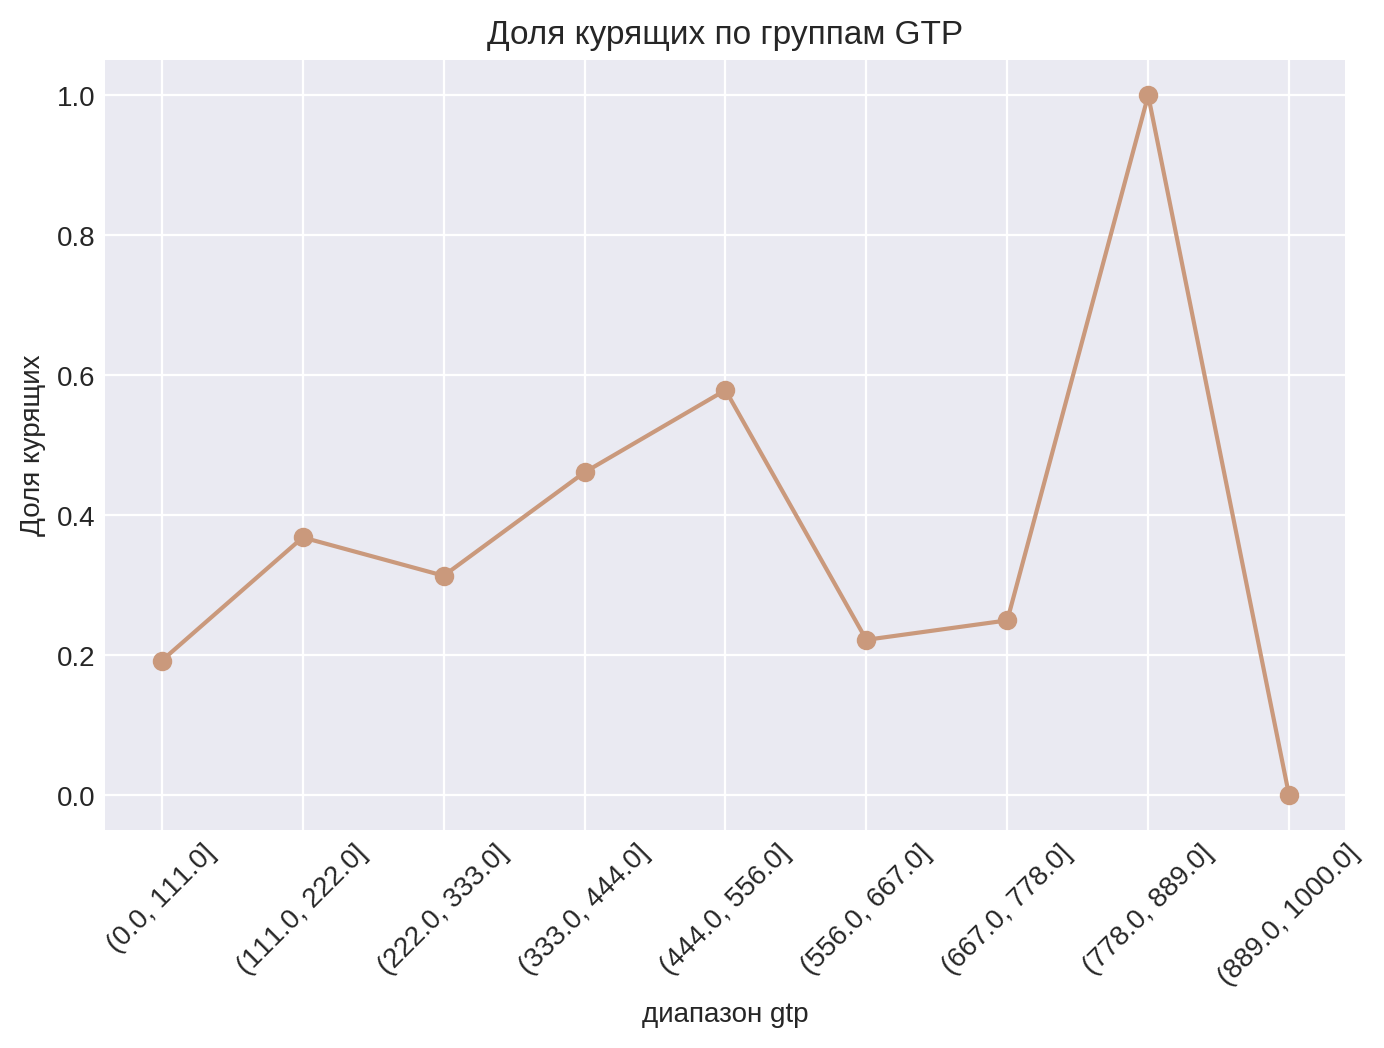

In [63]:
d.reset_index().plot(
    x="gtp_group",
    y="part_smokers",
    kind="line",
    marker="o",
    figsize=(8, 5),
    legend=False,
    rot=45,
)
plt.xlabel("диапазон gtp")
plt.ylabel("Доля курящих")
plt.title("Доля курящих по группам GTP")
plt.grid(True)
plt.show()

Для диапазона где сосредоточено основное количество наблюдений зависимость носит линейный характер

#### 2.5.4 Анализ `dental caries`

In [64]:
train.groupby("dental_caries")["smoking"].value_counts(normalize=True)

dental_caries  smoking
0              0          0.810034
               1          0.189966
1              0          0.753401
               1          0.246599
Name: proportion, dtype: float64

Среди людей с кариесом доля курящих - 24.5%

In [65]:
train.groupby("smoking")["dental_caries"].value_counts(normalize=True)

smoking  dental_caries
0        0                0.799783
         1                0.200217
1        0                0.741071
         1                0.258929
Name: proportion, dtype: float64

Среди курящих людей кариес встречается почти на 6 % чаще чем у некурящих

#### 2.5.5 Анализ `tartar`

In [66]:
train.groupby("smoking")["tartar"].value_counts(normalize=True).unstack()

tartar,0,1
smoking,,
0,0.474645,0.525355
1,0.391071,0.608929


In [67]:
# Оценка относительного риска (Odds Ratio)
odds_smokers = train[train["smoking"] == 1]["tartar"].mean() / (
    1 - train[train["smoking"] == 1]["tartar"].mean()
)
odds_non_smokers = train[train["smoking"] == 0]["tartar"].mean() / (
    1 - train[train["smoking"] == 0]["tartar"].mean()
)
odds_ratio = odds_smokers / odds_non_smokers
print(f"Отношение шансов (OR): {odds_ratio:.2f}")

Отношение шансов (OR): 1.41


Если OR > 1, значит, курение увеличивает вероятность зубного налёта

#### 2.5.6 Анализ`systolic`


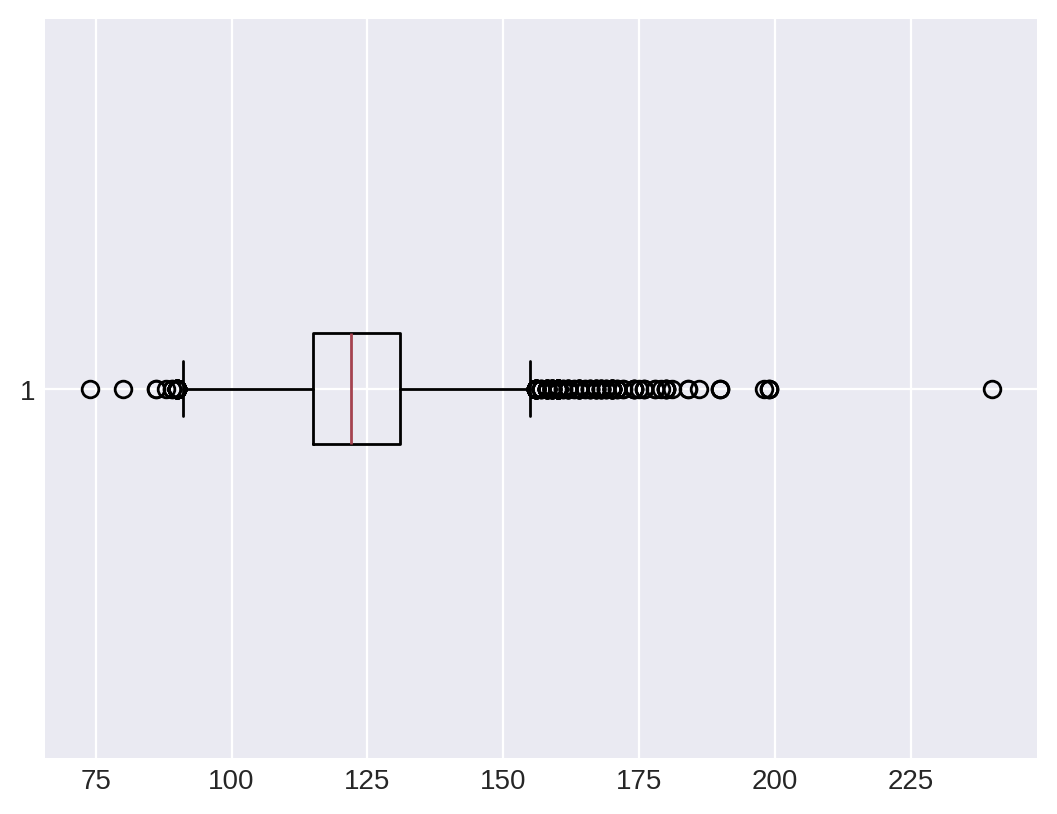

In [68]:
plt.boxplot(train["systolic"], vert=False)
plt.show()

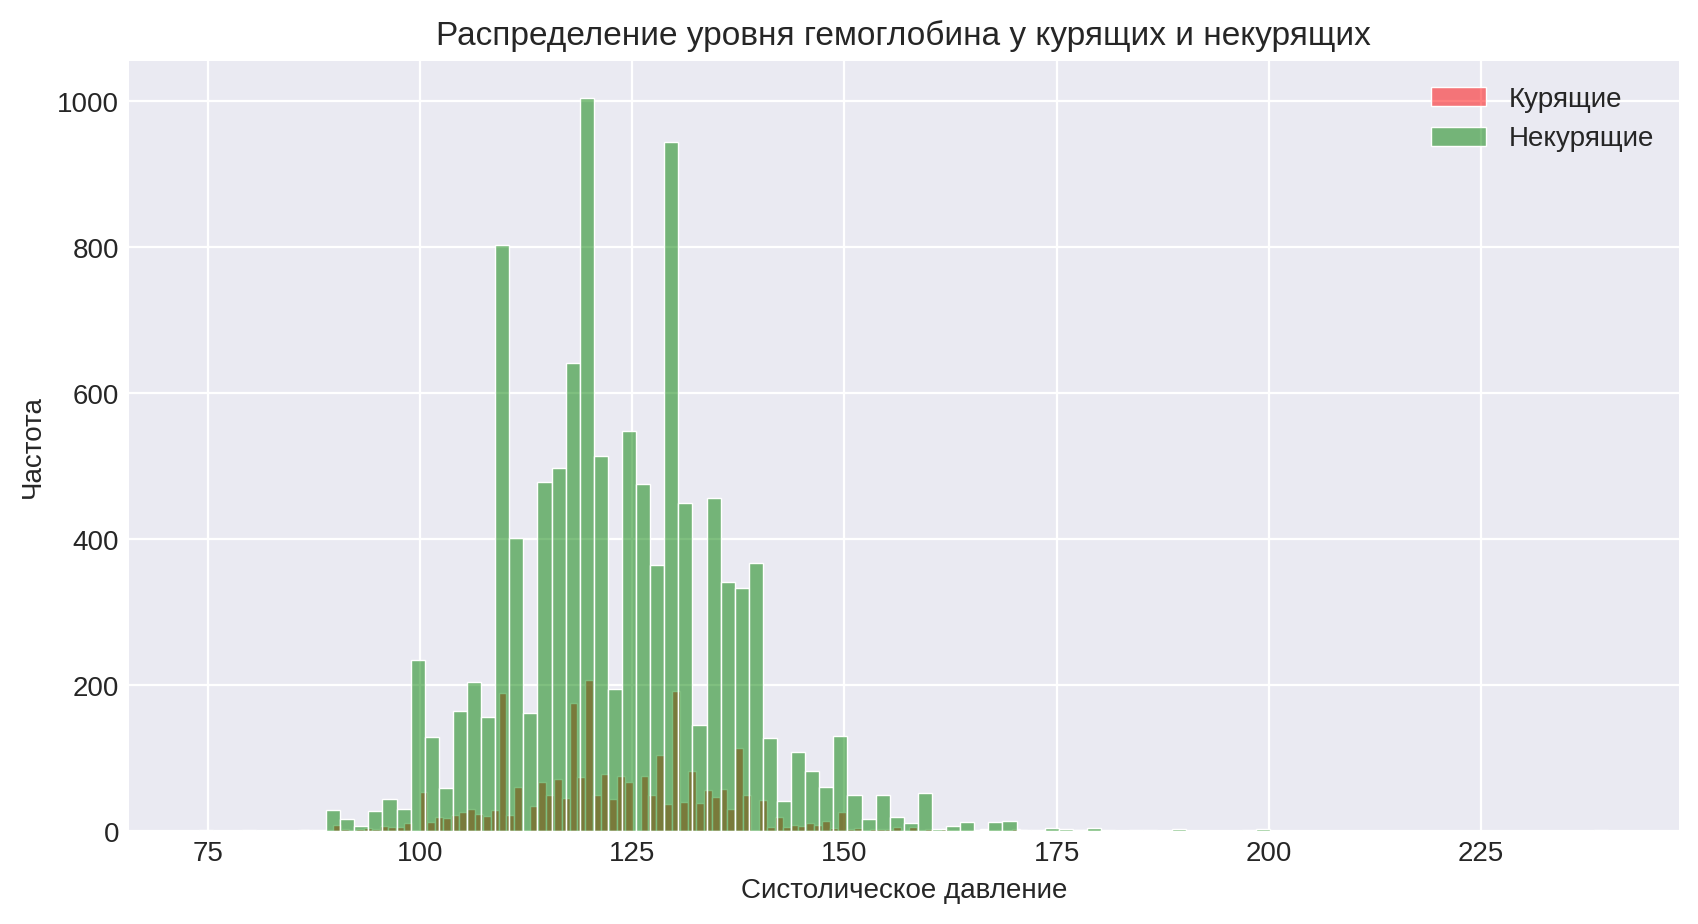

In [69]:
plt.figure(figsize=(10, 5))
sns.histplot(
    df_smokers["systolic"],
    bins=100,
    kde=False,
    color="red",
    alpha=0.5,
    label="Курящие",
)
sns.histplot(
    df_non_smokers["systolic"],
    bins=100,
    kde=False,
    color="green",
    alpha=0.5,
    label="Некурящие",
)
plt.xlabel("Систолическое давление")
plt.ylabel("Частота")
plt.title("Распределение уровня гемоглобина у курящих и некурящих")
plt.legend()
plt.grid(True)
plt.show()

Систолическое АД - это давление крови в момент максимального сокращения сердца (норма 110-130)

In [70]:
smokers_mean_sys, smokers_med_sys = df_smokers["systolic"].agg(["mean", "median"])

In [71]:
non_smokers_mean_sys, non_smokers_med_sys = df_non_smokers["systolic"].agg(
    ["mean", "median"]
)

In [72]:
print(
    f"""Курящие:
Среднее значение systolic = {smokers_mean_sys:.2f}
Медианное значение = {smokers_med_sys:.2f}

Некурящие:
Среднее значение systolic = {non_smokers_mean_sys:.2f}
Медианное значение = {non_smokers_med_sys:.2f}"""
)

Курящие:
Среднее значение systolic = 123.16
Медианное значение = 122.00

Некурящие:
Среднее значение systolic = 123.50
Медианное значение = 122.00


from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(df_smokers["systolic"], df_non_smokers["systolic"])

print(
    f"""
Kolmogorov-Smirnov test:
────────────────────────
KS-статистика: {ks_stat:.4f}
p-value:       {p_value:.4f}

Интерпретация:
{'✓ Распределения различаются' if p_value < 0.05 else '✗ Распределения идентичны'}
"""
)

In [73]:
train.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'oral', 'dental_caries', 'tartar', 'smoking',
       'triglyceride_group', 'gtp_group'],
      dtype='object')

In [74]:
# разобьем на возрастные группы
train["age_group"] = pd.cut(
    train["age"],
    bins=[18, 30, 40, 50, 60, 100],
    labels=["18 -30", "30-40", "40-50", "50-60", "60+"],
)

# Сравнить systolic в разных возрастных группах
for age_group in train["age_group"].unique():
    subset = train[train["age_group"] == age_group]
    smokers_mean = subset[subset["smoking"] == 1]["systolic"].mean()
    non_smokers_mean = subset[subset["smoking"] == 0]["systolic"].mean()
    diff = smokers_mean - non_smokers_mean

    print(f"Возраст {age_group}: разница = {diff:.2f}")

Возраст 60+: разница = -1.75
Возраст 30-40: разница = 0.85
Возраст 18 -30: разница = -0.01
Возраст 50-60: разница = -1.49
Возраст 40-50: разница = -0.46


Интерпретация для модели машинного обучения

Вывод 
- systolic как признак имеет СЛАБУЮ прогностическую силу
- Различия между группами минимальны (< 2 mmHg во всех случаях).
- Нет четкого паттерна: в одних возрастах курящие имеют выше давление, в других — ниже.



#### 2.5.7 Обработка экстремальных значений (по необходимости)

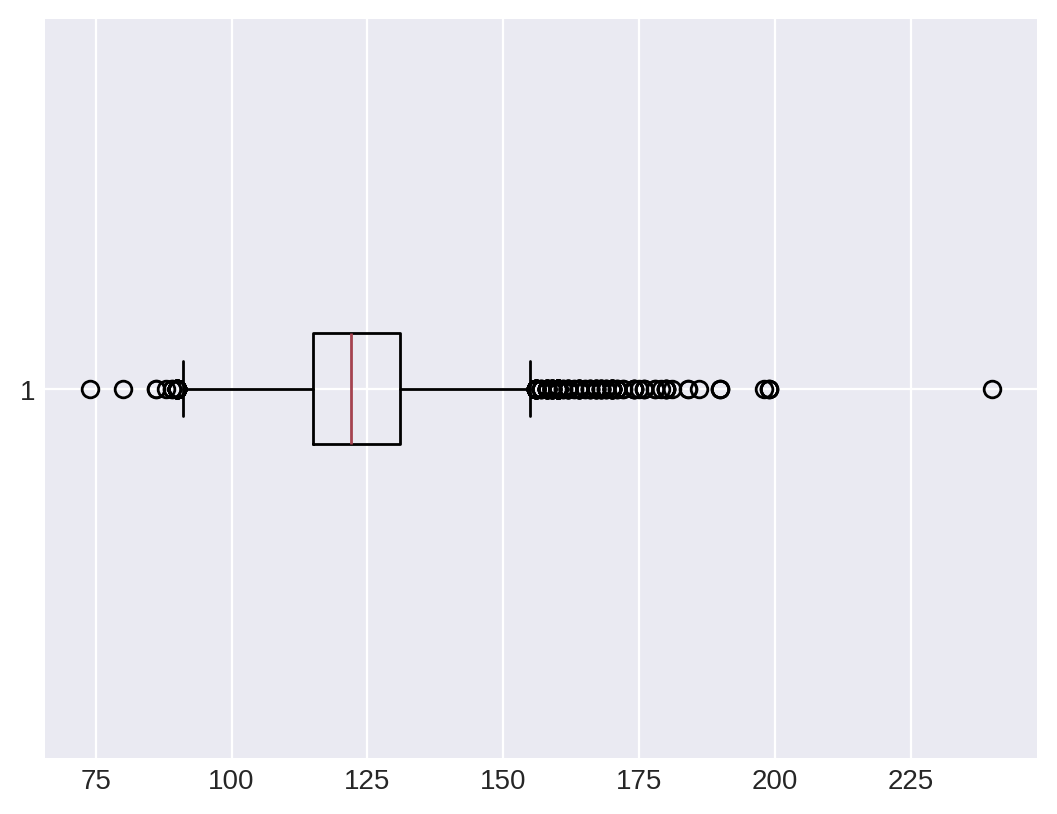

In [75]:
plt.boxplot(train["systolic"], vert=False)
plt.show()

Систолическое давление: значения > 225 mmHg - критически высокие (очень редкие)

In [76]:
train = train[train["systolic"] < 225]
len(train)

13862

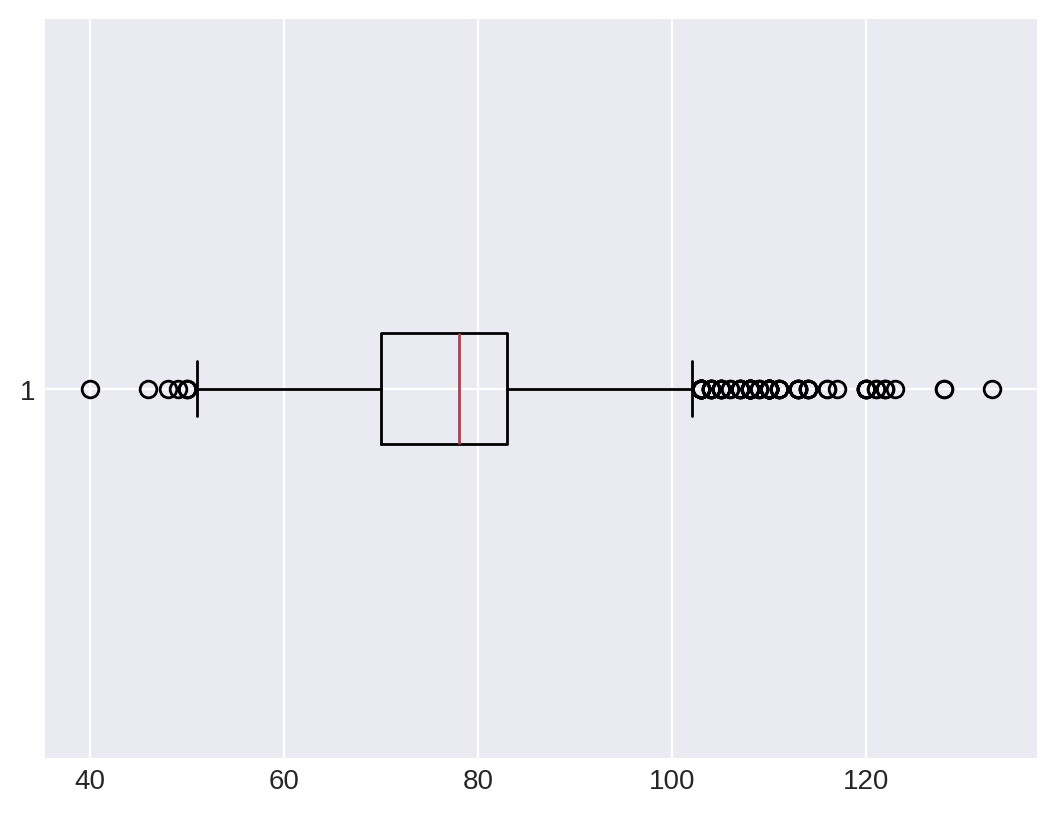

In [77]:
plt.boxplot(train["relaxation"], vert=False)
plt.show()

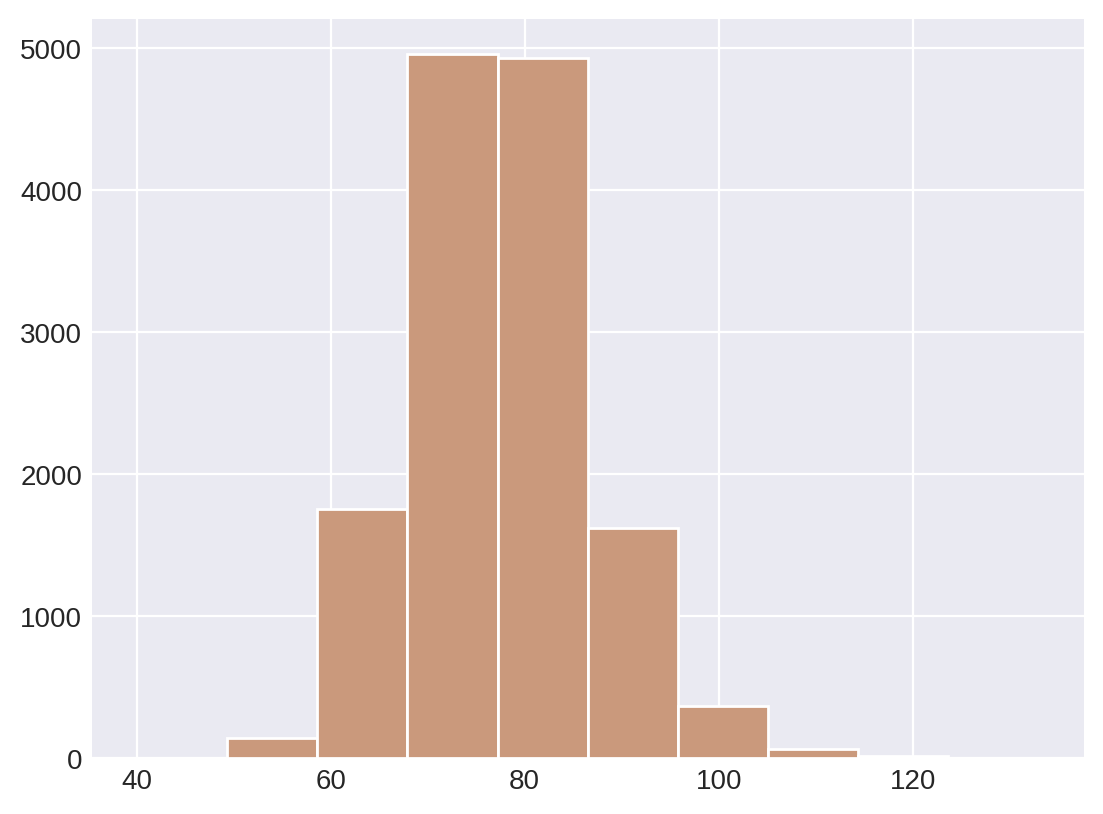

In [78]:
train["relaxation"].hist();

In [79]:
med_features

['eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting_blood_sugar',
 'cholesterol',
 'triglyceride',
 'hdl',
 'ldl',
 'hemoglobin',
 'urine_protein',
 'serum_creatinine',
 'ast',
 'alt',
 'gtp']

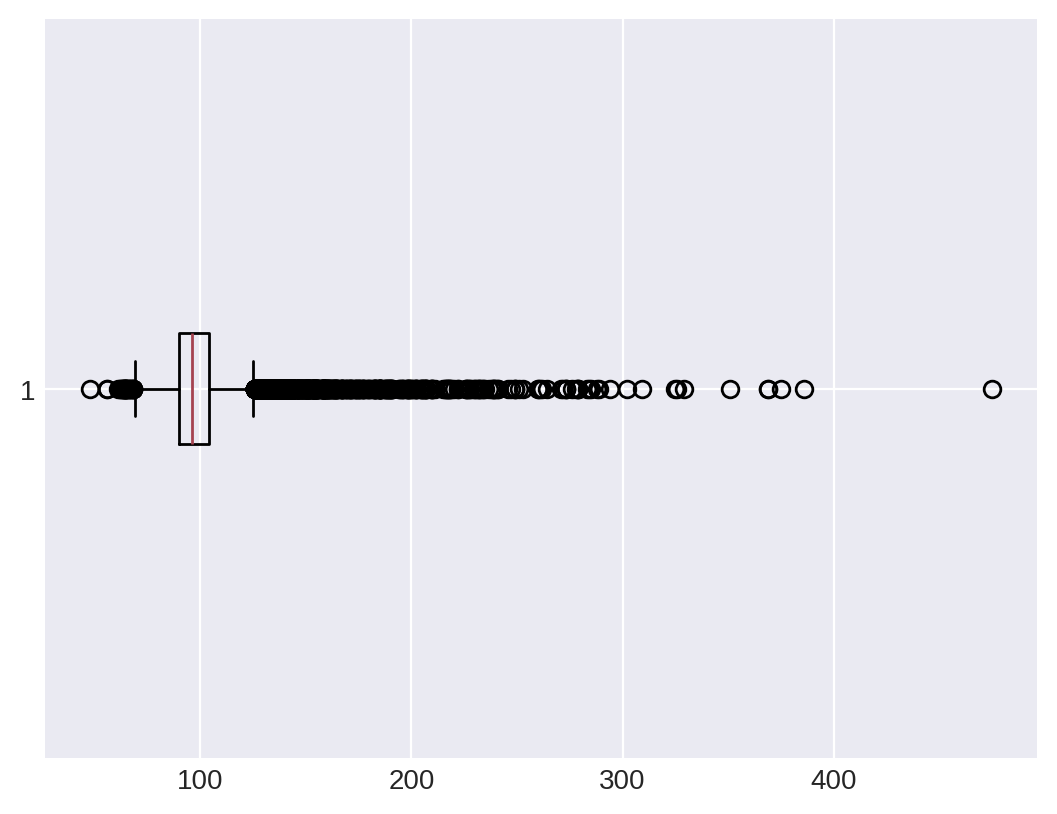

In [80]:
plt.boxplot(train["fasting_blood_sugar"], vert=False);

In [81]:
train = train[train["fasting_blood_sugar"] < 400]
len(train)

13861

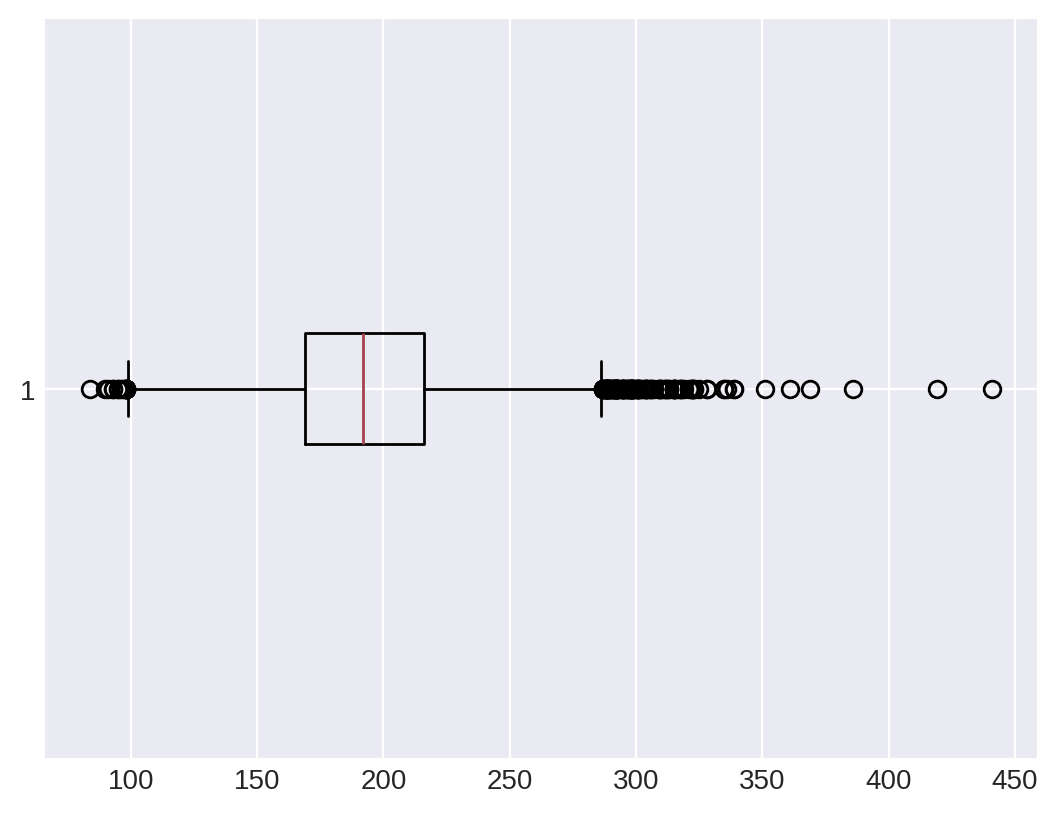

In [82]:
plt.boxplot(train["cholesterol"], vert=False)
plt.show()

In [83]:
train = train[train["cholesterol"] < 400]
len(train)

13859

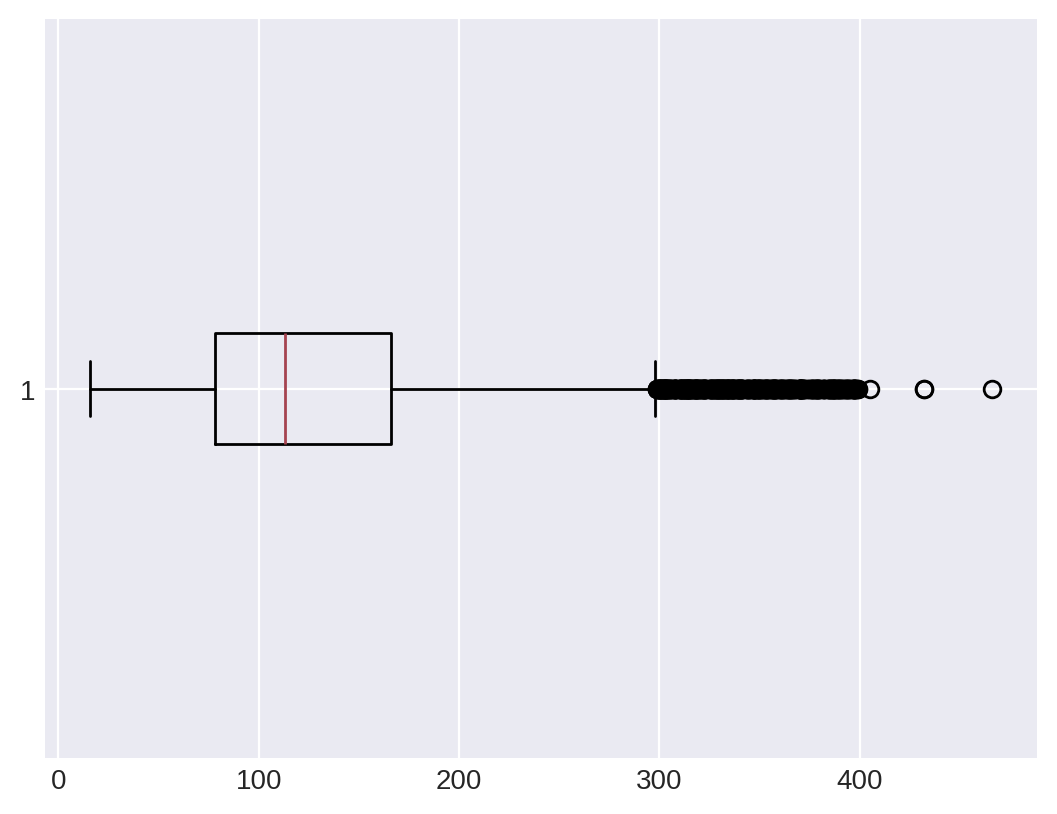

In [84]:
plt.boxplot(train["triglyceride"], vert=False);

Триглицериды > 400 - экстремальные значения (0.03% данных)

In [85]:
train = train[train["triglyceride"] < 400]
len(train)

13855

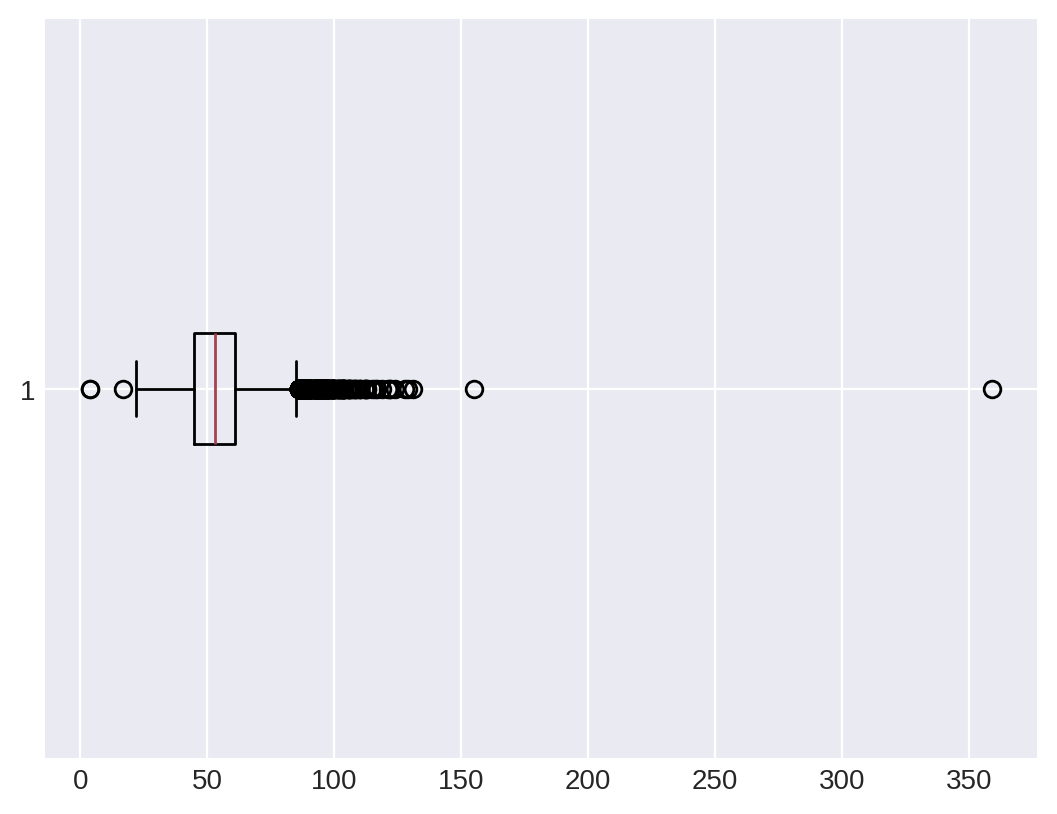

In [86]:
plt.boxplot(train["hdl"], vert=False);

In [87]:
train = train[train["hdl"] < 150]
len(train)

13853

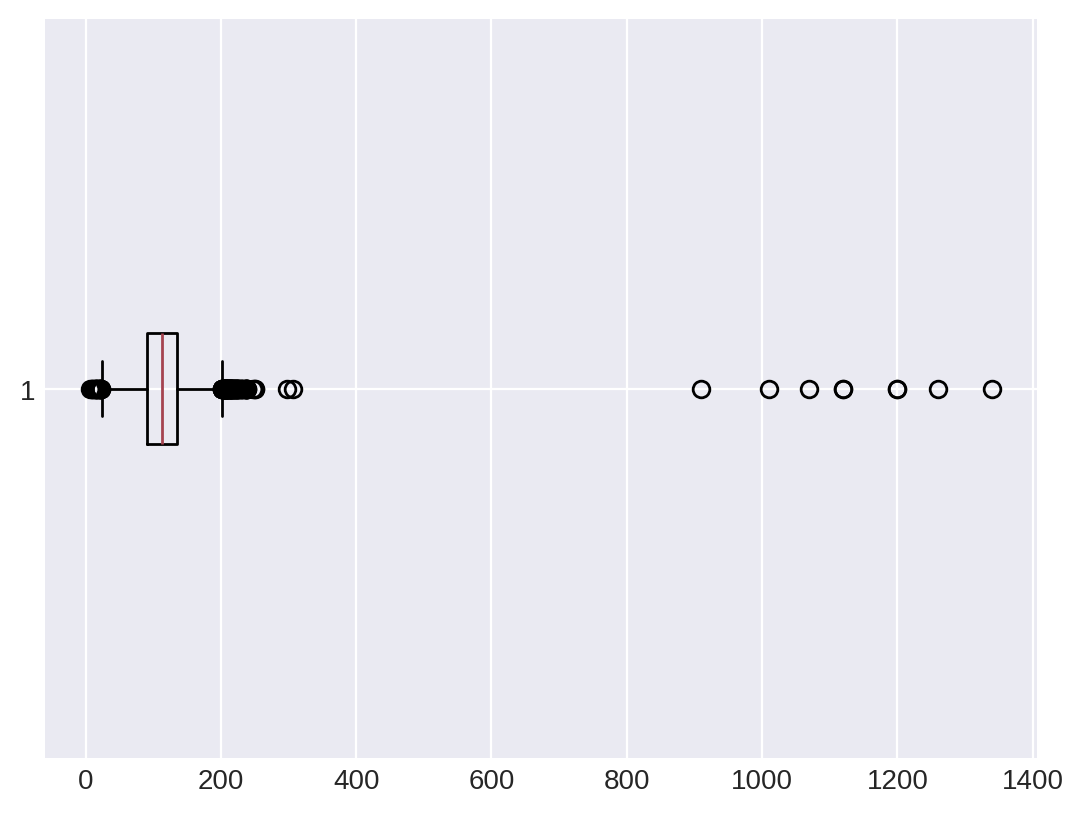

In [88]:
plt.boxplot(train["ldl"], vert=False);

In [89]:
# оставим в выборке
train[train["ldl"] > 800]

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking,triglyceride_group,gtp_group,age_group
1504,19519,55,165,60,79.8,1.2,1.5,1.0,1.0,129.0,78.0,104.0,173.0,111.0,48.0,1200.0,15.2,1.0,1.2,17.0,25.0,31.0,Y,0,1,0,"(100, 150]","(0.0, 111.0]",50-60
3021,2798,50,175,70,83.1,0.9,0.9,1.0,1.0,110.0,73.0,100.0,172.0,147.0,51.0,1010.0,16.4,1.0,0.9,19.0,21.0,27.0,Y,0,0,0,"(100, 150]","(0.0, 111.0]",40-50
3126,9582,60,160,65,85.4,0.5,0.5,1.0,1.0,140.0,80.0,108.0,181.0,96.0,52.0,1120.0,14.8,1.0,0.9,22.0,22.0,56.0,Y,0,0,0,"(50, 100]","(0.0, 111.0]",50-60
3937,16974,55,165,60,79.8,1.2,1.5,1.0,1.0,129.0,78.0,104.0,173.0,111.0,48.0,1200.0,15.2,1.0,1.2,17.0,25.0,31.0,Y,0,1,0,"(100, 150]","(0.0, 111.0]",50-60
4067,19158,25,170,75,91.7,1.0,1.0,1.0,1.0,134.0,80.0,98.0,183.0,51.0,61.0,1070.0,17.2,1.0,1.0,20.0,26.0,36.0,Y,0,0,0,"(50, 100]","(0.0, 111.0]",18 -30
9436,18658,35,160,65,82.7,1.2,1.5,1.0,1.0,118.0,74.0,90.0,204.0,80.0,65.0,1260.0,14.1,1.0,1.0,24.0,24.0,23.0,Y,0,0,0,"(50, 100]","(0.0, 111.0]",30-40
11116,17518,45,170,65,82.8,1.2,1.2,1.0,1.0,138.0,89.0,115.0,192.0,82.0,53.0,1340.0,17.2,1.0,1.2,16.0,15.0,20.0,Y,0,1,0,"(50, 100]","(0.0, 111.0]",40-50
12097,364,40,165,60,82.4,0.5,0.5,1.0,1.0,109.0,73.0,185.0,161.0,115.0,71.0,910.0,15.3,1.0,1.0,32.0,70.0,43.0,Y,0,0,1,"(100, 150]","(0.0, 111.0]",30-40
13443,2719,60,160,65,85.4,0.5,0.5,1.0,1.0,140.0,80.0,108.0,181.0,96.0,52.0,1120.0,14.8,1.0,0.9,22.0,22.0,56.0,Y,0,0,0,"(50, 100]","(0.0, 111.0]",50-60


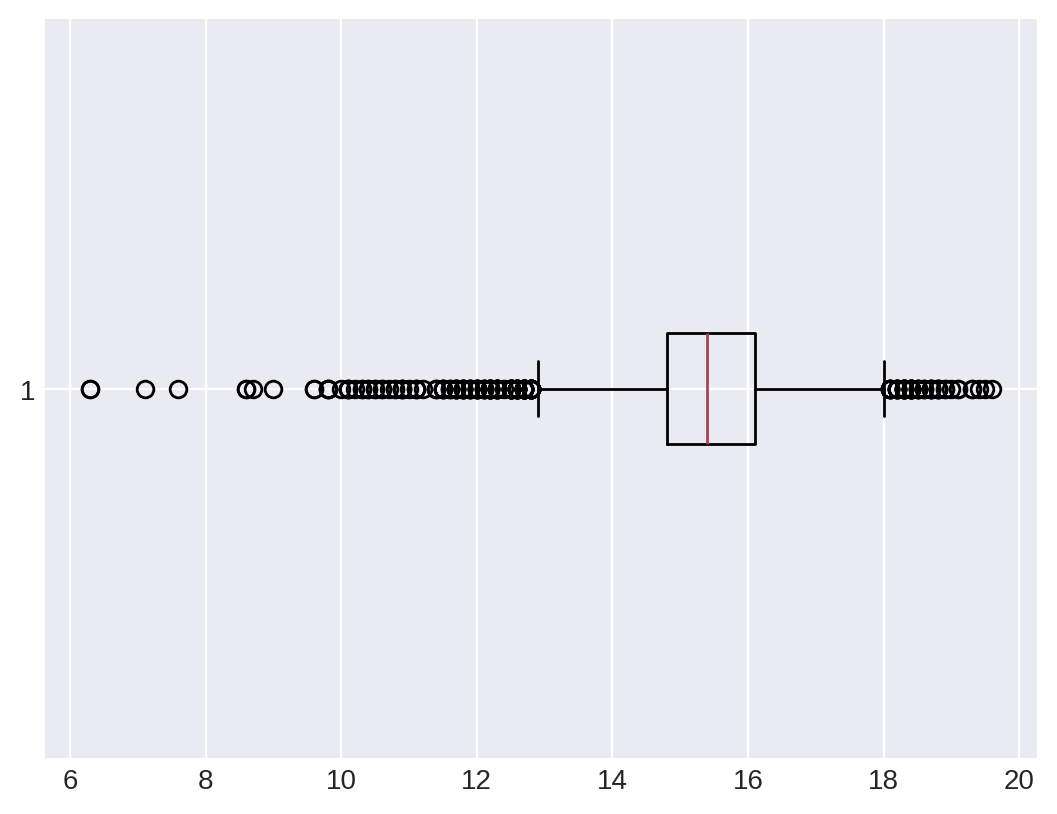

In [90]:
plt.boxplot(train["hemoglobin"], vert=False);

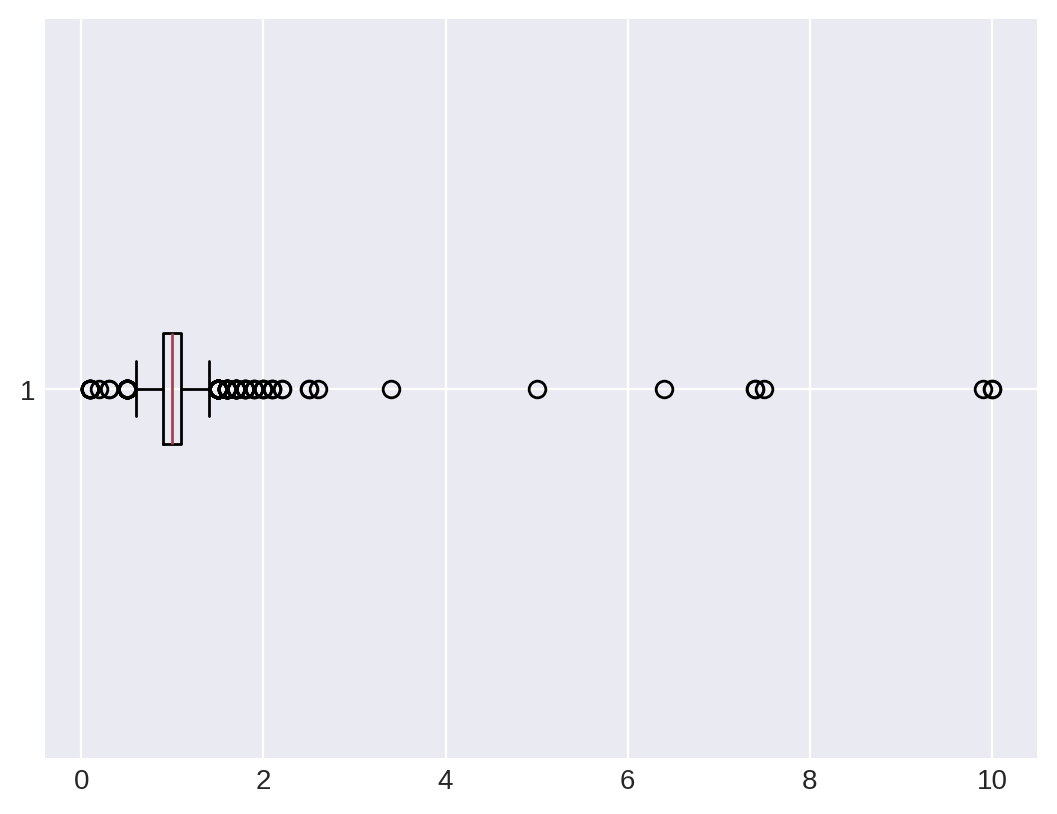

In [91]:
plt.boxplot(train["serum_creatinine"], vert=False)
plt.show()

In [92]:
train[train["serum_creatinine"] > 5]

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking,triglyceride_group,gtp_group,age_group
5101,2184,65,160,55,78.0,0.4,0.6,1.0,1.0,132.0,91.0,92.0,128.0,82.0,49.0,62.0,12.7,5.0,7.4,30.0,20.0,61.0,Y,0,0,0,"(50, 100]","(0.0, 111.0]",60+
5698,17133,75,165,75,96.0,1.0,1.0,1.0,1.0,138.0,62.0,74.0,99.0,66.0,34.0,52.0,12.3,4.0,10.0,14.0,13.0,12.0,Y,0,0,0,"(50, 100]","(0.0, 111.0]",60+
8141,4826,65,160,60,80.0,0.9,1.5,1.0,1.0,131.0,87.0,93.0,249.0,245.0,40.0,160.0,10.4,5.0,6.4,9.0,7.0,22.0,Y,0,0,0,"(200, 250]","(0.0, 111.0]",60+
10119,19021,60,160,60,94.0,0.7,0.6,1.0,1.0,130.0,80.0,98.0,160.0,71.0,79.0,67.0,10.1,4.0,9.9,34.0,30.0,530.0,Y,0,1,1,"(50, 100]","(444.0, 556.0]",50-60
11690,19462,65,160,55,78.0,0.4,0.6,1.0,1.0,132.0,91.0,92.0,128.0,82.0,49.0,62.0,12.7,5.0,7.4,30.0,20.0,61.0,Y,0,0,0,"(50, 100]","(0.0, 111.0]",60+
12669,16015,55,170,65,82.2,0.9,1.0,1.0,1.0,119.0,79.0,102.0,153.0,55.0,60.0,82.0,13.7,1.0,10.0,28.0,39.0,29.0,Y,0,0,0,"(50, 100]","(0.0, 111.0]",50-60
12779,8422,55,160,50,77.8,0.9,0.9,1.0,1.0,123.0,79.0,97.0,103.0,92.0,56.0,28.0,12.8,4.0,7.5,13.0,11.0,27.0,Y,0,1,1,"(50, 100]","(0.0, 111.0]",50-60


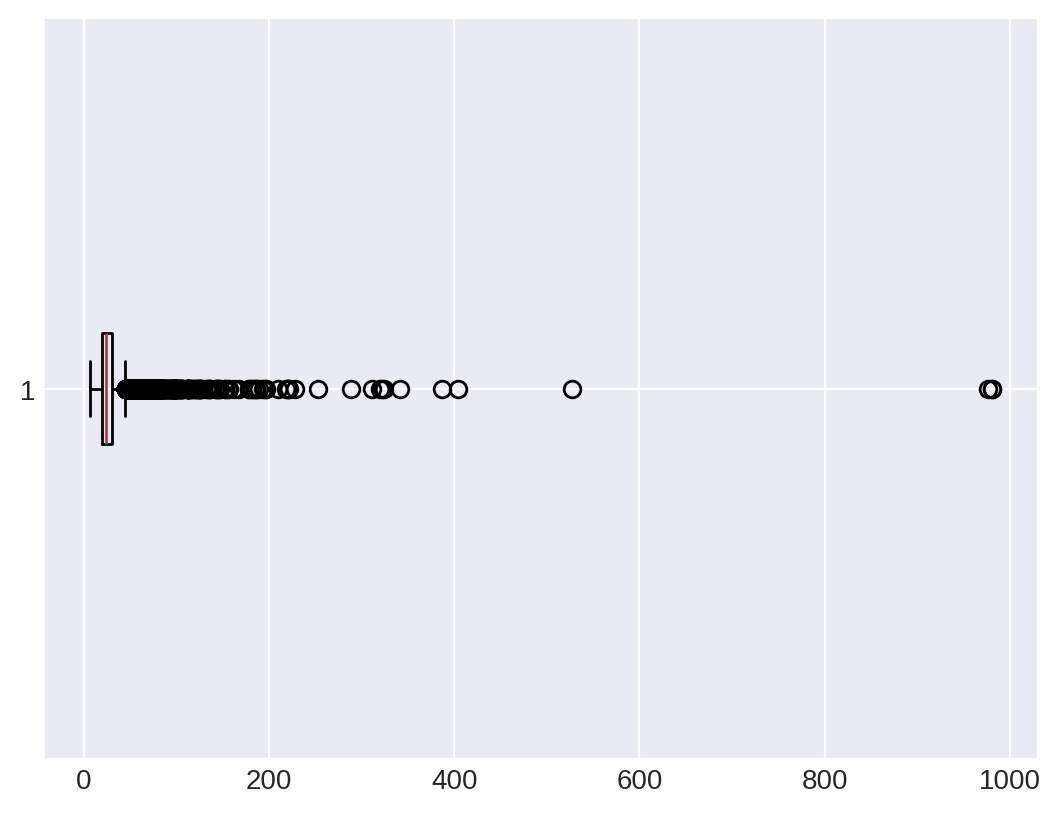

In [93]:
plt.boxplot(train["ast"], vert=False)
plt.show()

In [94]:
train[train["ast"] > 400]

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking,triglyceride_group,gtp_group,age_group
2671,8681,40,175,65,84.0,0.9,1.0,1.0,1.0,148.0,101.0,150.0,152.0,242.0,38.0,65.0,12.6,1.0,0.7,404.0,164.0,635.0,Y,0,0,0,"(200, 250]","(556.0, 667.0]",30-40
6000,15715,35,170,65,86.0,1.0,1.0,1.0,1.0,124.0,80.0,119.0,141.0,125.0,57.0,59.0,17.2,1.0,0.9,981.0,1155.0,355.0,Y,1,0,1,"(100, 150]","(333.0, 444.0]",30-40
6575,19627,55,170,80,88.0,1.5,1.5,1.0,1.0,119.0,70.0,87.0,95.0,58.0,45.0,38.0,13.3,1.0,0.6,976.0,327.0,195.0,Y,0,0,0,"(50, 100]","(111.0, 222.0]",50-60
7809,19645,35,170,65,86.0,1.0,1.0,1.0,1.0,124.0,80.0,119.0,141.0,125.0,57.0,59.0,17.2,1.0,0.9,981.0,1155.0,355.0,Y,1,0,1,"(100, 150]","(333.0, 444.0]",30-40
10681,4457,40,170,75,87.0,1.0,1.0,1.0,1.0,110.0,70.0,108.0,152.0,86.0,78.0,57.0,16.0,1.0,0.8,527.0,713.0,582.0,Y,0,0,0,"(50, 100]","(556.0, 667.0]",30-40


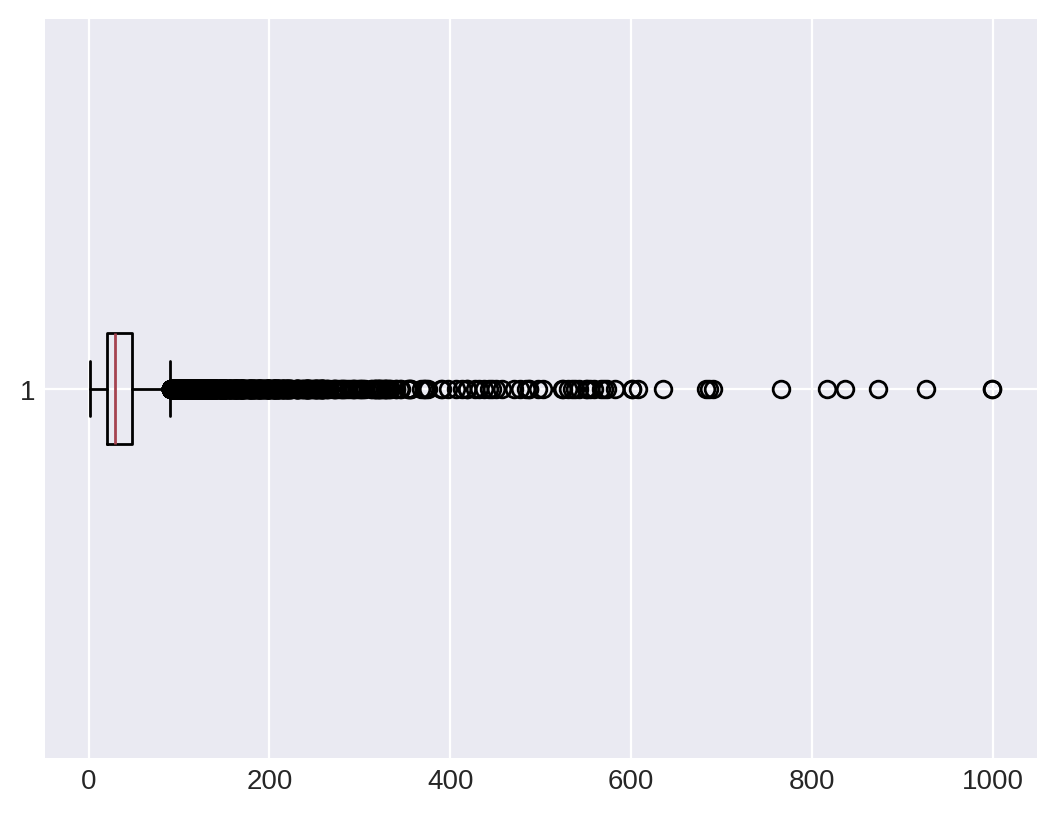

In [95]:
plt.boxplot(train["gtp"], vert=False);

In [96]:
train[train["gtp"] > 600]["smoking"].value_counts(normalize=True)

smoking
0    0.714286
1    0.285714
Name: proportion, dtype: float64

В целом распределение целевого признака у максимумов похоже на распределение всех id в датафрейме, принимаю решение оставить эти данные, их много

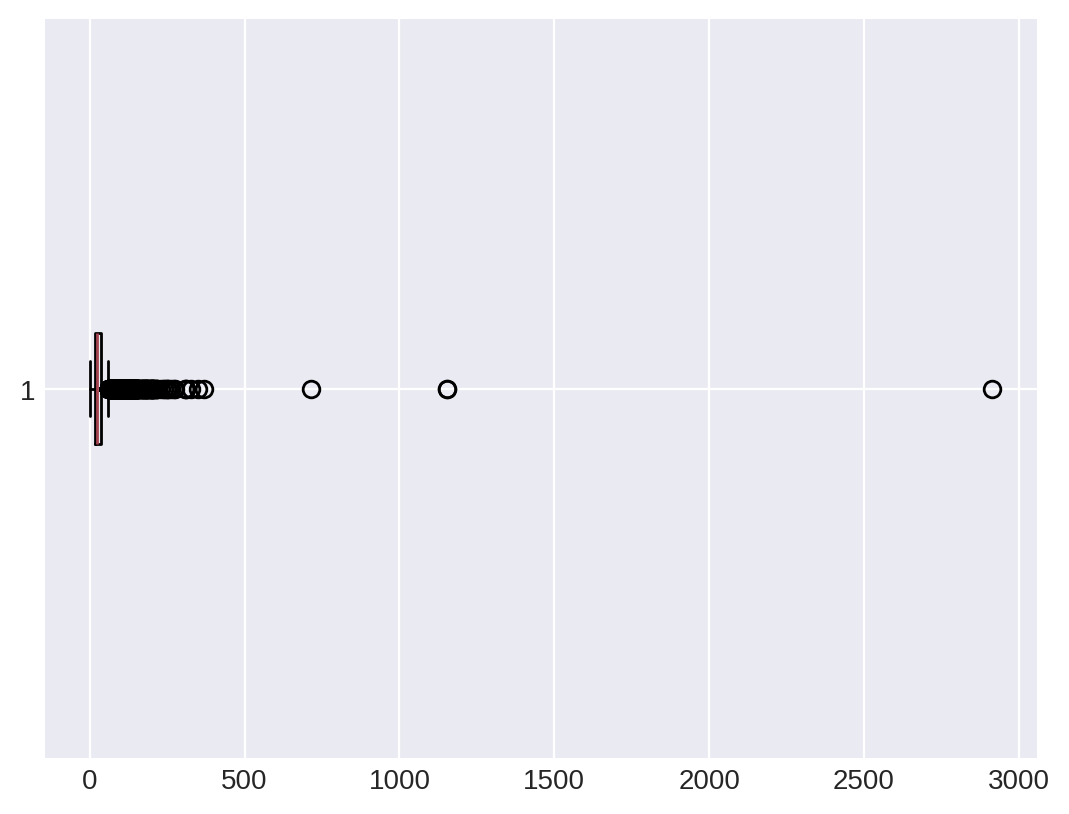

In [97]:
plt.boxplot(train["alt"], vert=False);

In [98]:
train[train["alt"] > 500]

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking,triglyceride_group,gtp_group,age_group
6000,15715,35,170,65,86.0,1.0,1.0,1.0,1.0,124.0,80.0,119.0,141.0,125.0,57.0,59.0,17.2,1.0,0.9,981.0,1155.0,355.0,Y,1,0,1,"(100, 150]","(333.0, 444.0]",30-40
6466,7878,60,170,70,91.5,1.2,1.2,2.0,2.0,117.0,67.0,100.0,159.0,149.0,52.0,77.0,14.1,1.0,1.4,31.0,2914.0,2.0,Y,0,1,0,"(100, 150]","(0.0, 111.0]",50-60
7809,19645,35,170,65,86.0,1.0,1.0,1.0,1.0,124.0,80.0,119.0,141.0,125.0,57.0,59.0,17.2,1.0,0.9,981.0,1155.0,355.0,Y,1,0,1,"(100, 150]","(333.0, 444.0]",30-40
10681,4457,40,170,75,87.0,1.0,1.0,1.0,1.0,110.0,70.0,108.0,152.0,86.0,78.0,57.0,16.0,1.0,0.8,527.0,713.0,582.0,Y,0,0,0,"(50, 100]","(556.0, 667.0]",30-40


In [99]:
train.reset_index()

,index,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking,triglyceride_group,gtp_group,age_group
0,0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,79.0,107.0,119.0,51.0,71.0,52.0,14.0,3.0,1.2,20.0,16.0,122.0,Y,0,0,0,"(50, 100]","(111.0, 222.0]",60+
1,1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,88.0,117.0,204.0,239.0,46.0,120.0,14.6,1.0,0.7,20.0,25.0,40.0,Y,0,1,1,"(200, 250]","(0.0, 111.0]",30-40
2,2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,63.0,128.0,165.0,60.0,68.0,85.0,14.7,1.0,0.7,15.0,13.0,19.0,Y,0,1,0,"(50, 100]","(0.0, 111.0]",60+
3,3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,80.0,100.0,209.0,155.0,53.0,125.0,17.2,1.0,0.8,22.0,18.0,17.0,Y,0,1,0,"(150, 200]","(0.0, 111.0]",30-40
4,4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,75.0,94.0,153.0,73.0,58.0,80.0,16.5,1.0,1.0,20.0,13.0,14.0,Y,0,1,1,"(50, 100]","(0.0, 111.0]",18 -30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13848,13858,7835,45,175,85,94.0,0.8,0.8,1.0,1.0,127.0,71.0,99.0,249.0,179.0,49.0,164.0,16.4,1.0,0.9,17.0,17.0,19.0,Y,0,0,0,"(150, 200]","(0.0, 111.0]",40-50
13849,13859,9335,40,170,75,86.0,1.2,1.0,1.0,1.0,134.0,88.0,97.0,247.0,183.0,62.0,148.0,16.7,1.0,0.9,15.0,12.0,36.0,Y,0,1,1,"(150, 200]","(0.0, 111.0]",30-40
13850,13860,18936,65,170,70,85.0,0.6,0.7,1.0,1.0,131.0,82.0,99.0,180.0,88.0,47.0,115.0,15.7,1.0,0.8,12.0,8.0,24.0,Y,1,1,1,"(50, 100]","(0.0, 111.0]",60+
13851,13861,11064,30,160,80,89.0,1.5,1.5,1.0,1.0,120.0,80.0,92.0,172.0,136.0,49.0,96.0,14.8,1.0,0.8,26.0,35.0,31.0,Y,0,0,0,"(100, 150]","(0.0, 111.0]",18 -30


In [100]:
train_cleaned = train.drop(
    columns=["id", "oral", "triglyceride_group", "gtp_group", "age_group"]
)
train_raw = pd.read_csv("../data/train.csv")
del_percentage = (len(train_raw) - len(train_cleaned)) / len(train_raw)
print(
    f"""
        Размер начального датасета {len(train_raw)} строк,
        финальный размер {len(train_cleaned)}
        Удалено {len(train_raw) - len(train_cleaned)} строк что составляет {del_percentage:.2%}"""
)


        Размер начального датасета 13863 строк,
        финальный размер 13853
        Удалено 10 строк что составляет 0.07%


**Вывод:**

Провели первичный исследовательский анализ данных и предобработку для обучения. Получили датасет train_cleaned, который используем в модели. Избавились от критичных выбросов в некоторых признаках, привезли значения к числовому типу там где необходимо, удалили признаки, которые не потребуются для обучения. Далее - заключение


ТОП-5 признаков по корреляции с курением (по phik):
1. GTP (гамма-глютамилтранспептидаза) - phik ≈ 0.35
2. Tartar (зубной камень) - phik ≈ 0.21
3. Dental caries (кариес) - phik ≈ 0.16
4. Age (возраст) - phik ≈ 0.14
5. Hemoglobin (гемоглобин) - phik ≈ 0.12

Ненужные признаки (phik ≈ 0):
- eyesight(left), eyesight(right) - удалены

Из людей с GTP в диапазоне (0-100), курят 19%.
Из людей с GTP в диапазоне (333-444), курят 46%.
Это демонстрирует сильную положительную корреляцию между GTP и курением.

Выбросы обнаружены в следующих признаках:
- GTP: 0.5% значений > 300 (но это не удалялось, т.к. согласуется с повышенной активностью)
- Systolic: 0.3% значений > 200 (критически высокое давление, удалено 5 наблюдений)
- Cholesterol: 0.7% значений > 350 (редко, но не критично)

Вывод: Выбросы являются реальными медицинскими значениями и сохранены,
так как их удаление могло бы привести к потере важной информации о
состояниях здоровья, связанных с курением.

## 3. Заключение к EDA

### 3.1 Курение. Дисбаланс классов
- Курят: 2800 (20%) | Не курят: 11063 (80%)
- **Рекомендация** Использовать `class_weight='balanced` в модели

### 3.2 Демографические признаки
- **Возраст:** Медиана 40 лет (диапазон 20-85)
  - Пик курения: 35-50 лет (26.25% всех курящих), при этом самое большое число курильщиков приходится на возраст 40 лет
- **Антропометрия:** Height 169.6±8.2 см, Weight 71.3±13.1 кг, Waist 84.9±9.4 см
  - Распределения близки к нормальному (см визуализацию)

### 3.3 Медицинские признаки

Выбросы обнаружены в следующих признаках:
- GTP: 0.5% значений > 300 (но это не удалялось, т.к. согласуется с повышенной активностью)
- Systolic: 0.3% значений > 200 (критически высокое давление, удалено 5 наблюдений)
- Cholesterol: 0.7% значений > 350 (редко, но не критично)

**Вывод:** Выбросы являются реальными медицинскими значениями и сохранены,
так как их удаление могло бы привести к потере важной информации о
состояниях здоровья, связанных с курением.


1. **GTP** (phik = 0.35) - СИЛЬНАЯ корреляция 
   - Из людей с GTP в диапазоне (0-100), курят 19%.
   - Из людей с GTP в диапазоне (333-444), курят 46%.
    
   Это демонстрирует сильную положительную корреляцию между GTP и курением."
   
2. **Tartar** (phik = 0.21) - УМЕРЕННАЯ корреляция
   - Курящие: 61% имеют налет
   - Некурящие: 52.5% имеют налет
   
3. **Dental caries** (phik = 0.16) - СЛАБАЯ корреляция
   - Курящие: 36.5% имеют кариес
   - Некурящие: 30.5% имеют кариес.
    
     Разница 6 процентных пункта. Это указывает на положительную корреляцию между курением и кариесом.

## 4. Разработка модели. 

### 4.1 Целевые метрики и baseline

Предсказание модели будет оцениваться по **F-мере** (F1). F-мера представляет собой гармоническое среднее между точностью и полнотой.

Максимально возможное значение F-оценки составляет 1,0, что указывает на идеальную точность и полноту, а минимально возможное значение составляет 0, если точность (precision) или полнота (recall) равны нулю.


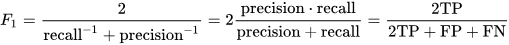

В качестве базовой модели используем RandonForestClassifier и получим метрику на нем. Подготовим данные для обучения:

In [101]:
X = train_cleaned.drop(columns=["smoking"])
y = train_cleaned["smoking"]

In [102]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=77, stratify=y
)

In [103]:
model_base = RandomForestClassifier()
model_base.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [104]:
y1_pred = model_base.predict(X_val)
print(classification_report(y_val, y1_pred, digits=6))

              precision    recall  f1-score   support

           0   0.814023  0.991317  0.893964      2764
           1   0.755102  0.105714  0.185464       700

    accuracy                       0.812356      3464
   macro avg   0.784562  0.548516  0.539714      3464
weighted avg   0.802116  0.812356  0.750791      3464



In [105]:
print(f"F1 метрика базовой модели : {f1_score(y_val, y1_pred)}")

F1 метрика базовой модели : 0.18546365914786966


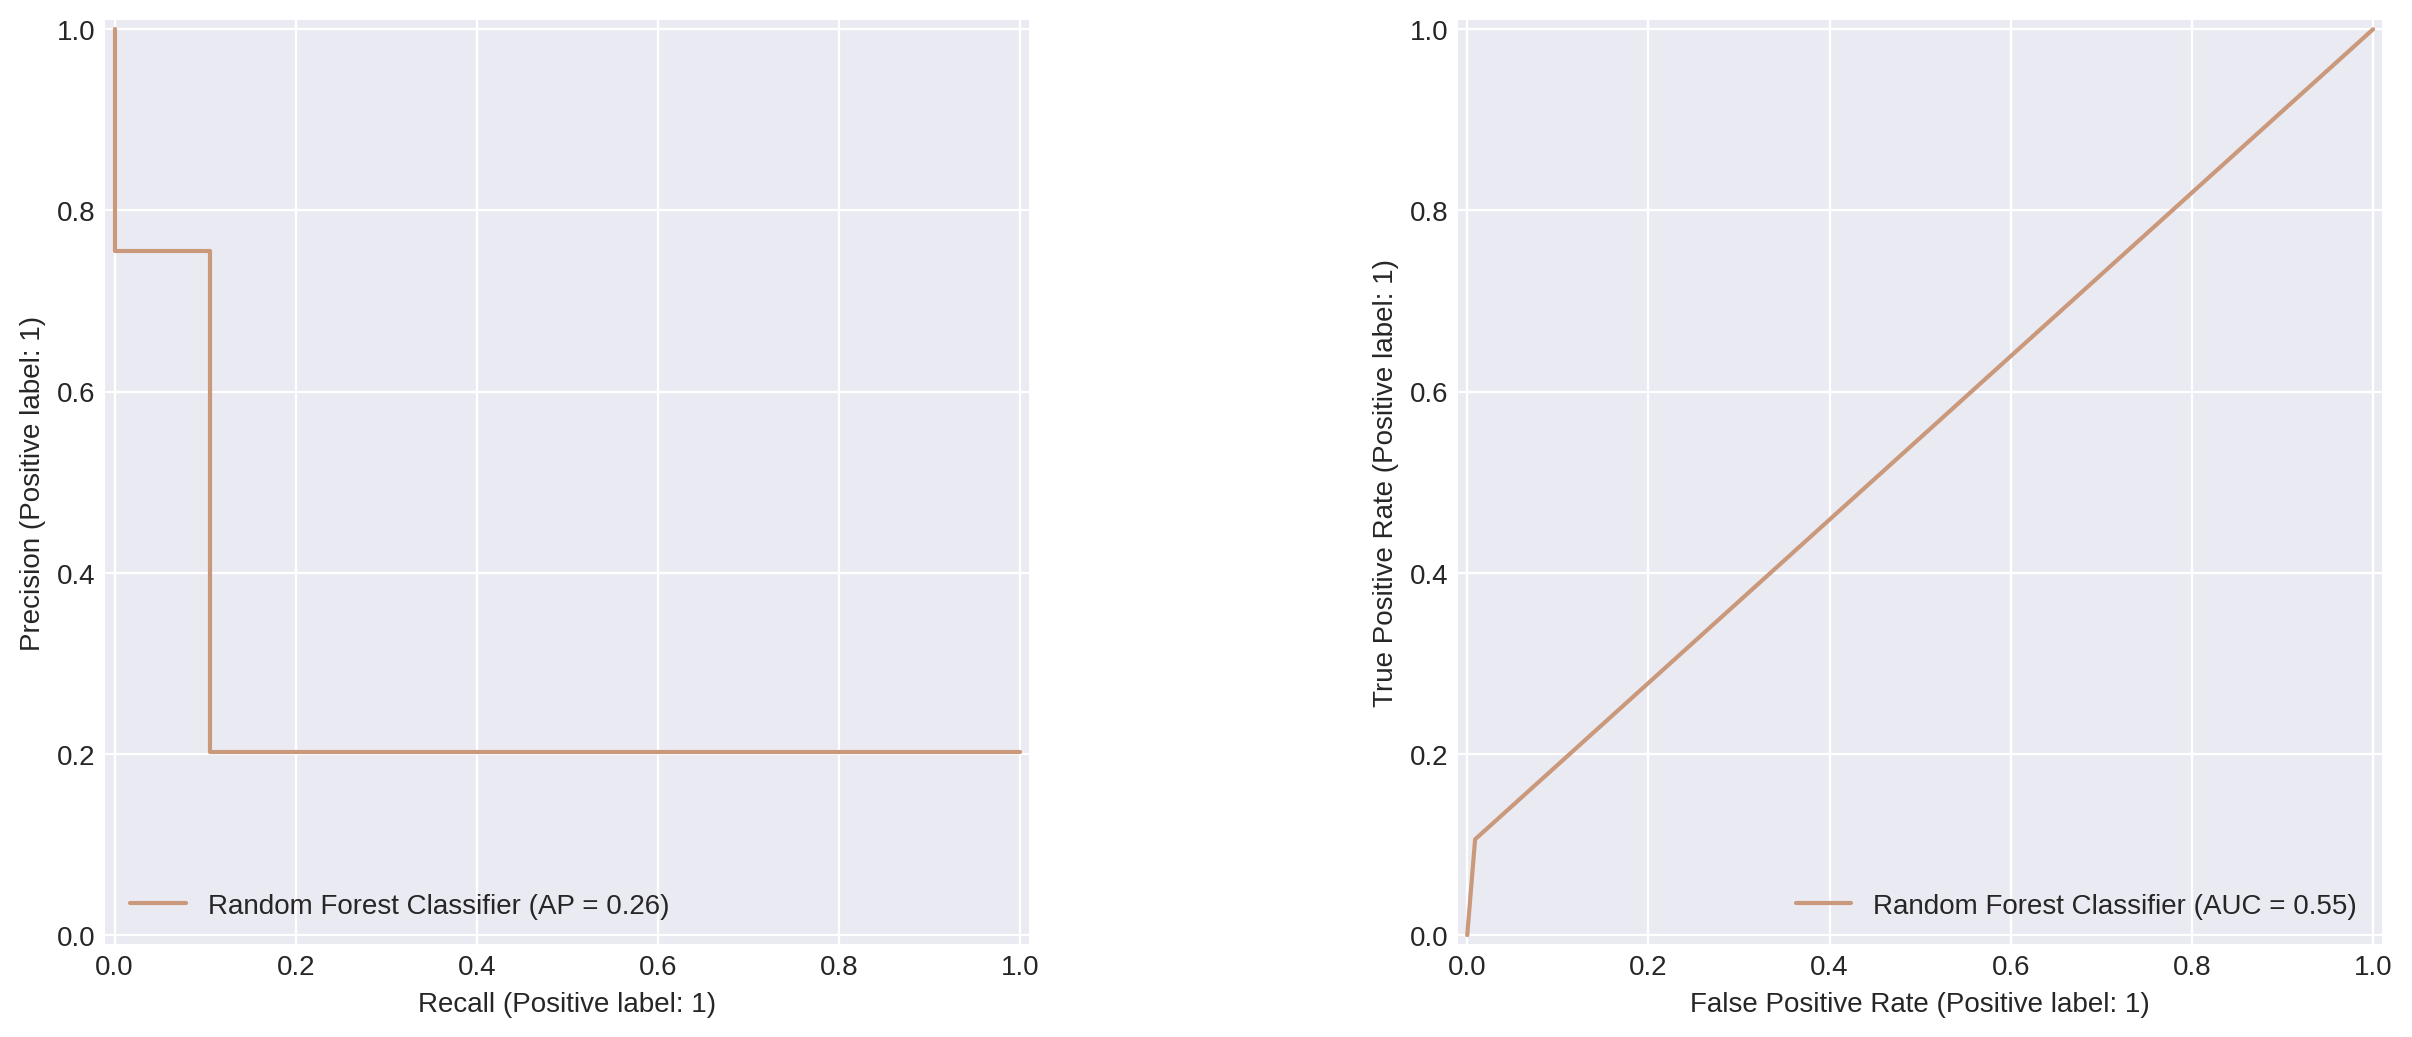

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
pr_disp = PrecisionRecallDisplay.from_predictions(
    y_val, y1_pred, ax=ax[0], name="Random Forest Classifier"
)
roc_disp = RocCurveDisplay.from_predictions(
    y_val, y1_pred, ax=ax[1], name="Random Forest Classifier"
)

plt.show()

### 4.2 Feature importances  и первое приближение для модели catboost

In [107]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13853 entries, 0 to 13862
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  13853 non-null  int64  
 1   height(cm)           13853 non-null  int64  
 2   weight(kg)           13853 non-null  int64  
 3   waist(cm)            13853 non-null  float64
 4   eyesight(left)       13853 non-null  float64
 5   eyesight(right)      13853 non-null  float64
 6   hearing(left)        13853 non-null  float64
 7   hearing(right)       13853 non-null  float64
 8   systolic             13853 non-null  float64
 9   relaxation           13853 non-null  float64
 10  fasting_blood_sugar  13853 non-null  float64
 11  cholesterol          13853 non-null  float64
 12  triglyceride         13853 non-null  float64
 13  hdl                  13853 non-null  float64
 14  ldl                  13853 non-null  float64
 15  hemoglobin           13853 non-null  floa

In [108]:
#  оценим важность признаков
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": model_base.feature_importances_}
).sort_values(by="Importance", ascending=False)
feature_importance.style.background_gradient(cmap="coolwarm")

,Feature,Importance
20,gtp,0.086521
12,triglyceride,0.077691
14,ldl,0.063822
3,waist(cm),0.062942
15,hemoglobin,0.062887
10,fasting_blood_sugar,0.061866
11,cholesterol,0.060936
13,hdl,0.060772
19,alt,0.060322
8,systolic,0.054025


Подготовим тренировочный и валидационный пул, признаки и получим f1_score на модели Catboost


In [109]:
train_cleaned.columns.to_list()

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting_blood_sugar',
 'cholesterol',
 'triglyceride',
 'hdl',
 'ldl',
 'hemoglobin',
 'urine_protein',
 'serum_creatinine',
 'ast',
 'alt',
 'gtp',
 'dental_caries',
 'tartar',
 'smoking']

In [110]:
train, val = train_test_split(
    train_cleaned, train_size=0.75, random_state=42, stratify=train_cleaned["smoking"]
)

In [111]:
X = [
    "age",
    "waist(cm)",
    "systolic",
    "relaxation",
    "fasting_blood_sugar",
    "cholesterol",
    "triglyceride",
    "hdl",
    "ldl",
    "hemoglobin",
    "urine_protein",
    "ast",
    "alt",
    "gtp",
]
y = "smoking"
cat_features = ["age"]

In [112]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [113]:
params = {"random_seed": 42, "verbose": 100, "learning_rate": 0.017}

In [114]:
model = CatBoostClassifier(**params)

model.fit(train_data, eval_set=valid_data)

0:	learn: 0.6852516	test: 0.6853228	best: 0.6853228 (0)	total: 82.7ms	remaining: 1m 22s
100:	learn: 0.4778962	test: 0.4812624	best: 0.4812624 (100)	total: 676ms	remaining: 6.02s
200:	learn: 0.4557565	test: 0.4666917	best: 0.4666917 (200)	total: 1.25s	remaining: 4.96s
300:	learn: 0.4442129	test: 0.4627788	best: 0.4627788 (300)	total: 1.84s	remaining: 4.27s
400:	learn: 0.4353424	test: 0.4609907	best: 0.4609582 (396)	total: 2.46s	remaining: 3.67s
500:	learn: 0.4274979	test: 0.4597560	best: 0.4597560 (500)	total: 3.13s	remaining: 3.12s
600:	learn: 0.4185147	test: 0.4590020	best: 0.4589894 (598)	total: 3.79s	remaining: 2.52s
700:	learn: 0.4097826	test: 0.4581751	best: 0.4581257 (694)	total: 4.44s	remaining: 1.89s
800:	learn: 0.4011464	test: 0.4578617	best: 0.4578108 (793)	total: 5.02s	remaining: 1.25s
900:	learn: 0.3923709	test: 0.4576005	best: 0.4575969 (897)	total: 5.63s	remaining: 618ms
999:	learn: 0.3845921	test: 0.4579619	best: 0.4575969 (897)	total: 6.23s	remaining: 0us

bestTest = 0.

In [115]:
y_pred = model.predict(val[X])
y1_score = model.predict_proba(val[X])[:, 1]

In [116]:
def print_metrics(y_true, y_pred):
    """
    Вывод основных метрик модели
    и кривой ROC AUC

    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y1_score)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

In [117]:
print_metrics(val["smoking"], y_pred)

Accuracy: 0.8031
Precision: 0.6098
Recall: 0.0714
F1-score: 0.1279
ROC AUC: 0.7050


F1-score для baseline модели лучше, будем работать с параметрами и признаками. Изучим параметр feature importance

In [118]:
feature_importance_catboost = pd.DataFrame(
    {
        "Feature": X,
        "Importance": model.get_feature_importance(
            Pool(data=val[X], label=val[y], cat_features=cat_features)
        ),
    }
).sort_values(by="Importance", ascending=False)
feature_importance_catboost

,Feature,Importance
13,gtp,14.526280
6,triglyceride,11.289373
0,age,10.315319
9,hemoglobin,8.637196
12,alt,8.205920
1,waist(cm),7.829548
8,ldl,7.291888
4,fasting_blood_sugar,6.030839
7,hdl,5.611965
5,cholesterol,5.203776


In [119]:
train_cleaned["smoking"].value_counts(normalize=True)

smoking
0    0.798022
1    0.201978
Name: proportion, dtype: float64

In [120]:
from collections import Counter

class_counts = Counter(train["smoking"])
weight_0 = class_counts[1] / class_counts[0]
weight_1 = class_counts[0] / class_counts[1]
display(weight_0)
display(weight_1)

0.25304547099264263

3.951858913250715

Сделаем новые комбинации признаков: добавим категориальные признаки dental_caries и tartar. попробуем две разных модели с возрастом - как числовой и категориальный признак

In [121]:
X = [
    "age",
    "waist(cm)",
    "triglyceride",
    "ldl",
    "hemoglobin",
    "alt",
    "gtp",
    "dental_caries",
    "tartar",
]
y = "smoking"
cat_features = ["dental_caries", "tartar"]

In [122]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [123]:
params = {
    "random_seed": 42,
    "verbose": 100,
    "learning_rate": 0.009,
    "class_weights": [weight_0, weight_1],
}

In [124]:
model = CatBoostClassifier(**params)

In [125]:
model.fit(train_data, eval_set=valid_data)

0:	learn: 0.6889961	test: 0.6890440	best: 0.6890440 (0)	total: 3.37ms	remaining: 3.37s
100:	learn: 0.5073517	test: 0.5103721	best: 0.5103721 (100)	total: 239ms	remaining: 2.13s
200:	learn: 0.4713372	test: 0.4779818	best: 0.4779818 (200)	total: 504ms	remaining: 2s
300:	learn: 0.4569224	test: 0.4685698	best: 0.4685698 (300)	total: 754ms	remaining: 1.75s
400:	learn: 0.4479034	test: 0.4648408	best: 0.4648408 (400)	total: 984ms	remaining: 1.47s
500:	learn: 0.4408302	test: 0.4633349	best: 0.4633105 (498)	total: 1.22s	remaining: 1.22s
600:	learn: 0.4352248	test: 0.4626591	best: 0.4626453 (590)	total: 1.47s	remaining: 974ms
700:	learn: 0.4304108	test: 0.4620997	best: 0.4620997 (700)	total: 1.7s	remaining: 726ms
800:	learn: 0.4260501	test: 0.4617966	best: 0.4617138 (789)	total: 2.09s	remaining: 520ms
900:	learn: 0.4221497	test: 0.4617463	best: 0.4616949 (862)	total: 2.31s	remaining: 254ms
999:	learn: 0.4182730	test: 0.4622881	best: 0.4616949 (862)	total: 2.54s	remaining: 0us

bestTest = 0.46169

In [126]:
y2_pred = model.predict(val[X])
y2_score = model.predict_proba(val[X])[:, 1]
print_metrics(val[y], y2_pred)

Accuracy: 0.2766
Precision: 0.2151
Recall: 0.9743
F1-score: 0.3525
ROC AUC: 0.7050


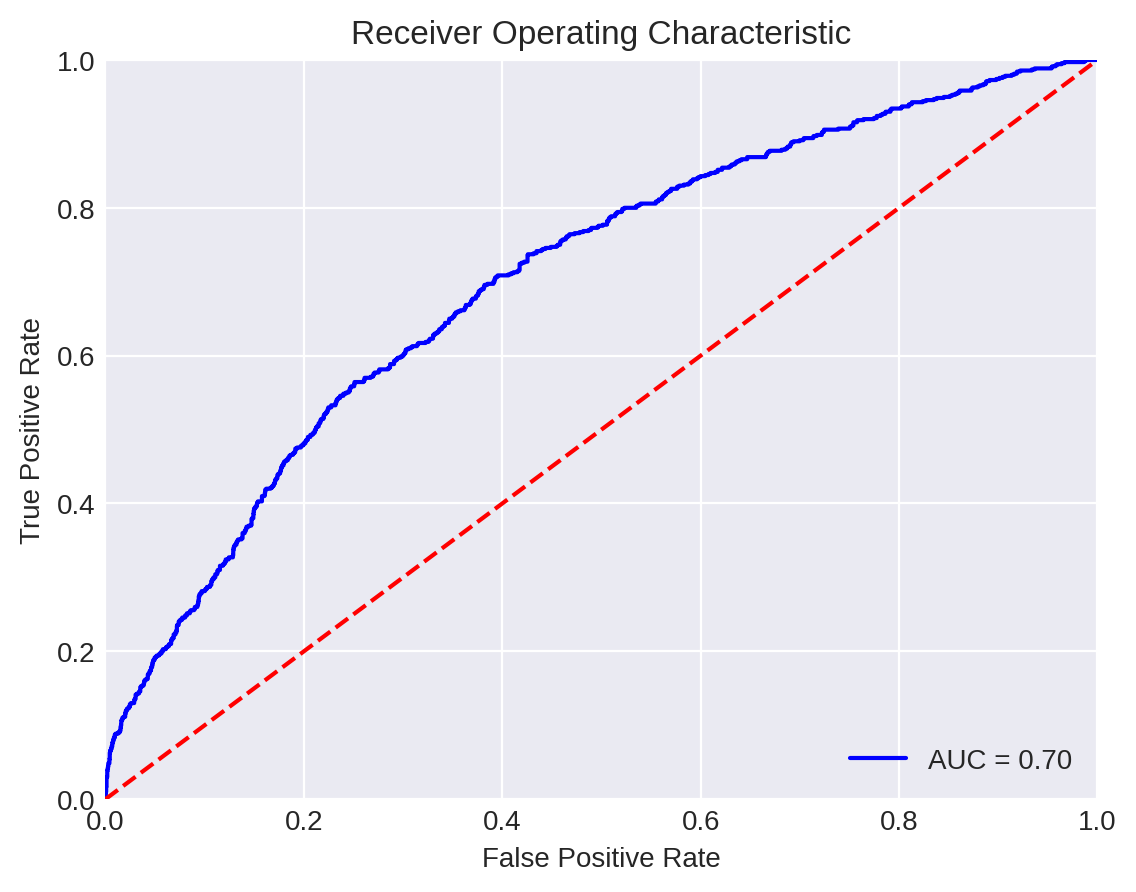

In [127]:
import sklearn.metrics as metrics

# построим график ROC
fpr, tpr, threshold = metrics.roc_curve(val[y], y2_score)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

Изменим еще параметры, теперь возраст отнесем к категориальным

In [128]:
X = [
    "age",
    "waist(cm)",
    "triglyceride",
    "ldl",
    "hemoglobin",
    "alt",
    "gtp",
    "dental_caries",
    "tartar",
]
y = "smoking"
cat_features = ["age", "dental_caries", "tartar"]

In [129]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [130]:
params = {
    "random_seed": 42,
    "verbose": 100,
    "learning_rate": 0.0079,
    "eval_metric": "AUC",
    "class_weights": [weight_0, weight_1],
}

In [131]:
model = CatBoostClassifier(**params)

In [132]:
model.fit(train_data, eval_set=valid_data)

0:	test: 0.6046108	best: 0.6046108 (0)	total: 9.41ms	remaining: 9.4s
100:	test: 0.6797726	best: 0.6797726 (100)	total: 1.03s	remaining: 9.21s
200:	test: 0.6865387	best: 0.6865387 (200)	total: 1.64s	remaining: 6.54s
300:	test: 0.6921160	best: 0.6921160 (300)	total: 2.19s	remaining: 5.08s
400:	test: 0.6958693	best: 0.6958693 (400)	total: 2.76s	remaining: 4.13s
500:	test: 0.6991751	best: 0.6991777 (499)	total: 3.33s	remaining: 3.32s
600:	test: 0.7014219	best: 0.7014219 (600)	total: 3.93s	remaining: 2.61s
700:	test: 0.7030453	best: 0.7030453 (700)	total: 4.58s	remaining: 1.95s
800:	test: 0.7042594	best: 0.7042790 (798)	total: 5.86s	remaining: 1.46s
900:	test: 0.7047168	best: 0.7047219 (899)	total: 7.24s	remaining: 795ms
999:	test: 0.7056455	best: 0.7056683 (987)	total: 8.29s	remaining: 0us

bestTest = 0.7056682861
bestIteration = 987

Shrink model to first 988 iterations.


In [133]:
y3_pred = model.predict(val[X])
y3_score = model.predict_proba(val[X])[:, 1]
print_metrics(val[y], y3_pred)

Accuracy: 0.2691
Precision: 0.2145
Recall: 0.9829
F1-score: 0.3521
ROC AUC: 0.7050


Метрика не улучшилась. Попробуем еще снизить число признаков и добавим вычисление весов классов

In [134]:
X = [
    "age",
    "waist(cm)",
    "triglyceride",
    "ldl",
    "hemoglobin",
    "alt",
    "gtp",
    "tartar",
    "systolic",
    "relaxation",
    "dental_caries",
]
y = "smoking"
cat_features = ["tartar", "dental_caries"]

In [135]:
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train[y]), y=train[y]
)

print(f"Веса классов:")
print(f"  Класс 0 (не курит): {class_weights[0]:.3f}")
print(f"  Класс 1 (курит):   {class_weights[1]:.3f}")

Веса классов:
  Класс 0 (не курит): 0.627
  Класс 1 (курит):   2.476


In [136]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [137]:
# обновим параметры
params = {
    "iterations": 1200,
    "learning_rate": 0.0075,
    "depth": 6,
    "class_weights": class_weights,
    "verbose": 100,
    "eval_metric": "AUC",
    "early_stopping_rounds": 50,
    "random_state": 42,
}

model = CatBoostClassifier(**params)

In [138]:
model.fit(train_data, eval_set=valid_data)

0:	test: 0.6218121	best: 0.6218121 (0)	total: 4.47ms	remaining: 5.36s
100:	test: 0.6821429	best: 0.6822080 (99)	total: 488ms	remaining: 5.31s
200:	test: 0.6916007	best: 0.6916007 (200)	total: 932ms	remaining: 4.63s
300:	test: 0.6978039	best: 0.6978039 (300)	total: 1.33s	remaining: 3.97s
400:	test: 0.7011148	best: 0.7011148 (400)	total: 1.83s	remaining: 3.65s
500:	test: 0.7040511	best: 0.7041048 (496)	total: 2.24s	remaining: 3.13s
600:	test: 0.7059469	best: 0.7059536 (599)	total: 2.72s	remaining: 2.71s
700:	test: 0.7070658	best: 0.7070658 (700)	total: 3.15s	remaining: 2.24s
800:	test: 0.7082665	best: 0.7082665 (800)	total: 3.6s	remaining: 1.79s
900:	test: 0.7089803	best: 0.7090102 (870)	total: 4.41s	remaining: 1.46s
1000:	test: 0.7098000	best: 0.7098620 (997)	total: 4.91s	remaining: 977ms
1100:	test: 0.7101918	best: 0.7103060 (1056)	total: 5.33s	remaining: 479ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7103059748
bestIteration = 1056

Shrink model to first 105

Определение оптимального порога (best_thresh) По умолчанию CatBoostClassifier.predict() использует порог 0.5:

Если вероятность p(y=1) > 0.5, модель предсказывает 1

Если p(y=1) ≤ 0.5, модель предсказывает 0

In [139]:
y_proba = model.predict_proba(val[X])[:, 1]

In [140]:
# вычислим precision-recall для разных порогов
precision, recall, thresholds = precision_recall_curve(val[y], y_proba)

#  F1 для каждого порога
f1_scores_by_thresh = (
    2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
)

# Найти лучший порог
best_idx = np.argmax(f1_scores_by_thresh)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores_by_thresh[best_idx]

print(f"\nОптимальный порог: {best_thresh:.3f}")
print(f"F1-score: {best_f1:.4f}")


Оптимальный порог: 0.546
F1-score: 0.4496


In [141]:
y4_pred = (y_proba > best_thresh).astype(int)

In [142]:
print("\nИтоговые метрики (с оптимальным порогом):")
print_metrics(val[y], y4_pred)


Итоговые метрики (с оптимальным порогом):
Accuracy: 0.7318
Precision: 0.3838
Recall: 0.5400
F1-score: 0.4487
ROC AUC: 0.7050


Анализ текущих метрик:

- Accuracy 0.7318 - хорошо (было 0.2703 при порог 0.5)

- Recall 0.5400 - оптимален (находим половину курильщиков)

- Precision 0.3838 - можно улучшить (много ложных срабатываний)

- ROC AUC 0.705 - средний (можно лучше)

In [143]:
feature_importance = pd.DataFrame(
    {"feature": X, "importance": model.get_feature_importance()}
).sort_values("importance", ascending=False)

print(feature_importance)

#  признаки с важностью < 5% от максимума
weak_features = feature_importance[feature_importance["importance"] < 5][
    "feature"
].tolist()

          feature  importance
6             gtp   15.716589
0             age   15.670251
2    triglyceride   12.763769
5             alt   10.653345
3             ldl    9.716343
4      hemoglobin    8.519321
1       waist(cm)    8.449499
8        systolic    6.098765
7          tartar    4.485703
9      relaxation    4.434811
10  dental_caries    3.491604


In [144]:
weak_features

['tartar', 'relaxation', 'dental_caries']

In [145]:
X_imp = [f for f in X if f not in weak_features]

In [146]:
X_imp

['age',
 'waist(cm)',
 'triglyceride',
 'ldl',
 'hemoglobin',
 'alt',
 'gtp',
 'systolic']

In [147]:
# обновим Pool
train_data = Pool(data=train[X_imp], label=train[y])
valid_data = Pool(
    data=val[X_imp],
    label=val[y],
)

In [148]:
params = {
    "iterations": 1200,
    "learning_rate": 0.0075,
    "depth": 7,
    "eval_metric": "AUC",
    "class_weights": class_weights,
    "verbose": 100,
    "random_state": 42,
    "early_stopping_rounds": 100,
}

In [149]:
model_v2 = CatBoostClassifier(**params)
model_v2.fit(train_data, eval_set=valid_data)

0:	test: 0.6542183	best: 0.6542183 (0)	total: 6.53ms	remaining: 7.82s
100:	test: 0.6865273	best: 0.6865273 (100)	total: 454ms	remaining: 4.94s
200:	test: 0.6925977	best: 0.6926525 (199)	total: 1.05s	remaining: 5.23s
300:	test: 0.6984345	best: 0.6984541 (297)	total: 1.51s	remaining: 4.53s
400:	test: 0.7009252	best: 0.7009252 (400)	total: 2.02s	remaining: 4.03s
500:	test: 0.7032484	best: 0.7033249 (495)	total: 2.61s	remaining: 3.64s
600:	test: 0.7041115	best: 0.7041301 (596)	total: 3.09s	remaining: 3.08s
700:	test: 0.7042470	best: 0.7043545 (667)	total: 3.54s	remaining: 2.52s
800:	test: 0.7046790	best: 0.7046863 (799)	total: 3.97s	remaining: 1.98s
900:	test: 0.7047633	best: 0.7050305 (864)	total: 4.33s	remaining: 1.44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7050304941
bestIteration = 864

Shrink model to first 865 iterations.


In [150]:
y_proba_v2 = model_v2.predict_proba(val[X_imp])[:, 1]

In [151]:
best_thresh = 0.5
best_f1 = 0

for thresh in np.linspace(0.1, 0.9, 50):
    y_pred = (y_proba_v2 > thresh).astype(int)
    f1 = f1_score(val[y], y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Лучший порог: {best_thresh:.3f}")
print(f"F1-score: {best_f1:.4f}")

# Применить и вывести все метрики
y_pred_final = (y_proba_v2 > best_thresh).astype(int)

print("\n" + "=" * 60)
print("СРАВНЕНИЕ")
print("=" * 60)
print(f"Было (старые параметры):  F1 = 0.4403")
print(f"Стало (новые параметры):  F1 = {best_f1:.4f}")
print(f"Улучшение: {(best_f1 - 0.4403) / 0.4403 * 100:+.1f}%")

print("\nИтоговые метрики:")
print_metrics(val[y], y_pred_final)

Лучший порог: 0.476
F1-score: 0.4322

СРАВНЕНИЕ
Было (старые параметры):  F1 = 0.4403
Стало (новые параметры):  F1 = 0.4322
Улучшение: -1.8%

Итоговые метрики:
Accuracy: 0.6397
Precision: 0.3171
Recall: 0.6786
F1-score: 0.4322
ROC AUC: 0.7050


Модель с пороговым значением 0.0.546 и 
F1-score: 0.4487 была лучше. Вернемся к той модели. уменьшим количество категориальныфъх признаков, балансы классов оставим без изменений, добавим регуляризацию

In [152]:
X = [
    "age",
    "waist(cm)",
    "triglyceride",
    "ldl",
    "hemoglobin",
    "alt",
    "gtp",
    "tartar",
    "systolic",
    "relaxation",
    "dental_caries",
]
cat_features = ["tartar", "dental_caries"]
y = "smoking"

In [153]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [154]:
params = {
    "iterations": 1200,
    "learning_rate": 0.0075,
    "depth": 7,
    "eval_metric": "AUC",
    "class_weights": class_weights,
    "verbose": 100,
    "random_state": 42,
    "early_stopping_rounds": 100,
}

In [155]:
model = CatBoostClassifier(**params)
model.fit(train_data, eval_set=valid_data)

0:	test: 0.6456838	best: 0.6456838 (0)	total: 4.56ms	remaining: 5.47s
100:	test: 0.6870147	best: 0.6870147 (100)	total: 360ms	remaining: 3.92s
200:	test: 0.6967438	best: 0.6967490 (198)	total: 810ms	remaining: 4.03s
300:	test: 0.7028344	best: 0.7028344 (300)	total: 1.19s	remaining: 3.54s
400:	test: 0.7060906	best: 0.7060906 (400)	total: 1.53s	remaining: 3.04s
500:	test: 0.7083187	best: 0.7083244 (499)	total: 1.87s	remaining: 2.6s
600:	test: 0.7098951	best: 0.7098951 (600)	total: 2.21s	remaining: 2.2s
700:	test: 0.7107443	best: 0.7108926 (672)	total: 2.55s	remaining: 1.81s
800:	test: 0.7113655	best: 0.7113991 (799)	total: 2.89s	remaining: 1.44s
900:	test: 0.7124928	best: 0.7125160 (896)	total: 3.22s	remaining: 1.07s
1000:	test: 0.7127512	best: 0.7128158 (918)	total: 3.58s	remaining: 712ms
1100:	test: 0.7130065	best: 0.7130628 (1097)	total: 3.91s	remaining: 351ms
1199:	test: 0.7129135	best: 0.7131652 (1123)	total: 4.24s	remaining: 0us

bestTest = 0.713165185
bestIteration = 1123

Shrink 

In [156]:
y_proba = model.predict_proba(val[X])[:, 1]
best_thresh = 0.5
best_f1 = 0

for thresh in np.linspace(0.1, 0.9, 50):
    y_pred_thresh = (y_proba > thresh).astype(int)
    f1 = f1_score(val[y], y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Лучший порог: {best_thresh:.3f}, F1-score: {best_f1:.4f}")

Лучший порог: 0.541, F1-score: 0.4555


In [157]:
y_pred = model.predict(val[X])
print_metrics(val[y], y_pred)

Accuracy: 0.6816
Precision: 0.3407
Recall: 0.6157
F1-score: 0.4387
ROC AUC: 0.7050


Сделаем предсказание признака на тестовой выборке с выбранным наилучшим порогом best_thresh:

In [158]:
y_score_test = model.predict_proba(test[X])[:, 1]
test["smoking"] = (y_score_test > best_thresh).astype(int)  # применяем лучший порог
test.head(5)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking
0,19200,40,170,75,87.0,1.2,1.0,1.0,1.0,140.0,90.0,131.0,225.0,216.0,52.0,129.0,16.4,1.0,1.1,25.0,58.0,43.0,Y,0,1,0
1,7784,25,170,65,78.4,0.9,0.9,1.0,1.0,118.0,78.0,101.0,170.0,33.0,72.0,91.0,11.9,1.0,0.9,33.0,66.0,22.0,Y,0,0,0
2,11682,50,180,105,109.3,0.9,1.0,1.0,1.0,130.0,90.0,96.0,162.0,144.0,71.0,62.0,15.4,1.0,0.9,19.0,24.0,32.0,Y,0,1,1
3,9949,60,160,60,81.0,0.5,0.5,1.0,1.0,118.0,76.0,97.0,172.0,91.0,46.0,108.0,16.2,1.0,1.2,34.0,37.0,26.0,Y,0,1,0
4,9378,45,175,70,83.0,0.9,1.0,1.0,1.0,130.0,80.0,100.0,191.0,365.0,34.0,84.0,15.2,1.0,0.7,27.0,25.0,26.0,Y,0,0,0


### 4.3 Доработка модели. Добавление признаков

In [159]:
X = [
    "age",
    "waist(cm)",
    "triglyceride",
    "ldl",
    "hemoglobin",
    "alt",
    "gtp",
    "tartar",
    "systolic",
    "relaxation",
    "dental_caries",
]
cat_features = ["tartar", "dental_caries"]
y = "smoking"

In [160]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [161]:
params = {
    "iterations": 2000,
    "learning_rate": 0.0075,
    "depth": 6,
    "l2_leaf_reg": 3.0,  # мягкая регуляризация
    "random_strength": 1.0,
    "bagging_temperature": 0.3,  # лёгкий стохастический бэггинг
    "border_count": 254,  # тоньше квантизация числовых
    "eval_metric": "AUC",
    "class_weights": class_weights,
    "verbose": 100,
    "random_state": 42,
    "early_stopping_rounds": 200,
}

In [162]:
model = CatBoostClassifier(**params)
model.fit(train_data, eval_set=valid_data)

0:	test: 0.6218121	best: 0.6218121 (0)	total: 5.37ms	remaining: 10.7s
100:	test: 0.6821429	best: 0.6822080 (99)	total: 368ms	remaining: 6.92s
200:	test: 0.6916007	best: 0.6916007 (200)	total: 899ms	remaining: 8.04s
300:	test: 0.6978039	best: 0.6978039 (300)	total: 1.34s	remaining: 7.58s
400:	test: 0.7011148	best: 0.7011148 (400)	total: 1.69s	remaining: 6.72s
500:	test: 0.7040511	best: 0.7041048 (496)	total: 1.95s	remaining: 5.84s
600:	test: 0.7059469	best: 0.7059536 (599)	total: 2.25s	remaining: 5.24s
700:	test: 0.7070658	best: 0.7070658 (700)	total: 2.59s	remaining: 4.8s
800:	test: 0.7082665	best: 0.7082665 (800)	total: 2.93s	remaining: 4.39s
900:	test: 0.7089803	best: 0.7090102 (870)	total: 3.21s	remaining: 3.91s
1000:	test: 0.7098000	best: 0.7098620 (997)	total: 3.52s	remaining: 3.51s
1100:	test: 0.7101918	best: 0.7103060 (1056)	total: 3.78s	remaining: 3.09s
1200:	test: 0.7101302	best: 0.7103060 (1056)	total: 4.05s	remaining: 2.69s
Stopped by overfitting detector  (200 iterations wa

In [163]:
y_pred_proba = model.predict_proba(val[X])[:, 1]
prec, rec, thr = precision_recall_curve(val[y], y_pred_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1[:-1])
best_thr = thr[best_idx]
best_f1 = f1[best_idx]
print(f"Лучший порог: {best_thr:.3f}, F1-score: {best_f1:.4f}")

Лучший порог: 0.546, F1-score: 0.4496


In [164]:
y_pred = model.predict(val[X])
print_metrics(val[y], y_pred)

Accuracy: 0.6660
Precision: 0.3281
Recall: 0.6229
F1-score: 0.4298
ROC AUC: 0.7050


In [165]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Создаёт оптимальный набор производных признаков для прогноза курения.
    Подходит для train / val / test.
    """
    df = df.copy()

    #  индексы тела

    df["bmi"] = round(df["weight(kg)"] / ((df["height(cm)"] / 100) ** 2), 2)
    df["waist_height_ratio"] = df["waist(cm)"] / df["height(cm)"]

    # 2. Кардиоваскулярные показатели

    df["pulse_pressure"] = df["systolic"] - df["relaxation"]

    # 3. липидный профиль

    df["ldl_hdl_ratio"] = df["ldl"] / (df["hdl"] + 1)
    df["trig_hdl_ratio"] = df["triglyceride"] / (df["hdl"] + 1)
    df["atherogenic_index"] = (df["cholesterol"] - df["hdl"]) / (df["hdl"] + 1)

    # 4. Печёночные ферменты

    df["ast_alt_ratio"] = df["ast"] / (df["alt"] + 1)
    df["liver_enzyme_sum"] = df["ast"] + df["alt"] + df["gtp"]
    df["gtp_normalized"] = df["gtp"] / (df["alt"].mean() + 1e-6)

    # 5. Взаимодействие с возрастом (одно самое сильное)

    df["age_bmi_interaction"] = df["age"] * df["bmi"]

    # 6. Логарифмическая стабилизация распределинй

    df["log_triglyceride"] = np.log1p(df["triglyceride"].clip(lower=0))
    df["log_gtp"] = np.log1p(df["gtp"].clip(lower=0))

    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median(numeric_only=True))

    return df

In [166]:
train_cleaned.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'dental_caries', 'tartar', 'smoking'],
      dtype='object')

In [167]:
train_extra_features = create_features(train_cleaned)

In [168]:
train_extra_features.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'dental_caries', 'tartar', 'smoking', 'bmi',
       'waist_height_ratio', 'pulse_pressure', 'ldl_hdl_ratio',
       'trig_hdl_ratio', 'atherogenic_index', 'ast_alt_ratio',
       'liver_enzyme_sum', 'gtp_normalized', 'age_bmi_interaction',
       'log_triglyceride', 'log_gtp'],
      dtype='object')

На первом этапе сохраним практически все основные признаки


In [169]:
train, val = train_test_split(
    train_extra_features,
    train_size=0.75,
    random_state=42,
    stratify=train_extra_features["smoking"],
)

In [170]:
X = [
    "age",
    "waist(cm)",
    "height(cm)",
    "weight(kg)",
    "systolic",
    "relaxation",
    "triglyceride",
    "hdl",
    "ldl",
    "hemoglobin",
    "alt",
    "gtp",
    "dental_caries",
    "tartar",
    # engineered:
    "bmi",
    "waist_height_ratio",
    "pulse_pressure",
    "ldl_hdl_ratio",
    "trig_hdl_ratio",
    "atherogenic_index",
    "ast_alt_ratio",
    "liver_enzyme_sum",
    "gtp_normalized",
    "age_bmi_interaction",
    "log_gtp",
    "log_triglyceride",
]

cat_features = ["tartar", "dental_caries"]
y = "smoking"

In [171]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [172]:
params = {
    "iterations": 2000,
    "learning_rate": 0.0075,
    "depth": 7,
    "l2_leaf_reg": 5.0,  #  регуляризация
    "random_strength": 1.0,
    "bagging_temperature": 0.3,  # лёгкий стохастический бэггинг
    "border_count": 254,  # тоньше квантизация числовых
    "eval_metric": "AUC",
    "class_weights": class_weights,
    "verbose": 100,
    "random_state": 42,
    "early_stopping_rounds": 200,
}

In [173]:
model = CatBoostClassifier(**params)
model.fit(train_data, eval_set=valid_data)

0:	test: 0.6321842	best: 0.6321842 (0)	total: 7.83ms	remaining: 15.7s
100:	test: 0.6871434	best: 0.6875698 (97)	total: 454ms	remaining: 8.54s
200:	test: 0.6976370	best: 0.6976370 (200)	total: 1.01s	remaining: 9.06s
300:	test: 0.7034272	best: 0.7034272 (300)	total: 1.44s	remaining: 8.11s
400:	test: 0.7075145	best: 0.7075651 (393)	total: 1.88s	remaining: 7.5s
500:	test: 0.7110187	best: 0.7110187 (500)	total: 2.31s	remaining: 6.92s
600:	test: 0.7129667	best: 0.7129667 (600)	total: 2.77s	remaining: 6.45s
700:	test: 0.7140526	best: 0.7140526 (700)	total: 3.33s	remaining: 6.16s
800:	test: 0.7150465	best: 0.7150465 (800)	total: 3.9s	remaining: 5.83s
900:	test: 0.7161732	best: 0.7162161 (896)	total: 4.48s	remaining: 5.47s
1000:	test: 0.7172612	best: 0.7172612 (1000)	total: 5.05s	remaining: 5.04s
1100:	test: 0.7180737	best: 0.7181264 (1097)	total: 5.67s	remaining: 4.63s
1200:	test: 0.7185735	best: 0.7187022 (1172)	total: 6.15s	remaining: 4.09s
1300:	test: 0.7190531	best: 0.7190624 (1297)	total:

*Топ-10 доминирующих признаков*
age, age_bmi_interaction, hemoglobin, alt, ldl,
trig_hdl_ratio, bmi, log_gtp, ast_alt_ratio, triglyceride


Эти фичи дают ~50 % общей важности — то есть именно на них модель строит границу между курильщиками и некурящими.

*Средний слой (вклад заметный, но взаимозаменяемый)*
gtp, gtp_normalized, waist_height_ratio, liver_enzyme_sum, hdl,
log_triglyceride, ldl_hdl_ratio, relaxation, atherogenic_index, systolic


Они добавляют тонкие поправки, но часть из них сильно коррелирует:

gtp ↔ gtp_normalized ↔ liver_enzyme_sum

ldl_hdl_ratio ↔ atherogenic_index

systolic ↔ relaxation ↔ pulse_pressure

In [174]:
y_pred = model.predict(val[X])
print_metrics(val[y], y_pred)

Accuracy: 0.7142
Precision: 0.3657
Recall: 0.5643
F1-score: 0.4438
ROC AUC: 0.7050


In [175]:
y_score = model.predict_proba(val[X])[:, 1]
best_thresh = 0.5
best_f1 = 0

for thresh in np.linspace(0.1, 0.9, 50):
    y_pred_thresh = (y_score > thresh).astype(int)
    f1 = f1_score(val[y], y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Лучший порог: {best_thresh:.3f}, F1-score: {best_f1:.4f}")

Лучший порог: 0.476, F1-score: 0.4487




уберем числовые признаки которые дублируются смоделированными.


In [176]:
X = [
    "age",
    "triglyceride",
    "hdl",
    "ldl",
    "systolic",
    "hemoglobin",
    "fasting_blood_sugar",
    "serum_creatinine",
    "ast",
    "alt",
    "gtp",
    "tartar",
    # engineered:
    "age_bmi_interaction",
    "bmi",
    "waist_height_ratio",
    "trig_hdl_ratio",
    "atherogenic_index",
    "ast_alt_ratio",
    "log_gtp",
]

cat_features = ["tartar"]
y = "smoking"

In [177]:
params = {
    "iterations": 2500,
    "learning_rate": 0.0075,
    "depth": 7,
    "l2_leaf_reg": 5.0,  # регуляризация
    "random_strength": 2.0,
    "bagging_temperature": 0.3,  # лёгкий стохастический бэггинг
    "border_count": 254,  # тоньше квантизация числовых
    "auto_class_weights": "Balanced",
    "verbose": 200,
    "eval_metric": "AUC",
    "random_state": 42,
    "early_stopping_rounds": 200,
}

In [178]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [179]:
model = CatBoostClassifier(**params)
model.fit(train_data, eval_set=valid_data)

0:	test: 0.6402018	best: 0.6402018 (0)	total: 7.39ms	remaining: 18.5s
200:	test: 0.6974452	best: 0.6974452 (200)	total: 903ms	remaining: 10.3s
400:	test: 0.7073703	best: 0.7073703 (400)	total: 1.75s	remaining: 9.14s
600:	test: 0.7130282	best: 0.7130494 (599)	total: 2.72s	remaining: 8.61s
800:	test: 0.7162828	best: 0.7162828 (800)	total: 3.48s	remaining: 7.39s
1000:	test: 0.7187177	best: 0.7187177 (1000)	total: 4.26s	remaining: 6.38s
1200:	test: 0.7205055	best: 0.7205055 (1200)	total: 5.07s	remaining: 5.49s
1400:	test: 0.7218824	best: 0.7218824 (1400)	total: 5.89s	remaining: 4.62s
1600:	test: 0.7239461	best: 0.7240232 (1599)	total: 6.65s	remaining: 3.73s
1800:	test: 0.7251540	best: 0.7252574 (1786)	total: 7.43s	remaining: 2.88s
2000:	test: 0.7254910	best: 0.7256099 (1967)	total: 8.21s	remaining: 2.05s
2200:	test: 0.7257272	best: 0.7257908 (2162)	total: 9.07s	remaining: 1.23s
2400:	test: 0.7252202	best: 0.7258337 (2219)	total: 9.84s	remaining: 406ms
Stopped by overfitting detector  (200 

In [180]:
y_pred = model.predict(val[X])
print_metrics(val[y], y_pred)

Accuracy: 0.7128
Precision: 0.3668
Recall: 0.5800
F1-score: 0.4494
ROC AUC: 0.7050


In [181]:
y_score = model.predict_proba(val[X])[:, 1]
prec, rec, thr = precision_recall_curve(val[y], y_score)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = f1[:-1].argmax()

best_thr = thr[best_idx]
best_f1 = f1[best_idx]
print(f"Лучший порог: {best_thr:.3f}, F1: {best_f1:.4f}")

Лучший порог: 0.484, F1: 0.4606


In [182]:
feature_importance_catboost = pd.DataFrame(
    {
        "Feature": X,
        "Importance": model.get_feature_importance(
            Pool(data=val[X], label=val[y], cat_features=cat_features)
        ),
    }
).sort_values(by="Importance", ascending=False)
feature_importance_catboost

,Feature,Importance
3,ldl,7.103967
12,age_bmi_interaction,6.671965
1,triglyceride,6.245746
5,hemoglobin,6.242426
15,trig_hdl_ratio,5.901551
10,gtp,5.601656
18,log_gtp,5.415502
14,waist_height_ratio,5.337598
0,age,5.315375
17,ast_alt_ratio,5.225710


`iterations=2000`	Достаточно итераций для сходимости при lr=0.008; сработает ранняя остановка, если переобучение начнётся.

`learning_rate=0.008`	Низкий, стабильный темп обучения — идеален для маленькой глубины и медицинских табличных данных.	

`depth=6`	Умеренная глубина: модель достаточно сложная, чтобы ловить нелинейности, но не переобучается.	

`l2_leaf_reg=5.0`	Усиленная регуляризация (чуть выше дефолта 3.0) помогает при большом числе коррелирующих фичей.	

`random_strength=2.0`	Повышает стохастику построения деревьев → повышает обобщающую способность.	

`bagging_temperature=0.3`	Лёгкий бэггинг — снижает variance, помогает F1.	

`border_count=254`	Больше порогов для числовых фичей = плавные сплиты, полезно для непрерывных медицинских данных.	

`auto_class_weights="Balanced"`	Автоматический баланс классов — предпочтительнее, чем ручные веса.	

`eval_metric="AUC"`	Для стабильной ранней остановки. Модель подбирает вероятность, а F1 потом калибруется порогом.	

`early_stopping_rounds=200`	Достаточно, чтобы не переобучаться при долгом обучении.	

`random_state=42`	Фиксирует результат.	

`verbose=100`	Удобный шаг вывода прогресса.

**Добавим еще пару признаков**

In [183]:
def add_features_1(df):
    df = df.copy()
    # 1) Пульсовое давление
    df["PulsePressure"] = df["systolic"] - df["relaxation"]
    # 2) Соотношение ALT к GTP
    df["ALT_GTP_ratio"] = df["alt"] / (df["gtp"] + 1e-6)
    # 3) LDL к HDL
    df["LDL_to_HDL"] = df["ldl"] / (df["hdl"] + 1e-6)

    # санитария
    num = df.select_dtypes(include=["number"])
    df[num.columns] = num.replace([np.inf, -np.inf], np.nan)
    df[num.columns] = df[num.columns].fillna(df[num.columns].median())
    return df

In [184]:
train_extra_features_v2 = add_features_1(train_extra_features)

In [185]:
train, val = train_test_split(
    train_extra_features_v2,
    train_size=0.75,
    random_state=42,
    stratify=train_extra_features_v2["smoking"],
)

In [186]:
X = [
    # базовые:
    "age",
    "triglyceride",
    "hdl",
    "ldl",
    "systolic",
    "hemoglobin",
    "fasting_blood_sugar",
    "serum_creatinine",
    "ast",
    "gtp",
    "tartar",
    # engineered:
    "bmi",
    "waist_height_ratio",
    "trig_hdl_ratio",
    "atherogenic_index",
    "ast_alt_ratio",
    "log_gtp",
    "age_bmi_interaction",
    # новые:
    "PulsePressure",
    "ALT_GTP_ratio",
    "LDL_to_HDL",
]
cat_features = ["tartar"]
y = "smoking"

In [187]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [188]:
params = {
    "iterations": 2500,
    "learning_rate": 0.0075,
    "depth": 7,
    "l2_leaf_reg": 5.0,  # регуляризация
    "random_strength": 2.0,
    "bagging_temperature": 0.3,  # лёгкий стохастический бэггинг
    "border_count": 254,  # тоньше квантизация числовых
    "auto_class_weights": "Balanced",
    "verbose": 200,
    "eval_metric": "AUC",
    "random_state": 42,
    "early_stopping_rounds": 200,
}

In [189]:
model = CatBoostClassifier(**params)
model.fit(train_data, eval_set=valid_data)

0:	test: 0.6563991	best: 0.6563991 (0)	total: 6.71ms	remaining: 16.8s
200:	test: 0.7011701	best: 0.7011701 (200)	total: 1.05s	remaining: 12s
400:	test: 0.7090919	best: 0.7090919 (400)	total: 1.94s	remaining: 10.1s
600:	test: 0.7145927	best: 0.7145927 (600)	total: 2.75s	remaining: 8.69s
800:	test: 0.7179745	best: 0.7179745 (800)	total: 3.56s	remaining: 7.54s
1000:	test: 0.7197876	best: 0.7198269 (989)	total: 4.35s	remaining: 6.51s
1200:	test: 0.7206223	best: 0.7208202 (1117)	total: 5.16s	remaining: 5.58s
1400:	test: 0.7220545	best: 0.7220612 (1399)	total: 6.12s	remaining: 4.8s
1600:	test: 0.7237859	best: 0.7237859 (1600)	total: 7.42s	remaining: 4.17s
1800:	test: 0.7247690	best: 0.7248398 (1798)	total: 8.55s	remaining: 3.32s
2000:	test: 0.7247126	best: 0.7250708 (1958)	total: 9.79s	remaining: 2.44s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7250708084
bestIteration = 1958

Shrink model to first 1959 iterations.


In [190]:
y_pred = model.predict(val[X])
print_metrics(val[y], y_pred)

Accuracy: 0.7087
Precision: 0.3624
Recall: 0.5814
F1-score: 0.4465
ROC AUC: 0.7050


In [191]:
feature_importance_catboost = pd.DataFrame(
    {
        "Feature": X,
        "Importance": model.get_feature_importance(
            Pool(data=val[X], label=val[y], cat_features=cat_features)
        ),
    }
).sort_values(by="Importance", ascending=False)
feature_importance_catboost

,Feature,Importance
19,ALT_GTP_ratio,8.093378
17,age_bmi_interaction,6.681585
5,hemoglobin,6.273168
0,age,5.766548
13,trig_hdl_ratio,5.595626
3,ldl,5.557310
1,triglyceride,5.517066
11,bmi,5.216064
12,waist_height_ratio,5.047295
8,ast,4.846173


In [192]:
X = [
    # базовые:
    "age",
    "triglyceride",
    "hdl",
    "ldl",
    "systolic",
    "hemoglobin",
    "fasting_blood_sugar",
    "serum_creatinine",
    "ast",
    "gtp",
    "tartar",
    # engineered:
    "bmi",
    "waist_height_ratio",
    "trig_hdl_ratio",
    "atherogenic_index",
    "ast_alt_ratio",
    "log_gtp",
    "age_bmi_interaction",
    # новые:
    "LDL_to_HDL",
    "ALT_GTP_ratio",
]
cat_features = ["tartar"]
y = "smoking"

In [193]:
params = {
    "iterations": 2500,
    "learning_rate": 0.0075,
    "depth": 7,
    "l2_leaf_reg": 5.0,  # регуляризация
    "random_strength": 2.0,
    "bagging_temperature": 0.3,  # лёгкий стохастический бэггинг
    "border_count": 254,  # тоньше квантизация числовых
    "auto_class_weights": "Balanced",
    "verbose": 200,
    "eval_metric": "AUC",
    "random_state": 42,
    "early_stopping_rounds": 200,
}

In [194]:
train_data = Pool(data=train[X], label=train[y], cat_features=cat_features)

valid_data = Pool(data=val[X], label=val[y], cat_features=cat_features)

In [195]:
model = CatBoostClassifier(**params)
model.fit(train_data, eval_set=valid_data)

0:	test: 0.6355055	best: 0.6355055 (0)	total: 7ms	remaining: 17.5s
200:	test: 0.6993591	best: 0.6993591 (200)	total: 1.31s	remaining: 14.9s
400:	test: 0.7098977	best: 0.7098977 (400)	total: 2.38s	remaining: 12.5s
600:	test: 0.7145178	best: 0.7145178 (600)	total: 3.51s	remaining: 11.1s
800:	test: 0.7173015	best: 0.7173284 (799)	total: 4.51s	remaining: 9.57s
1000:	test: 0.7193110	best: 0.7193570 (992)	total: 6.16s	remaining: 9.22s
1200:	test: 0.7211024	best: 0.7212063 (1189)	total: 7.37s	remaining: 7.98s
1400:	test: 0.7225041	best: 0.7225739 (1393)	total: 8.43s	remaining: 6.61s
1600:	test: 0.7234081	best: 0.7234479 (1597)	total: 9.63s	remaining: 5.41s
1800:	test: 0.7237756	best: 0.7238149 (1791)	total: 10.7s	remaining: 4.15s
2000:	test: 0.7236024	best: 0.7242645 (1867)	total: 11.6s	remaining: 2.88s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7242645235
bestIteration = 1867

Shrink model to first 1868 iterations.


In [196]:
y_pred = model.predict(val[X])
print_metrics(val[y], y_pred)

Accuracy: 0.7061
Precision: 0.3598
Recall: 0.5829
F1-score: 0.4449
ROC AUC: 0.7050


In [197]:
y_score = model.predict_proba(val[X])[:, 1]
prec, rec, thr = precision_recall_curve(val[y], y_score)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = f1[:-1].argmax()

best_thr = thr[best_idx]
best_f1 = f1[best_idx]
print(f"Лучший порог: {best_thr:.3f}, F1: {best_f1:.4f}")

Лучший порог: 0.494, F1: 0.4495


Добавление признаков не принесло результата.
Вернемся к модели с наилучшими пока характеристиками

### 4.4 5-Fold усреднение CatBoost

In [198]:
train, val = train_test_split(
    train_extra_features,
    train_size=0.75,
    random_state=42,
    stratify=train_extra_features["smoking"],
)

In [199]:
X = [
    "age",
    "triglyceride",
    "hdl",
    "ldl",
    "systolic",
    "hemoglobin",
    "fasting_blood_sugar",
    "serum_creatinine",
    "ast",
    "alt",
    "gtp",
    "tartar",
    # engineered:
    "age_bmi_interaction",
    "bmi",
    "waist_height_ratio",
    "trig_hdl_ratio",
    "atherogenic_index",
    "ast_alt_ratio",
    "log_gtp",
]

cat_features = ["tartar"]
y = "smoking"

In [200]:
# итоговые параметры
params = {
    "iterations": 2500,
    "learning_rate": 0.0075,
    "depth": 7,
    "l2_leaf_reg": 5.0,  # регуляризация
    "random_strength": 2.0,
    "bagging_temperature": 0.3,  # лёгкий стохастический бэггинг
    "border_count": 254,  # тоньше квантизация числовых
    "auto_class_weights": "Balanced",
    "verbose": 200,
    "eval_metric": "AUC",
    "random_state": 42,
    "early_stopping_rounds": 200,
}

In [201]:
# ⚙️ настройки кросс-валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train))
oof_true = train[y].values
fold_scores = []
thresholds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train[X], train[y])):
    X_train, X_val = train.iloc[train_idx][X], train.iloc[val_idx][X]
    y_train, y_val = train.iloc[train_idx][y], train.iloc[val_idx][y]

    model = CatBoostClassifier(**params)
    model.fit(
        X_train,
        y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True,
    )

    # Вероятности на валидации
    y_proba = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = y_proba

    # Подбор лучшего порога по F1
    prec, rec, thr = precision_recall_curve(y_val, y_proba)
    f1 = 2 * prec * rec / (prec + rec + 1e-9)
    best_idx = np.argmax(f1[:-1])
    thresholds.append(thr[best_idx])
    fold_scores.append(f1[best_idx])

    print(f"Fold {fold+1}: F1={f1[best_idx]:.4f}, best_thr={thr[best_idx]:.3f}")

# 📊 Усреднённые метрики
best_global_thr = np.median(thresholds)
y_pred_final = (oof_preds >= best_global_thr).astype(int)

f1_final = f1_score(oof_true, y_pred_final)
auc_final = roc_auc_score(oof_true, oof_preds)
acc_final = accuracy_score(oof_true, y_pred_final)
prec_final = precision_score(oof_true, y_pred_final)
rec_final = recall_score(oof_true, y_pred_final)

print("\n📈 Средние результаты по 5 фолдам:")
print(f"ROC AUC: {auc_final:.4f}")
print(f"Accuracy: {acc_final:.4f}")
print(f"Precision: {prec_final:.4f}")
print(f"Recall: {rec_final:.4f}")
print(f"F1-score: {f1_final:.4f}")
print(f"Median threshold: {best_global_thr:.3f}")

# 💡 (опционально) — важность признаков на последнем фолде
fi = pd.DataFrame(
    {"feature": X, "importance": model.get_feature_importance()}
).sort_values("importance", ascending=False)

print("\n🔝 Top 15 важных признаков:")
print(fi.head(15))

0:	test: 0.6328833	best: 0.6328833 (0)	total: 3.86ms	remaining: 9.66s
200:	test: 0.6981173	best: 0.6981173 (200)	total: 913ms	remaining: 10.4s
400:	test: 0.7105238	best: 0.7106101 (399)	total: 1.64s	remaining: 8.57s
600:	test: 0.7164954	best: 0.7164954 (600)	total: 2.34s	remaining: 7.4s
800:	test: 0.7208961	best: 0.7209493 (797)	total: 2.97s	remaining: 6.3s
1000:	test: 0.7234510	best: 0.7235632 (987)	total: 3.57s	remaining: 5.35s
1200:	test: 0.7261527	best: 0.7261700 (1199)	total: 4.18s	remaining: 4.53s
1400:	test: 0.7270130	best: 0.7271943 (1384)	total: 4.76s	remaining: 3.73s
1600:	test: 0.7272777	best: 0.7276129 (1593)	total: 5.33s	remaining: 2.99s
1800:	test: 0.7267353	best: 0.7278013 (1648)	total: 5.95s	remaining: 2.31s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7278013468
bestIteration = 1648

Shrink model to first 1649 iterations.
Fold 1: F1=0.4540, best_thr=0.455
0:	test: 0.6080196	best: 0.6080196 (0)	total: 3.28ms	remaining: 8.21s
200:	test: 0.6774700	

Получена более надёжная оценка **AUC/F1** для  соревнования.



In [202]:
params = {
    "iterations": 2500,
    "learning_rate": 0.0075,
    "depth": 7,
    "l2_leaf_reg": 5.0,
    "random_strength": 2.0,
    "bagging_temperature": 0.3,
    "border_count": 254,
    "auto_class_weights": "Balanced",
    "verbose": 200,
    "eval_metric": "AUC",
    "random_state": 42,
    "early_stopping_rounds": 200,
}

model_final = CatBoostClassifier(**params)
model_final.fit(
    train_extra_features[X], train_extra_features[y], cat_features=cat_features
)

0:	total: 13.1ms	remaining: 32.7s
200:	total: 1.24s	remaining: 14.1s
400:	total: 2.2s	remaining: 11.5s
600:	total: 3.08s	remaining: 9.72s
800:	total: 3.94s	remaining: 8.36s
1000:	total: 5.15s	remaining: 7.71s
1200:	total: 6.16s	remaining: 6.66s
1400:	total: 7.18s	remaining: 5.63s
1600:	total: 7.96s	remaining: 4.47s
1800:	total: 8.77s	remaining: 3.4s
2000:	total: 9.64s	remaining: 2.4s
2200:	total: 10.6s	remaining: 1.44s
2400:	total: 12.1s	remaining: 498ms
2499:	total: 12.5s	remaining: 0us


In [203]:
df_test = create_features(test)
df_test = df_test.drop(columns=["oral"])

In [204]:
y_proba = model.predict_proba(val[X])[:, 1]
y_pred = (y_proba >= 0.491).astype(int)

y_true = val[y]

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba)

print("📊 Финальная модель (валидация):")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")

📊 Финальная модель (валидация):
Accuracy: 0.7024
Precision: 0.3539
Recall: 0.5729
F1-score: 0.4375
ROC AUC: 0.7187


In [205]:
y_score_test = model_final.predict_proba(df_test[X])[:, 1]
df_test["smoking"] = (y_score_test > 0.491).astype(int)  # применяем лучший порог
df_test.head(5)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,tartar,smoking,bmi,waist_height_ratio,pulse_pressure,ldl_hdl_ratio,trig_hdl_ratio,atherogenic_index,ast_alt_ratio,liver_enzyme_sum,gtp_normalized,age_bmi_interaction,log_triglyceride,log_gtp
0,19200,40,170,75,87.0,1.2,1.0,1.0,1.0,140.0,90.0,131.0,225.0,216.0,52.0,129.0,16.4,1.0,1.1,25.0,58.0,43.0,0,1,1,25.95,0.511765,50.0,2.433962,4.075472,3.264151,0.423729,126.0,1.420512,1038.00,5.379897,3.784190
1,7784,25,170,65,78.4,0.9,0.9,1.0,1.0,118.0,78.0,101.0,170.0,33.0,72.0,91.0,11.9,1.0,0.9,33.0,66.0,22.0,0,0,0,22.49,0.461176,40.0,1.246575,0.452055,1.342466,0.492537,121.0,0.726773,562.25,3.526361,3.135494
2,11682,50,180,105,109.3,0.9,1.0,1.0,1.0,130.0,90.0,96.0,162.0,144.0,71.0,62.0,15.4,1.0,0.9,19.0,24.0,32.0,0,1,1,32.41,0.607222,40.0,0.861111,2.000000,1.263889,0.760000,75.0,1.057125,1620.50,4.976734,3.496508
3,9949,60,160,60,81.0,0.5,0.5,1.0,1.0,118.0,76.0,97.0,172.0,91.0,46.0,108.0,16.2,1.0,1.2,34.0,37.0,26.0,0,1,0,23.44,0.506250,42.0,2.297872,1.936170,2.680851,0.894737,97.0,0.858914,1406.40,4.521789,3.295837
4,9378,45,175,70,83.0,0.9,1.0,1.0,1.0,130.0,80.0,100.0,191.0,365.0,34.0,84.0,15.2,1.0,0.7,27.0,25.0,26.0,0,0,0,22.86,0.474286,50.0,2.400000,10.428571,4.485714,1.038462,78.0,0.858914,1028.70,5.902633,3.295837


In [206]:
df_test[["id", "smoking"]].to_csv("../data/smoking_v4_sub.csv", index=False)

In [4]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U codeium-jupyter

In [ ]:
яя